In [6]:
import sys
sys.path.append("C:/Users/msachde1/Downloads/Research/Development/mgwr")

In [7]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

from mgwr.gwr import GWR
from spglm.family import Gaussian, Binomial, Poisson
from mgwr.gwr import MGWR
from mgwr.sel_bw import Sel_BW
import multiprocessing as mp
pool = mp.Pool()
from scipy import linalg
import numpy.linalg as la
from scipy import sparse as sp
from scipy.sparse import linalg as spla
from spreg.utils import spdot, spmultiply
from scipy import special
import libpysal as ps
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import copy
from collections import namedtuple

In [66]:
data_p = ps.io.open(ps.examples.get_path('Tokyomortality.csv'))
coords = list(zip(data_p.by_col('X_CENTROID'),data_p.by_col('Y_CENTROID')))
off = np.array(data_p.by_col('eb2564')).reshape((-1,1))
y = np.array(data_p.by_col('db2564')).reshape((-1,1)) 
occ = np.array(data_p.by_col('OCC_TEC')).reshape((-1,1))
own = np.array(data_p.by_col('OWNH')).reshape((-1,1))
pop = np.array(data_p.by_col('POP65')).reshape((-1,1))
unemp = np.array(data_p.by_col('UNEMP')).reshape((-1,1))
X = np.hstack([occ,own,pop,unemp])
x = own

X_std = (X-X.mean(axis=0))/X.std(axis=0)
x_std = (x-x.mean(axis=0))/x.std(axis=0)
y_std = (y-y.mean(axis=0))/y.std(axis=0)

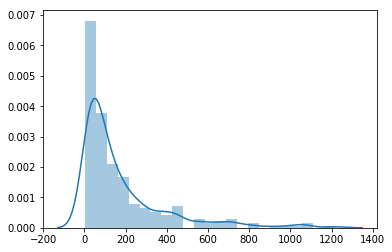

In [15]:
sns.distplot(y)

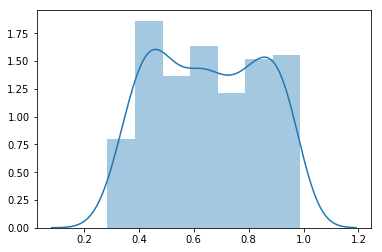

In [16]:
sns.distplot(x)

In [18]:
selector=Sel_BW(coords,y,x,multi=True)

In [28]:
selector=Sel_BW(coords,y_std,x_std,multi=True,constant=False)
selector.search(pool=pool)
#print(selector.bw[0])

array([59.])

In [29]:
mgwr_model=MGWR(coords,y_std,x_std,selector,constant=False).fit()

In [30]:
mgwr_model.R2

0.4764076769090986

In [42]:
selector=Sel_BW(coords,y_std,X_std,multi=True,constant=False,family=Poisson(),offset=off)

In [43]:
selector.search(pool=pool)

Exception: one or more input arrays have missing/NaN values

In [38]:
selector_gwr=Sel_BW(coords,y_std,x_std,constant=False,family=Poisson(),offset=off)

In [39]:
selector_gwr.search()

261.0

#### From search.py

In [104]:
def gwr_func(y, X, bw,family,offset):
    return GWR(coords, y, X, bw, family, offset, constant=False,
               spherical=False, hat_matrix=False).fit(
                   lite=True, pool=pool)

def bw_func(y, X,family,offset):
    selector = Sel_BW(coords, y, X, family, offset,
                      constant=False)
    return selector

#def sel_func(selector):
    #return selector.search(pool=pool)

In [130]:
def sel_func(bw_func, bw_min=None, bw_max=None):
            return bw_func.search(
                search_method=search_method, criterion=criterion,
                bw_min=bw_min, bw_max=bw_max, interval=interval, tol=tol,
                max_iter=max_iter, pool=self.pool, verbose=False)

In [85]:
def sel_func(coords,y,X,family,offset):
    selector = Sel_BW(coords,y,X,family,offset,constant=False)
    return selector.search(pool=pool)

In [62]:
family=Poisson()
kernel='bisquare'
fixed=False
offset=off
spherical=False
search_method='golden_section'
criterion='AICc'
interval=None
tol=1e-06
max_iter=200

In [63]:
def gwr_func(y, X, bw):
    return GWR(coords, y, X, bw, family=family, kernel=kernel,
               fixed=fixed, offset=offset, constant=False,
               spherical=spherical, hat_matrix=False).fit(
                   lite=True, pool=pool)

def bw_func(y, X):
    selector = Sel_BW(coords, y, X, X_glob=[], family=family,
                      kernel=kernel, fixed=fixed, offset=offset,
                      constant=False, spherical=spherical)
    return selector

def sel_func(bw_func, bw_min=None, bw_max=None):
    return bw_func.search(
        search_method=search_method, criterion=criterion,
        bw_min=bw_min, bw_max=bw_max, interval=interval, tol=tol,
        max_iter=max_iter, pool=pool, verbose=False)


In [78]:
Sel_BW?

In [83]:
selector=bw_func(coords=coords,y=y,X=x,family=Poisson(),offset=off)

In [88]:
sel_func(coords=coords,y=y,X=x,family=Poisson(),offset=off)

TypeError: object of type 'Poisson' has no len()

In [153]:
def multi_bw(init,bw, coords,y, X, n, k, family,offset, tol, max_iter, multi_bw_min, multi_bw_max,rss_score,bws_same_times=3,
             
             verbose=False):
    """
    Multiscale GWR bandwidth search procedure using iterative GAM backfitting
    """
    print(family)
    #if family == Poisson():
    #bw = Sel_BW(coords=coords,y=y,X=x,family=Poisson(),offset=off).search(pool=pool)
    bw=bw
    optim_model=gwr_func(y,X,bw)
    #if init is None:
        #bw = sel_func(bw_func(y, X))
        #optim_model = gwr_func(y, X, bw)
    #else:
        #bw = init
        #optim_model = gwr_func(y, X, init)
    bw_gwr = bw
    err = optim_model.resid_response.reshape((-1, 1))
    param = optim_model.params

    XB = np.multiply(param, X)
    if rss_score:
        rss = np.sum((err)**2)
    iters = 0
    scores = []
    delta = 1e6
    BWs = []
    bw_stable_counter = np.ones(k)
    bws = np.empty(k)

    try:
        from tqdm.auto import tqdm  #if they have it, let users have a progress bar
    except ImportError:

        def tqdm(x, desc=''):  #otherwise, just passthrough the range
            return x

    for iters in tqdm(range(1, max_iter + 1), desc='Backfitting'):
        new_XB = np.zeros_like(X)
        params = np.zeros_like(X)

        for j in range(1):
            print("iteration for j = "+str(j))
            temp_y = XB[:, j].reshape((-1, 1))
            temp_y = temp_y + err
            print(sns.distplot(tempy))
            temp_X = X[:, j].reshape((-1, 1))
            print(temp_X)
            bw_class = bw_func(temp_y, temp_X)
            print(bw_class)

            if np.all(bw_stable_counter == bws_same_times):
                #If in backfitting, all bws not changing in bws_same_times (default 3) iterations
                bw = bws[j]
            else:
                print(multi_bw_min[j])
                bw = sel_func(bw_class, multi_bw_min[j], multi_bw_max[j])
                print(bw)
                if bw == bws[j]:
                    bw_stable_counter[j] += 1
                else:
                    bw_stable_counter = np.ones(k)

            optim_model = gwr_func(temp_y, temp_X, bw)
            err = optim_model.resid_response.reshape((-1, 1))
            param = optim_model.params.reshape((-1, ))
            #new_XB[:, j] = optim_model.predy.reshape(-1)
            new_XB = np.multiply(param, temp_X)
            print("params = "+str(param))
            #print("new_XB = "+str(new_XB))
            params[:, j] = param
            bws[j] = bw

        num = np.sum((new_XB - XB)**2) / n
        den = np.sum(np.sum(new_XB, axis=1)**2)
        score = (num / den)**0.5
        XB = new_XB

        if rss_score:
            predy = np.sum(np.multiply(params, X), axis=1).reshape((-1, 1))
            new_rss = np.sum((y - predy)**2)
            score = np.abs((new_rss - rss) / new_rss)
            rss = new_rss
        scores.append(deepcopy(score))
        delta = score
        BWs.append(deepcopy(bws))

        if verbose:
            print("Current iteration:", iters, ",SOC:", np.round(score, 7))
            print("Bandwidths:", ', '.join([str(bw) for bw in bws]))

        if delta < tol:
            break

    opt_bws = BWs[-1]
    return (opt_bws, np.array(BWs), np.array(scores), params, err, bw_gwr)

In [129]:
tempy=XB1[:,0].reshape(-1,1)+err

In [139]:
temp_gwr=GWR(coords,tempy,tempx,bw=163.0,constant=False).fit()

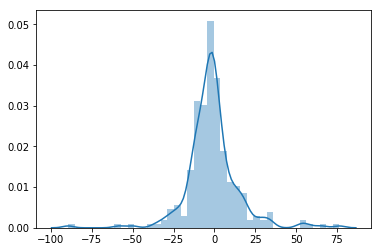

In [149]:
sns.distplot(tempy)

In [140]:
temp_gwr.resid_response.reshape((-1, 1))

array([[-1.58279234e+00],
       [-4.10206171e+00],
       [-9.01055575e+00],
       [-7.85509127e+00],
       [-8.63153656e+00],
       [ 4.13955380e-01],
       [-4.45428034e+00],
       [-6.12499241e-01],
       [ 3.61444865e+01],
       [ 8.91798750e-01],
       [ 2.52869659e+00],
       [ 3.91979252e+00],
       [ 3.15981446e+00],
       [-2.39208615e+00],
       [ 1.88509506e+00],
       [ 1.68379805e-01],
       [ 2.31766923e+00],
       [-8.01410557e+00],
       [-6.69505009e+00],
       [ 1.30426449e+00],
       [-7.25420172e-01],
       [-1.19520093e+00],
       [-4.03131641e-01],
       [ 1.00661502e+01],
       [ 6.62157794e+00],
       [ 2.15247973e+00],
       [ 8.50482680e+00],
       [ 1.43059047e+01],
       [ 3.21291895e+00],
       [ 8.36060192e+00],
       [ 3.59415410e+00],
       [ 8.05540007e-02],
       [-5.65180119e+00],
       [ 6.48561649e-02],
       [-1.25477694e+00],
       [-4.13576351e+00],
       [-5.65907192e+00],
       [-8.19068288e+00],
       [-2.4

In [125]:
tempx=x[:,0].reshape(-1,1)

In [120]:
err = gwr_model.resid_response.reshape((-1, 1))

In [117]:
XB1=np.multiply(gwr_model.params,x)

In [90]:
optim_model=gwr_func(x,y,bw_in)

In [107]:
gwr_model=GWR(coords,y,X,bw=163.0,family=Poisson(),offset=off,constant=False).fit(lite=False)

In [157]:
np.isnan(gwr_model.params).any()

False

In [ ]:
def multi_bw(init, y, X, n, k, family,offset, tol, max_iter,gwr_func,
             bw_func, sel_func, multi_bw_min, multi_bw_max,
             verbose=False):

In [22]:
bw_in=Sel_BW(coords,y,x,family=Poisson(),offset=off).search(pool=pool)

In [199]:
family=Poisson()
kernel='bisquare'
fixed=False
offset=off
spherical=False
search_method='golden_section'
criterion='AICc'
interval=None
tol=1e-06
max_iter=200

In [276]:
def gwr_func(y, X, bw,family=Gaussian(),offset=None):
    return GWR(coords, y, X, bw, family,offset,kernel=kernel,
               fixed=fixed, constant=False,
               spherical=spherical, hat_matrix=False).fit(
                   lite=True, pool=pool)

def bw_func(coords,y, X):
    selector = Sel_BW(coords,y, X,family=Poisson(),offset=off, X_glob=[],
                      kernel=kernel, fixed=fixed,
                      constant=False, spherical=spherical)
    return selector

def sel_func(bw_func, bw_min=None, bw_max=None):
    return bw_func.search(
        search_method=search_method, criterion=criterion,
        bw_min=bw_min, bw_max=bw_max, interval=interval, tol=tol,
        max_iter=max_iter, pool=pool, verbose=False)

In [164]:
gwr_func(y,x,163.0,family=Poisson(),offset=off).predy

array([[ 188.21900214],
       [  93.3563213 ],
       [  79.90378327],
       [  50.39507382],
       [  65.03953479],
       [ 116.84734565],
       [  64.58321068],
       [  84.01992128],
       [ 185.87976764],
       [  22.89479286],
       [  23.04126122],
       [  60.19884927],
       [  34.37732212],
       [  15.95360456],
       [  19.1864393 ],
       [  14.21577578],
       [  23.5076495 ],
       [  30.40592831],
       [  15.41730722],
       [  38.82849967],
       [  18.14797295],
       [  36.36312733],
       [  13.77460034],
       [  33.39479207],
       [  60.58394122],
       [  13.36360689],
       [  46.41133148],
       [  23.42314386],
       [  39.26826164],
       [  45.76113947],
       [  46.24065662],
       [  27.99576205],
       [ 114.548863  ],
       [  24.07511923],
       [  15.90613217],
       [  16.35600354],
       [  47.79107473],
       [  35.48817952],
       [ 414.97864073],
       [ 215.88955459],
       [ 648.59643776],
       [ 598.239

In [172]:
bw_gwpr=Sel_BW(coords,y,x,family=Poisson(),offset=off).search()

In [174]:
bw_gwr=Sel_BW(coords,y,x).search()

In [184]:
family

In [186]:
import spglm

In [187]:
isinstance(family,spglm.family.Poisson)

True

In [190]:
params=gwr_model.params

In [192]:
v=spdot(X.reshape(-1),params.reshape(-1,1))

In [193]:
yhat = (off*np.exp(v))

In [ ]:
v=spdot(x_std.reshape(-1),n_betas.reshape(-1,1))
yhat=(off*np.exp(v))

In [213]:
def multi_bw(init,bw, coords,y, X, n, k, family,offset, tol, max_iter, multi_bw_min, multi_bw_max,rss_score,bws_same_times=3,
             
             verbose=False):

    print(family)
    if isinstance(family,spglm.family.Poisson):
        bw = bw_gwpr
        optim_model=gwr_func(y,X,bw,family=Poisson(),offset=offset)
    else:
        bw=bw
        optim_model=gwr_func(y,X,bw)
        
    bw_gwr = bw
    err = optim_model.resid_response.reshape((-1, 1))
    param = optim_model.params

    #XB = np.multiply(param, X)
    v = spdot(X.reshape(-1),param.reshape(-1,1))
    XB = (offset*np.exp(v))
    if rss_score:
        rss = np.sum((err)**2)
    iters = 0
    scores = []
    delta = 1e6
    BWs = []
    bw_stable_counter = np.ones(k)
    bws = np.empty(k)

    try:
        from tqdm.auto import tqdm  #if they have it, let users have a progress bar
    except ImportError:

        def tqdm(x, desc=''):  #otherwise, just passthrough the range
            return x

    for iters in tqdm(range(1, max_iter + 1), desc='Backfitting'):
        new_XB = np.zeros_like(X)
        params = np.zeros_like(X)

        for j in range(1):
            print("iteration for j = "+str(j))
            temp_y = XB[:, j].reshape((-1, 1))
            temp_y = temp_y + err
            temp_X = X[:, j].reshape((-1, 1))
            bw_class = bw_func(temp_y, temp_X)

            if np.all(bw_stable_counter == bws_same_times):
                #If in backfitting, all bws not changing in bws_same_times (default 3) iterations
                bw = bws[j]
            else:
                bw = sel_func(bw_class, multi_bw_min[j], multi_bw_max[j])
                print("bw = "+str(bw))
                if bw == bws[j]:
                    bw_stable_counter[j] += 1
                else:
                    bw_stable_counter = np.ones(k)

            optim_model = gwr_func(temp_y, temp_X, bw,family=Poisson(),offset=offset)
            err = optim_model.resid_response.reshape((-1, 1))
            param = optim_model.params.reshape((-1, ))
            print("param = "+str(param))
            new_v=spdot(X.reshape(-1),param.reshape(-1,1))
            new_XB = (offset*np.exp(new_v))
            #new_XB = np.multiply(param, temp_X)
            print("new XB = "+str(new_XB))
            #print("new_XB = "+str(new_XB))
            params[:, j] = param
            bws[j] = bw

        num = np.sum((new_XB - XB)**2) / n
        den = np.sum(np.sum(new_XB, axis=1)**2)
        score = (num / den)**0.5
        XB = new_XB

        if rss_score:
            predy = np.sum(np.multiply(params, X), axis=1).reshape((-1, 1))
            new_rss = np.sum((y - predy)**2)
            score = np.abs((new_rss - rss) / new_rss)
            rss = new_rss
        scores.append(deepcopy(score))
        delta = score
        BWs.append(deepcopy(bws))

        if verbose:
            print("Current iteration:", iters, ",SOC:", np.round(score, 7))
            print("Bandwidths:", ', '.join([str(bw) for bw in bws]))

        if delta < tol:
            break

    opt_bws = BWs[-1]
    return (opt_bws, np.array(BWs), np.array(scores), params, err, bw_gwr)

In [279]:
bw_gwpr=Sel_BW(coords,y,x)

In [281]:
bw_gwr=bw_gwpr.search()

In [241]:
bw = bw_gwpr
optim_model=gwr_func(y,x,bw,family=Poisson(),offset=off)
err = optim_model.resid_response.reshape((-1, 1))
param = optim_model.params
#v = spdot(x.reshape(-1),param.reshape(-1,1))
#XB = (off*np.exp(v))

In [248]:
new_XB = np.zeros_like(x)

In [249]:
new_XB[:, j] = optim_model.predy.reshape(-1)

In [244]:
temp_y=optim_model.predy.reshape(-1)

In [250]:
temp_y = new_XB[:, j].reshape((-1, 1))
temp_y = temp_y + err
temp_X = x[:, j].reshape((-1, 1))

In [251]:
optim_model = gwr_func(temp_y, temp_X, bw_gwpr,family=Poisson(),offset=offset)
err = optim_model.resid_response.reshape((-1, 1))
param = optim_model.params

In [260]:
new_XB = np.zeros_like(x)

In [261]:
new_XB[:, j] = optim_model.predy.reshape(-1)

In [256]:
#temp_y=optim_model.predy.reshape(-1)

In [262]:
temp_y = new_XB[:, j].reshape((-1, 1))
temp_y = temp_y + err
temp_X = x[:, j].reshape((-1, 1))

In [266]:
optim_model = gwr_func(temp_y, temp_X, bw_gwpr,family=Poisson(),offset=offset)
err = optim_model.resid_response.reshape((-1, 1))
param = optim_model.params.reshape(-1, )

In [288]:
#temp_y[:, j].reshape((-1, 1))


In [286]:
#temp_y.reshape(-1)

In [303]:
k=X.shape[1]

In [ ]:
data_p = ps.io.open(ps.examples.get_path('Tokyomortality.csv'))
coords = list(zip(data_p.by_col('X_CENTROID'),data_p.by_col('Y_CENTROID')))
off = np.array(data_p.by_col('eb2564')).reshape((-1,1))
y = np.array(data_p.by_col('db2564')).reshape((-1,1)) 
occ = np.array(data_p.by_col('OCC_TEC')).reshape((-1,1))
own = np.array(data_p.by_col('OWNH')).reshape((-1,1))
pop = np.array(data_p.by_col('POP65')).reshape((-1,1))
unemp = np.array(data_p.by_col('UNEMP')).reshape((-1,1))
X = np.hstack([occ,own,pop,unemp])
x = own

X_std = (X-X.mean(axis=0))/X.std(axis=0)
x_std = (x-x.mean(axis=0))/x.std(axis=0)
y_std = (y-y.mean(axis=0))/y.std(axis=0)

In [319]:
def multi_bw(init,bw, coords,y, X, n, k, family,offset, tol, max_iter, multi_bw_min, multi_bw_max,rss_score,bws_same_times=3,
             
             verbose=False):
    
    if isinstance(family,spglm.family.Poisson):
        bw = sel_func(bw_func(coords,y,X))
        print(bw)
        optim_model=gwr_func(y,X,bw,family=Poisson(),offset=offset)
    else:
        bw=bw_gwr
        optim_model=gwr_func(y,X,bw)
        
    bw_gwr = bw
    err = optim_model.resid_response.reshape((-1, 1))
    param = optim_model.params

    XB = offset*np.exp(np.multiply(param, X))
    #v = spdot(X.reshape(-1),param.reshape(-1,1))
    #XB = (offset*np.exp(v))
    #XB=optim_model.predy
    if rss_score:
        rss = np.sum((err)**2)
    iters = 0
    scores = []
    delta = 1e6
    BWs = []
    bw_stable_counter = np.ones(k)
    bws = np.empty(k)

    try:
        from tqdm.auto import tqdm  #if they have it, let users have a progress bar
    except ImportError:

        def tqdm(x, desc=''):  #otherwise, just passthrough the range
            return x

    for iters in tqdm(range(1, max_iter + 1), desc='Backfitting'):
        new_XB = np.zeros_like(X)
        params = np.zeros_like(X)

        for j in range(k):
            print("iteration for j = "+str(j))
            temp_y = XB[:, j].reshape((-1, 1))
            temp_y = temp_y + err
            temp_X = X[:, j].reshape((-1, 1))
            bw_class = bw_func(coords,temp_y, temp_X)

            if np.all(bw_stable_counter == bws_same_times):
                #If in backfitting, all bws not changing in bws_same_times (default 3) iterations
                bw = bws[j]
            else:
                bw = sel_func(bw_class, multi_bw_min[j], multi_bw_max[j])
                print("bw = "+str(bw))
                if bw == bws[j]:
                    bw_stable_counter[j] += 1
                else:
                    bw_stable_counter = np.ones(k)

            optim_model = gwr_func(temp_y, temp_X, bw,family=Poisson(),offset=offset)
            err = optim_model.resid_response.reshape((-1, 1))
            param = optim_model.params.reshape((-1, ))
            print("param = "+str(param))
            #new_v=spdot(X.reshape(-1),param.reshape(-1,1))
            #new_XB = (offset*np.exp(new_v))
            #new_XB = np.multiply(param, temp_X)
            new_XB[:, j] = optim_model.predy.reshape(-1)
            print("new XB = "+str(new_XB))
            #print("new_XB = "+str(new_XB))
            params[:, j] = param
            bws[j] = bw

        num = np.sum((new_XB - XB)**2) / n
        den = np.sum(np.sum(new_XB, axis=1)**2)
        score = (num / den)**0.5
        XB = new_XB

        #if rss_score:
            #predy = np.sum(np.multiply(params, X), axis=1).reshape((-1, 1))
            #new_rss = np.sum((y - predy)**2)
            #score = np.abs((new_rss - rss) / new_rss)
            #rss = new_rss
        scores.append(deepcopy(score))
        delta = score
        BWs.append(deepcopy(bws))

        if verbose:
            print("Current iteration:", iters, ",SOC:", np.round(score, 7))
            print("Bandwidths:", ', '.join([str(bw) for bw in bws]))

        if delta < tol:
            break
            
    print(iters)
    opt_bws = BWs[-1]
    return (opt_bws, np.array(BWs), np.array(scores), params, err, bw_gwr)

In [320]:
bw_mgwr = multi_bw(init=None,bw=bw_in, coords=coords,y=y, X=X, n=262, k=4, family=Poisson(),offset=off,tol=1e-06,
                   max_iter=200, multi_bw_min=[2,2,2,2], multi_bw_max=[262,262,262,262],rss_score=False)

79.0
iteration for j = 0
bw = 37.0
param = [-0.91911559 -1.34144223 -2.03265125 -0.54259966 -1.30874546 -2.45615957
 -1.54693057 -1.53975823 -0.68679328 -1.63342534 -1.24582678 -1.24663369
 -1.469448   -2.01427291 -2.28918968 -1.57339732 -1.84147368 -0.96017345
 -0.75137355 -1.9234546  -1.67590631 -0.71692463 -0.57218238 -0.60725282
 -1.29237676 -1.58601006 -1.06019587 -1.04347843 -1.50203407 -2.31360465
 -2.28208672 -2.60985057 -1.36247675 -1.42647549 -1.38320201 -1.10113811
 -0.98104158 -1.18054356 -2.02669322 -0.62762437 -2.08395274 -2.09791374
 -2.15975949 -1.16436886 -2.01733149 -1.62357109 -1.65653048 -1.03150155
 -2.14386978 -2.11982757 -1.95387705 -1.46649417 -1.88126122 -2.22247735
 -2.08947481 -2.14928129 -2.14210795 -2.07649355 -2.07465069 -2.04461214
 -2.07936354 -2.05330784 -2.02342373 -2.09510263 -2.04627711 -2.21555465
 -2.03660367 -2.12997801 -2.18801539 -1.9969238  -2.00079489 -2.2943558
 -2.21878967 -1.62276423 -1.82955409 -1.71372821 -1.74784846 -2.22070716
 -1.19372

 1.76089115 1.84656278 1.71101388 1.71345515]
new XB = [[173.29471668 175.39254512 239.38145937   0.        ]
 [ 84.48590287  95.62193658 123.13249032   0.        ]
 [ 67.10153364  73.19712285 106.7089509    0.        ]
 ...
 [ 32.93939103  28.11563485  49.18474182   0.        ]
 [ 12.740065    12.7245203   20.18045205   0.        ]
 [ 12.815686    11.37770444  20.55116647   0.        ]]
iteration for j = 3
bw = 38.0
param = [ 0.01025076 -0.00449701  0.04564784 -0.01257035  0.04244837  0.05884527
  0.04127492  0.03160344  0.00544003  0.03622058  0.0260972   0.02277565
  0.03403622  0.04700989  0.05500693  0.03456854  0.04371975  0.01212929
  0.0018865   0.04784824  0.04700601 -0.00450908 -0.00282929  0.00630973
 -0.00230288  0.01441978 -0.00550448  0.0138752   0.01657471  0.05813105
  0.05361415  0.05861926 -0.03423601 -0.02059756 -0.03092542 -0.04172745
 -0.04745233 -0.0424927   0.06098177 -0.04238561  0.05271964  0.05556425
  0.05868281 -0.03109459  0.06998096  0.05985791  0.00375752

 -0.36995332 -0.40528828 -0.36986522 -0.38056842]
new XB = [[157.82850526 177.40167022   0.           0.        ]
 [ 78.60263959  88.89379307   0.           0.        ]
 [ 65.34243749  73.15025726   0.           0.        ]
 ...
 [ 32.91056392  29.07038549   0.           0.        ]
 [ 12.58239164  12.85709098   0.           0.        ]
 [ 12.67278146  11.52719074   0.           0.        ]]
iteration for j = 2
bw = 53.0
param = [2.09004762 2.33820283 2.06896829 2.13661186 2.00371833 1.87540188
 1.99359423 2.10716917 2.06804174 2.17691938 2.16454176 2.12551283
 2.05897141 2.17662919 2.16597435 2.20788451 2.22526415 2.12984659
 2.06818204 1.99685471 1.99409357 2.15587659 2.11622669 2.09259346
 2.25973344 2.14752717 2.21001877 2.10940564 2.11569185 1.87528545
 1.97414534 2.00762344 2.7004791  2.53575822 2.70058411 2.93888787
 3.03554748 2.88324617 1.95291021 3.2363235  1.71776031 1.70200862
 1.70613482 2.88409435 1.78963268 2.61181456 2.41916475 3.21961938
 1.67696779 1.72944737 1.986112

 -2.1177924  -2.1128135  -2.09905432 -2.09314246]
new XB = [[148.30462178   0.           0.           0.        ]
 [ 78.2037619    0.           0.           0.        ]
 [ 65.61349705   0.           0.           0.        ]
 ...
 [ 33.01627121   0.           0.           0.        ]
 [ 12.55272428   0.           0.           0.        ]
 [ 12.65606204   0.           0.           0.        ]]
iteration for j = 1
bw = 71.0
param = [-0.17082547 -0.19352482 -0.1818752  -0.15711306 -0.14773832 -0.16146619
 -0.1471185  -0.17632926 -0.16095659 -0.19367824 -0.18772227 -0.17700829
 -0.16502711 -0.19864107 -0.20065742 -0.19907771 -0.20432033 -0.18007329
 -0.16678475 -0.15760571 -0.15059632 -0.15702761 -0.15375516 -0.15183623
 -0.18186237 -0.17566191 -0.1693018  -0.15510627 -0.16305973 -0.14501316
 -0.16972495 -0.18771892 -0.22592576 -0.21502217 -0.22755489 -0.22865645
 -0.22956708 -0.22907633 -0.22753761 -0.22728807 -0.12602926 -0.14768261
 -0.17392802 -0.23050543 -0.21516421 -0.2434985  -0.2144

 0.08305477 0.08605766 0.08047807 0.08051444]
new XB = [[148.30462178 175.4373573  240.62714487 225.16225399]
 [ 78.2037619   85.64953991 125.29587156 106.83645809]
 [ 65.61349705  72.84642155 102.98772332  91.75504442]
 ...
 [ 33.01627121  30.09156328  48.94880685  48.20911579]
 [ 12.55272428  13.16234025  20.24215835  20.342282  ]
 [ 12.65606204  11.94383823  20.61331202  19.19578596]]
iteration for j = 0
bw = 261.0
param = [-2.13378135 -2.11991386 -2.13731889 -2.12673914 -2.1306363  -2.13606656
 -2.127802   -2.13616398 -2.13109487 -2.13769792 -2.13668026 -2.13573021
 -2.13453357 -2.1386001  -2.13907445 -2.13815314 -2.13898994 -2.13507404
 -2.13196124 -2.13423207 -2.13249492 -2.12536735 -2.12750513 -2.12804214
 -2.12165854 -2.12219268 -2.12339475 -2.12591505 -2.12421064 -2.13309902
 -2.13639827 -2.1385105  -2.11403245 -2.11656293 -2.11408054 -2.11190054
 -2.11095989 -2.11218918 -2.11270362 -2.11008399 -2.12639929 -2.12094061
 -2.11836872 -2.11247299 -2.11200831 -2.10721607 -2.1166532

 1.76578565 1.77589738 1.73861339 1.74348251]
new XB = [[148.70222614 174.70192596 237.30974143   0.        ]
 [ 77.73364893  85.38701175 123.16674443   0.        ]
 [ 66.36117226  73.0322421  102.00516243   0.        ]
 ...
 [ 33.03924527  31.27643624  48.84530389   0.        ]
 [ 12.5413465   13.46130202  20.24628172   0.        ]
 [ 12.63814365  12.33309282  20.63774192   0.        ]]
iteration for j = 3
bw = 40.0
param = [0.0543236  0.03304931 0.05572292 0.04980873 0.05703742 0.05330821
 0.05195734 0.05533132 0.05686755 0.05867898 0.05747506 0.05550458
 0.0551048  0.06026561 0.06033306 0.06047067 0.06246083 0.05527392
 0.05432162 0.05517445 0.05633113 0.04394555 0.05240349 0.05542133
 0.03481338 0.03832347 0.03755579 0.04552839 0.04202674 0.05465063
 0.05374622 0.05328852 0.02021964 0.02440676 0.02198168 0.0256248
 0.02728919 0.02281202 0.05336829 0.04098663 0.05234533 0.05150313
 0.04930534 0.02905909 0.06303615 0.07041727 0.03145261 0.05538947
 0.05047646 0.05025641 0.06218894 0.

 -0.27270152 -0.28178264 -0.26958012 -0.27160844]
new XB = [[149.39263978 175.52694862   0.           0.        ]
 [ 77.91190331  85.89511056   0.           0.        ]
 [ 66.63702301  73.61438299   0.           0.        ]
 ...
 [ 33.08276495  32.29212108   0.           0.        ]
 [ 12.56190408  13.75479318   0.           0.        ]
 [ 12.6562443   12.69964541   0.           0.        ]]
iteration for j = 2
bw = 118.0
param = [1.85926322 1.97533985 1.85013625 1.91446114 1.88105749 1.84746743
 1.89948242 1.85107034 1.87722893 1.86589318 1.8621153  1.85346063
 1.85590097 1.86848436 1.87013061 1.87924539 1.89086878 1.85995934
 1.87056852 1.85558318 1.86537867 1.93299913 1.9092238  1.90238458
 1.9601876  1.93938749 1.94594938 1.92941503 1.93001967 1.858681
 1.84754277 1.84883781 2.08470349 2.03697404 2.07885741 2.1364453
 2.15706451 2.12922387 1.89364415 2.17867789 1.8403472  1.82865107
 1.82952725 2.11383791 1.83039015 2.0142186  2.00850648 2.12726382
 1.84791852 1.86646408 1.88245049

 -2.08255644 -2.08206704 -2.08153172 -2.0812396 ]
new XB = [[149.79090653   0.           0.           0.        ]
 [ 78.08945991   0.           0.           0.        ]
 [ 66.77951796   0.           0.           0.        ]
 ...
 [ 33.1209957    0.           0.           0.        ]
 [ 12.5813512    0.           0.           0.        ]
 [ 12.67369958   0.           0.           0.        ]]
iteration for j = 1
bw = 121.0
param = [-0.16645228 -0.18059795 -0.16392079 -0.17074598 -0.16273528 -0.16299397
 -0.16346597 -0.1645259  -0.1664533  -0.16242975 -0.16392651 -0.16500127
 -0.16439345 -0.1611937  -0.16077186 -0.16058744 -0.1585661  -0.16600471
 -0.16724987 -0.16344025 -0.16310909 -0.1717823  -0.16832478 -0.16639801
 -0.17867211 -0.17591194 -0.17592942 -0.16785069 -0.17122509 -0.16159374
 -0.1636476  -0.16278005 -0.18064731 -0.18182767 -0.18067942 -0.17885824
 -0.1776724  -0.17943419 -0.18632935 -0.17515704 -0.16620901 -0.17407519
 -0.18062592 -0.17899217 -0.19818153 -0.18410363 -0.181

 0.07277427 0.07295671 0.06937882 0.06852705]
new XB = [[149.79090653 175.9029098  236.53589824 225.45577171]
 [ 78.08945991  86.39568976 120.14177076 110.96279509]
 [ 66.77951796  73.81145914 102.31308369  90.89902804]
 ...
 [ 33.1209957   33.03197139  49.25673305  47.04240072]
 [ 12.5813512   13.93561378  20.54658555  19.76187822]
 [ 12.67369958  12.94041062  20.98853994  18.71141301]]
iteration for j = 0
bw = 261.0
param = [-2.0607632  -2.06139425 -2.06347238 -2.06060229 -2.06335031 -2.06528091
 -2.0636455  -2.06261967 -2.06115931 -2.06167646 -2.06092412 -2.06165465
 -2.06295707 -2.06247043 -2.06307309 -2.06079609 -2.06097953 -2.05978026
 -2.06027881 -2.06397369 -2.06377564 -2.06111928 -2.06134611 -2.06196156
 -2.06116253 -2.06252448 -2.06103078 -2.06231458 -2.06249583 -2.06527189
 -2.06446986 -2.06470422 -2.06061414 -2.06087899 -2.06121159 -2.06135462
 -2.06095899 -2.06072784 -2.06673449 -2.062282   -2.07022183 -2.06862257
 -2.06699122 -2.06232155 -2.06906177 -2.06660951 -2.0622834

 1.85779321 1.85764897 1.85897417 1.85915482]
new XB = [[150.07664208 175.79251878 236.46256315   0.        ]
 [ 78.22191289  86.64097932 120.00328107   0.        ]
 [ 66.88266799  73.73934807 102.30932351   0.        ]
 ...
 [ 33.15611663  33.37556365  49.23820747   0.        ]
 [ 12.59888106  14.03022692  20.53588265   0.        ]
 [ 12.6895253   13.0651463   20.97467285   0.        ]]
iteration for j = 3
bw = 37.0
param = [0.05131945 0.03720955 0.05106585 0.05400448 0.0609221  0.05190013
 0.05545893 0.05053516 0.05700881 0.05323641 0.05190102 0.05106261
 0.0527009  0.05480366 0.05494429 0.05487079 0.0578739  0.05101315
 0.0527702  0.05319458 0.05699692 0.04827866 0.05719225 0.06048247
 0.03885291 0.0405341  0.04047355 0.04926699 0.0440621  0.05488252
 0.05122173 0.04911199 0.03122469 0.03197392 0.03238399 0.03802707
 0.04121491 0.03497925 0.05135501 0.05726973 0.05318317 0.05148495
 0.04826525 0.04103769 0.06070194 0.07181416 0.03591686 0.06430627
 0.05108548 0.0514794  0.05953407 0

 -0.22829193 -0.23149624 -0.22873666 -0.22996223]
new XB = [[150.289418   175.65904774   0.           0.        ]
 [ 78.31507576  86.7810333    0.           0.        ]
 [ 66.96098655  73.67821987   0.           0.        ]
 ...
 [ 33.18414698  33.7040158    0.           0.        ]
 [ 12.6126785   14.13812436   0.           0.        ]
 [ 12.70195741  13.1786429    0.           0.        ]]
iteration for j = 2
bw = 261.0
param = [1.87519894 1.86801033 1.87628718 1.87037593 1.86911534 1.87182068
 1.86789423 1.87570129 1.87199951 1.87961601 1.87898711 1.87640221
 1.87318355 1.88001293 1.87994031 1.88179054 1.88309495 1.87803713
 1.87387023 1.87154854 1.87014314 1.86912044 1.86993675 1.86953818
 1.86782443 1.86701783 1.8683487  1.86829323 1.86741313 1.86885074
 1.87342706 1.87641013 1.86940436 1.86891673 1.86903889 1.86930456
 1.86971266 1.86966312 1.86495892 1.8688981  1.86135357 1.8629217
 1.86443025 1.86856354 1.86259787 1.86511006 1.86795679 1.8673412
 1.86445408 1.86489244 1.8640895

 -2.05697206 -2.05711313 -2.05579021 -2.05562802]
new XB = [[150.45822572   0.           0.           0.        ]
 [ 78.38749627   0.           0.           0.        ]
 [ 67.02348671   0.           0.           0.        ]
 ...
 [ 33.20623453   0.           0.           0.        ]
 [ 12.62352391   0.           0.           0.        ]
 [ 12.71173398   0.           0.           0.        ]]
iteration for j = 1
bw = 134.0
param = [-0.16975464 -0.17251402 -0.16705721 -0.17194582 -0.16955593 -0.16963462
 -0.16868449 -0.16821555 -0.17046613 -0.16395924 -0.16544254 -0.16808957
 -0.16957458 -0.16257407 -0.16221122 -0.16122638 -0.15907408 -0.16760578
 -0.17048127 -0.16962679 -0.16962925 -0.17208912 -0.17054736 -0.16986838
 -0.17291689 -0.17280046 -0.17270295 -0.17024488 -0.17119879 -0.16962784
 -0.16916082 -0.1662611  -0.16620345 -0.16950875 -0.16670536 -0.16302383
 -0.16108454 -0.16325621 -0.18006842 -0.15993126 -0.17584609 -0.17988849
 -0.18216542 -0.16466463 -0.19239057 -0.17237377 -0.171

 0.06869163 0.06819439 0.0653953  0.06437973]
new XB = [[150.45822572 175.5512394  236.48458388 225.27463754]
 [ 78.38749627  86.86560025 120.00401734 110.27244574]
 [ 67.02348671  73.64196187 102.3220272   90.88208399]
 ...
 [ 33.20623453  33.95774368  49.25068706  46.62532314]
 [ 12.62352391  14.22107454  20.54140057  19.5576346 ]
 [ 12.71173398  13.30008444  20.9815924   18.54669419]]
iteration for j = 0
bw = 261.0
param = [-2.03344682 -2.03481384 -2.03653621 -2.033478   -2.03613756 -2.03831542
 -2.03672851 -2.03551909 -2.03381104 -2.0347096  -2.03381001 -2.03446826
 -2.03578169 -2.03564961 -2.03634106 -2.03385766 -2.03416199 -2.03246194
 -2.03289488 -2.03685248 -2.03660742 -2.03405963 -2.034221   -2.03484643
 -2.03419823 -2.0357149  -2.03400133 -2.03534524 -2.0355742  -2.03821857
 -2.03748754 -2.03797347 -2.03501288 -2.03491711 -2.03573564 -2.03641676
 -2.03614794 -2.03557596 -2.04311598 -2.03800019 -2.04437087 -2.04351126
 -2.04199243 -2.03748237 -2.04648421 -2.04444378 -2.0364850

 1.86190821 1.86218903 1.86307198 1.86336268]
new XB = [[150.59407551 175.49678461 236.48669571   0.        ]
 [ 78.44470081  86.92338926 120.00797001   0.        ]
 [ 67.07390657  73.61455569 102.32362221   0.        ]
 ...
 [ 33.22348298  34.16680106  49.26011972   0.        ]
 [ 12.63198786  14.29746663  20.54581502   0.        ]
 [ 12.71936288  13.38129287  20.98703266   0.        ]]
iteration for j = 3
bw = 37.0
param = [0.05100268 0.03577299 0.05086924 0.05357956 0.06102501 0.05183136
 0.0554454  0.05030163 0.05677419 0.05296832 0.05158804 0.05077766
 0.05254181 0.05455694 0.05470928 0.05459318 0.05762954 0.05066294
 0.0524615  0.05316873 0.05705207 0.04768296 0.05690958 0.06034531
 0.03765704 0.03953206 0.03955085 0.04885072 0.04337487 0.05495853
 0.05111619 0.04889316 0.02916617 0.03002022 0.03030348 0.03604102
 0.0393173  0.03296916 0.04960531 0.05562155 0.05287594 0.05087159
 0.04727302 0.03903113 0.05889299 0.06979895 0.03406753 0.06266036
 0.05053491 0.05106713 0.05760514 0

 -0.20717864 -0.2104456  -0.20742579 -0.20805454]
new XB = [[150.70047784 175.5043319    0.           0.        ]
 [ 78.48930997  86.96491315   0.           0.        ]
 [ 67.11337915  73.61884865   0.           0.        ]
 ...
 [ 33.23696979  34.31323338   0.           0.        ]
 [ 12.63860088  14.34235746   0.           0.        ]
 [ 12.72532325  13.43782504   0.           0.        ]]
iteration for j = 2
bw = 261.0
param = [1.87591379 1.8692492  1.87717241 1.87125023 1.86979128 1.87259692
 1.86876462 1.87649597 1.87267956 1.88055612 1.87984522 1.87717425
 1.8739045  1.88103518 1.88100849 1.8827901  1.88418267 1.87879177
 1.87456134 1.87226243 1.87082966 1.8700228  1.87077334 1.87035138
 1.8688196  1.86804024 1.86929068 1.86919711 1.86834989 1.8695507
 1.8742291  1.87740595 1.87134808 1.87059895 1.87103613 1.87166368
 1.87217938 1.8719069  1.86801236 1.87167018 1.86263461 1.8648021
 1.86646721 1.87094257 1.86635517 1.86926828 1.86967753 1.87036138
 1.86581349 1.86594088 1.8677211

 -2.04463507 -2.04503605 -2.0434573  -2.04335936]
new XB = [[150.78040532   0.           0.           0.        ]
 [ 78.52298088   0.           0.           0.        ]
 [ 67.14301126   0.           0.           0.        ]
 ...
 [ 33.24756677   0.           0.           0.        ]
 [ 12.64377916   0.           0.           0.        ]
 [ 12.72999393   0.           0.           0.        ]]
iteration for j = 1
bw = 154.0
param = [-0.16900919 -0.1690523  -0.16646549 -0.17183651 -0.16982744 -0.1694436
 -0.16964189 -0.16749696 -0.17037974 -0.16341602 -0.16476568 -0.16735699
 -0.16929428 -0.16246404 -0.16226382 -0.16124866 -0.15957495 -0.16687117
 -0.17037413 -0.16959134 -0.16964684 -0.17151712 -0.17131747 -0.17079165
 -0.17013921 -0.17024745 -0.17106787 -0.1706759  -0.17052856 -0.16982457
 -0.16870014 -0.16569951 -0.16339456 -0.16620096 -0.16380116 -0.1611962
 -0.15997898 -0.16102595 -0.17331353 -0.15939453 -0.17499286 -0.17629839
 -0.17651164 -0.16269857 -0.18366865 -0.1683912  -0.16755

 0.06600798 0.06518739 0.06267946 0.06157191]
new XB = [[150.78040532 175.63056177 236.53168869 224.76736858]
 [ 78.52298088  87.06760733 120.03592699 109.8328806 ]
 [ 67.14301126  73.67390962 102.34650987  90.76577943]
 ...
 [ 33.24756677  34.52112726  49.27923282  46.3638801 ]
 [ 12.64377916  14.41157211  20.55514383  19.41959876]
 [ 12.72999393  13.53627185  20.99838136  18.43600032]]
iteration for j = 0
bw = 261.0
param = [-2.02054155 -2.02255188 -2.0237582  -2.02082705 -2.02347699 -2.02565631
 -2.02425212 -2.02268984 -2.02099454 -2.0218249  -2.02088048 -2.02158231
 -2.02299737 -2.02281482 -2.02354477 -2.02092453 -2.02124413 -2.01947101
 -2.02000192 -2.02414156 -2.0239256  -2.02148978 -2.02158249 -2.02222426
 -2.0217575  -2.02337256 -2.02148939 -2.02284331 -2.02314185 -2.02562453
 -2.02477367 -2.02527525 -2.02318781 -2.02291989 -2.0239785  -2.02490321
 -2.02468351 -2.02395411 -2.0322776  -2.02679904 -2.03259804 -2.03204466
 -2.0305526  -2.02603169 -2.03612645 -2.03424428 -2.0246037

 1.86831838 1.86876534 1.8694285  1.86975031]
new XB = [[150.83915033 175.72902215 236.5559851    0.        ]
 [ 78.54769012  87.14196179 120.05145176   0.        ]
 [ 67.16481765  73.72229049 102.35836545   0.        ]
 ...
 [ 33.25458773  34.6422038   49.29187699   0.        ]
 [ 12.64725438  14.44956009  20.56123159   0.        ]
 [ 12.7331223   13.58363423  21.00580909   0.        ]]
iteration for j = 3
bw = 35.0
param = [0.04982474 0.03433513 0.04921274 0.05353754 0.06198734 0.05102489
 0.05552368 0.04909512 0.05589273 0.05172405 0.05027807 0.0496109
 0.05146222 0.05371593 0.05421311 0.05396389 0.05758515 0.04945481
 0.05139744 0.05219649 0.05628649 0.04644282 0.0571435  0.05953342
 0.03628476 0.03825207 0.03795729 0.04739871 0.04169784 0.05400241
 0.05007008 0.04844642 0.02686568 0.02862489 0.02843286 0.03412814
 0.0378359  0.03066487 0.04768204 0.05494363 0.052121   0.04971458
 0.04535254 0.03772654 0.05789204 0.06847667 0.03292504 0.06144057
 0.04942793 0.05010454 0.05537627 0.

 -0.18584727 -0.18679956 -0.18428379 -0.18421446]
new XB = [[150.88432699 175.89792231   0.           0.        ]
 [ 78.56549806  87.22086631   0.           0.        ]
 [ 67.18087095  73.79724884   0.           0.        ]
 ...
 [ 33.25554225  35.01070509   0.           0.        ]
 [ 12.64791016  14.56748208   0.           0.        ]
 [ 12.73367688  13.72566343   0.           0.        ]]
iteration for j = 2
bw = 261.0
param = [1.88390627 1.87618607 1.88532922 1.87868824 1.877323   1.8804791
 1.87605363 1.88458913 1.88040584 1.88889623 1.88812514 1.88529349
 1.88180708 1.88942242 1.88940723 1.89125422 1.89273717 1.88698219
 1.88242438 1.88006126 1.87848558 1.87733005 1.87821236 1.87778494
 1.87591111 1.87505259 1.87648439 1.87645213 1.87548402 1.87715032
 1.88220759 1.88560709 1.87786427 1.87729178 1.87747876 1.87784382
 1.87830837 1.87821057 1.87336299 1.87748119 1.86925705 1.87098819
 1.8725803  1.87704542 1.87107105 1.87372465 1.87624397 1.8758516
 1.8724554  1.8728305  1.8725848

 -2.04170492 -2.04230016 -2.04052605 -2.04047456]
new XB = [[150.89831792   0.           0.           0.        ]
 [ 78.56990508   0.           0.           0.        ]
 [ 67.18677268   0.           0.           0.        ]
 ...
 [ 33.25693714   0.           0.           0.        ]
 [ 12.64859814   0.           0.           0.        ]
 [ 12.73429129   0.           0.           0.        ]]
iteration for j = 1
bw = 252.0
param = [-0.16465026 -0.16647314 -0.16432881 -0.16605787 -0.16655193 -0.16582356
 -0.16693309 -0.16458127 -0.1656279  -0.16314628 -0.1634704  -0.16431996
 -0.16529939 -0.16304751 -0.16308957 -0.16250784 -0.1621625  -0.16377845
 -0.16508276 -0.16583432 -0.16630155 -0.16631586 -0.16622823 -0.16637569
 -0.16641085 -0.16675375 -0.16637799 -0.1666173  -0.16676532 -0.1667389
 -0.16532362 -0.16416928 -0.16628941 -0.16613701 -0.16653578 -0.16688691
 -0.16683093 -0.16654623 -0.17018986 -0.16764513 -0.16982658 -0.1697933
 -0.16912635 -0.16729887 -0.1726932  -0.17168557 -0.16672

 0.06319103 0.06201095 0.0597361  0.05852225]
new XB = [[150.89831792 176.09510478 236.7667071  223.85049936]
 [ 78.56990508  87.21841864 120.1504454  109.45533362]
 [ 67.18677268  73.78938716 102.45092628  90.59228519]
 ...
 [ 33.25693714  35.2646579   49.29116393  46.08929779]
 [ 12.64859814  14.63976118  20.56227836  19.27109921]
 [ 12.73429129  13.81493504  21.00688234  18.31652064]]
iteration for j = 0
bw = 261.0
param = [-2.01697446 -2.01975007 -2.02021326 -2.01762299 -2.02026318 -2.02231712
 -2.0212285  -2.01913768 -2.01759423 -2.01812032 -2.01717232 -2.01797851
 -2.01955652 -2.01912342 -2.01987515 -2.01712732 -2.01741455 -2.01576063
 -2.01649343 -2.02079522 -2.02065288 -2.01838678 -2.01839238 -2.01905147
 -2.01881085 -2.02051797 -2.01846299 -2.01980713 -2.02019303 -2.02243847
 -2.02135378 -2.02176629 -2.02073879 -2.02032681 -2.02159352 -2.02272686
 -2.02254462 -2.02167757 -2.03075217 -2.02490565 -2.03026798 -2.02997505
 -2.0284965  -2.02392092 -2.03505666 -2.03330581 -2.0221271

 1.87134515 1.8715123  1.87255409 1.87282617]
new XB = [[150.90696068 176.14394991 236.75954862   0.        ]
 [ 78.5712418   87.25645271 120.15165322   0.        ]
 [ 67.1900605   73.80114668 102.44899681   0.        ]
 ...
 [ 33.25405439  35.39416274  49.30514828   0.        ]
 [ 12.64732621  14.67689988  20.56881636   0.        ]
 [ 12.73311537  13.86135269  21.01485657   0.        ]]
iteration for j = 3
bw = 37.0
param = [0.04881043 0.0337725  0.04901993 0.05104964 0.05901475 0.04997881
 0.05356292 0.04829887 0.05440044 0.0512961  0.04969613 0.04874424
 0.05048205 0.05310951 0.05341592 0.05305711 0.05639912 0.04859329
 0.05014019 0.0511888  0.05508168 0.04532584 0.05442488 0.05790846
 0.03556406 0.03747695 0.03732257 0.04669744 0.04131846 0.05317477
 0.04921599 0.04727996 0.02832092 0.0285285  0.0294142  0.03576993
 0.03924727 0.03258005 0.04691826 0.05583973 0.05129779 0.04876819
 0.044762   0.03856966 0.05572168 0.06747256 0.03223861 0.06211245
 0.04838599 0.04909199 0.05466739 0

 -0.17079509 -0.17105788 -0.17031049 -0.1702877 ]
new XB = [[150.89892888 176.31684228   0.           0.        ]
 [ 78.56600746  87.36027859   0.           0.        ]
 [ 67.18671326  73.89277124   0.           0.        ]
 ...
 [ 33.24893262  35.48286993   0.           0.        ]
 [ 12.64495895  14.7051213    0.           0.        ]
 [ 12.73095205  13.8966557    0.           0.        ]]
iteration for j = 2
bw = 261.0
param = [1.88683892 1.87998452 1.88834026 1.88197312 1.88061473 1.88368494
 1.87957563 1.8875724  1.88348482 1.89175787 1.89096376 1.88821655
 1.8848838  1.89231344 1.89232751 1.89403791 1.89550772 1.88978728
 1.88539473 1.8832381  1.88172698 1.88073128 1.88151885 1.881116
 1.87950465 1.87878062 1.87997362 1.87994527 1.87908445 1.88049921
 1.88533209 1.8886743  1.88215196 1.88137483 1.88185838 1.882507
 1.88301785 1.88273286 1.87893877 1.8825337  1.87374364 1.87584451
 1.87745095 1.88180637 1.87724238 1.88005081 1.88050439 1.88125127
 1.87675019 1.87681643 1.87859487 

 -2.04585194 -2.04659507 -2.04466915 -2.04465291]
new XB = [[150.87080526   0.           0.           0.        ]
 [ 78.55304192   0.           0.           0.        ]
 [ 67.17597361   0.           0.           0.        ]
 ...
 [ 33.24222833   0.           0.           0.        ]
 [ 12.64178742   0.           0.           0.        ]
 [ 12.72806744   0.           0.           0.        ]]
iteration for j = 1
bw = 258.0
param = [-0.16038399 -0.16179276 -0.16002745 -0.1614898  -0.16174307 -0.16112261
 -0.16205996 -0.16019288 -0.16110652 -0.15923421 -0.15942946 -0.16003346
 -0.16082586 -0.15917757 -0.15923391 -0.15874232 -0.15851233 -0.15968904
 -0.16069693 -0.16120462 -0.16152946 -0.16170759 -0.16158591 -0.16167419
 -0.16178465 -0.16201086 -0.16174985 -0.1619059  -0.16198386 -0.16183538
 -0.16073646 -0.1600217  -0.16164822 -0.16165745 -0.16174157 -0.16174289
 -0.16167165 -0.16166797 -0.16397181 -0.16228999 -0.16396861 -0.16383564
 -0.16341075 -0.16204092 -0.16543887 -0.16473288 -0.161

 0.06185616 0.06050595 0.05837596 0.05710794]
new XB = [[150.87080526 176.55096268 236.79180081 223.21258664]
 [ 78.55304192  87.49276155 120.1803108  109.03976608]
 [ 67.17597361  74.0224047  102.46931845  90.42882002]
 ...
 [ 33.24222833  35.55344361  49.3420152   45.95976893]
 [ 12.64178742  14.72849868  20.58645781  19.20286114]
 [ 12.72806744  13.92576815  21.03633652  18.26137373]]
iteration for j = 0
bw = 261.0
param = [-2.02118377 -2.02420008 -2.02450397 -2.02191119 -2.02454959 -2.02663527
 -2.02558797 -2.02339532 -2.02182196 -2.02237984 -2.02140171 -2.02221079
 -2.02381602 -2.02341419 -2.02418686 -2.0213781  -2.02168502 -2.01994836
 -2.02069621 -2.02508024 -2.02493906 -2.02270537 -2.02268576 -2.02335167
 -2.02318217 -2.02492958 -2.02280384 -2.02415387 -2.02456642 -2.02676146
 -2.02565566 -2.02610224 -2.02538589 -2.02489607 -2.02626842 -2.02750938
 -2.02735077 -2.02641466 -2.03580892 -2.02982256 -2.0349088  -2.03475007
 -2.03328846 -2.02872706 -2.04031622 -2.03864672 -2.0267428

 1.88166317 1.88202985 1.88273684 1.88303291]
new XB = [[150.82694496 176.77808442 236.86756842   0.        ]
 [ 78.53383888  87.61600036 120.22135109   0.        ]
 [ 67.15950835  74.12844759 102.50434322   0.        ]
 ...
 [ 33.23412176  35.62378871  49.35599425   0.        ]
 [ 12.63791155  14.75110261  20.59354597   0.        ]
 [ 12.72454951  13.95406993  21.0449071    0.        ]]
iteration for j = 3
bw = 37.0
param = [0.04739707 0.03228015 0.04756977 0.0493953  0.0575224  0.04870557
 0.05209052 0.04686612 0.05292324 0.04982132 0.04823875 0.04731592
 0.04909307 0.05158808 0.05190197 0.0515522  0.05485542 0.04716733
 0.04870338 0.0498181  0.05368084 0.04368675 0.05274828 0.05619842
 0.03405281 0.0360621  0.03574227 0.04512616 0.03984774 0.05190244
 0.04787162 0.04592704 0.02663323 0.02690049 0.02771237 0.03407533
 0.03757983 0.03088817 0.04563408 0.05424159 0.05042565 0.04777454
 0.04360249 0.03685777 0.05469983 0.06608275 0.03065574 0.06057025
 0.0472134  0.04787273 0.05346965 0

 -0.16391796 -0.16417104 -0.16345589 -0.16343472]
new XB = [[150.77327257 176.99205221   0.           0.        ]
 [ 78.51023152  87.73558005   0.           0.        ]
 [ 67.1394515   74.23784198   0.           0.        ]
 ...
 [ 33.22431512  35.69143488   0.           0.        ]
 [ 12.63321918  14.77311486   0.           0.        ]
 [ 12.72029152  13.98157671   0.           0.        ]]
iteration for j = 2
bw = 261.0
param = [1.894222   1.88781442 1.89599934 1.88948219 1.88834007 1.89156021
 1.88742826 1.89513924 1.89094606 1.89922232 1.89834874 1.89567938
 1.89250181 1.89986344 1.89994321 1.90141249 1.9029042  1.8970553
 1.89274682 1.89097861 1.88947032 1.88833389 1.88909304 1.88874828
 1.8872143  1.88665752 1.8876159  1.88768119 1.8868896  1.8884172
 1.89310849 1.89647153 1.89016791 1.8893056  1.88995753 1.89074311
 1.89124711 1.89086333 1.88795138 1.8910026  1.88265595 1.88474503
 1.88621108 1.89015333 1.88665761 1.88932277 1.88862405 1.8900053
 1.88522328 1.88508066 1.88783491

 -2.05434503 -2.0551248  -2.05317436 -2.05316957]
new XB = [[150.71092332   0.           0.           0.        ]
 [ 78.48283988   0.           0.           0.        ]
 [ 67.11612851   0.           0.           0.        ]
 ...
 [ 33.21303579   0.           0.           0.        ]
 [ 12.6278174    0.           0.           0.        ]
 [ 12.71539089   0.           0.           0.        ]]
iteration for j = 1
bw = 261.0
param = [-0.15430764 -0.15568041 -0.15409147 -0.15527363 -0.15550399 -0.15500125
 -0.15581078 -0.15420331 -0.15492973 -0.15342009 -0.15355061 -0.15406132
 -0.15470979 -0.15333405 -0.15334529 -0.15298455 -0.15271331 -0.15374267
 -0.15456827 -0.15504495 -0.15532011 -0.15549464 -0.15536119 -0.15544227
 -0.15562693 -0.15584295 -0.15558572 -0.15568425 -0.15581052 -0.15560141
 -0.15467085 -0.15407329 -0.15561003 -0.15565697 -0.1557439  -0.15587463
 -0.1558175  -0.1557033  -0.15771139 -0.15624657 -0.15759179 -0.15753517
 -0.15716094 -0.15610657 -0.1590489  -0.15844359 -0.155

 0.0609867  0.05953329 0.05745432 0.0561451 ]
new XB = [[150.71092332 177.2022698  237.01561783 222.25433946]
 [ 78.48283988  87.85234047 120.30430365 108.46910714]
 [ 67.11612851  74.34518344 102.57317402  90.19921058]
 ...
 [ 33.21303579  35.75500478  49.38942902  45.87624942]
 [ 12.6278174   14.79385624  20.61026373  19.15675981]
 [ 12.71539089  14.00750069  21.06515553  18.22392583]]
iteration for j = 0
param = [-2.03098232 -2.03393787 -2.03428467 -2.03168024 -2.03428032 -2.03636541
 -2.03530761 -2.03317937 -2.03159551 -2.03220097 -2.03122468 -2.03200873
 -2.03357927 -2.03323171 -2.03399892 -2.03122276 -2.03153812 -2.02977488
 -2.03049093 -2.03482184 -2.0346728  -2.03245947 -2.03244404 -2.03310071
 -2.03292166 -2.03464779 -2.03255142 -2.03388959 -2.03429142 -2.03646999
 -2.03540573 -2.03587316 -2.03514686 -2.03465021 -2.03602249 -2.03727372
 -2.03712472 -2.03618365 -2.04552671 -2.03959041 -2.04449179 -2.04438232
 -2.04295455 -2.03847837 -2.05004026 -2.04843219 -2.03647388 -2.042573

 1.89224206 1.89259829 1.89326538 1.89354937]
new XB = [[150.64084623 177.40416851 237.09788797   0.        ]
 [ 78.45205365  87.96434554 120.35012496   0.        ]
 [ 67.0899165   74.448243   102.61127409   0.        ]
 ...
 [ 33.20042635  35.81538114  49.40713909   0.        ]
 [ 12.62177635  14.81356331  20.61914663   0.        ]
 [ 12.70991089  14.03213969  21.07591442   0.        ]]
iteration for j = 3
param = [0.04597359 0.03078912 0.04615852 0.04768804 0.05605332 0.04752489
 0.05064077 0.04545403 0.05142795 0.04834261 0.04676141 0.04588907
 0.0477406  0.05006794 0.05041046 0.05001811 0.0532795  0.04571689
 0.04724712 0.04850842 0.05232909 0.04200605 0.05102335 0.05444333
 0.03253483 0.03467343 0.03413184 0.04353785 0.03838586 0.05071342
 0.04660318 0.04465387 0.0249692  0.02527045 0.02603965 0.03243203
 0.03596672 0.02923722 0.04454229 0.05272875 0.04964373 0.04690661
 0.04258341 0.03521544 0.05388693 0.06491642 0.02911642 0.05918826
 0.0461542  0.0467503  0.05248642 0.02705833 

 -0.15795992 -0.15821476 -0.15751448 -0.15749669]
new XB = [[150.56406574 177.59646827   0.           0.        ]
 [ 78.41829538  88.07105369   0.           0.        ]
 [ 67.06119366  74.54642382   0.           0.        ]
 ...
 [ 33.18661932  35.87280667   0.           0.        ]
 [ 12.61516081  14.83230442   0.           0.        ]
 [ 12.70391002  14.05557931   0.           0.        ]]
iteration for j = 2
param = [1.90417836 1.89805822 1.90607681 1.89954671 1.89853917 1.90180072
 1.89769447 1.90518066 1.90097846 1.90916277 1.90825933 1.90566146
 1.90259956 1.90983917 1.90995079 1.9112813  1.91276619 1.90692116
 1.90270246 1.90115653 1.89966624 1.89846033 1.89919745 1.89888782
 1.89741253 1.8969468  1.89777263 1.89788391 1.89713866 1.89871505
 1.9032803  1.90661203 1.90045003 1.89956352 1.90028021 1.90110452
 1.9015936  1.90117837 1.89866734 1.90144897 1.89349929 1.89552314
 1.89689536 1.90057381 1.89751866 1.90005743 1.89898512 1.90058233
 1.8958133  1.89558196 1.89861219 1.89989

 -2.06639146 -2.06720242 -2.06523508 -2.06524075]
new XB = [[150.48144588   0.           0.           0.        ]
 [ 78.38193419   0.           0.           0.        ]
 [ 67.03027937   0.           0.           0.        ]
 ...
 [ 33.17174463   0.           0.           0.        ]
 [ 12.60803385   0.           0.           0.        ]
 [ 12.69744526   0.           0.           0.        ]]
iteration for j = 1
param = [-0.14894603 -0.15026122 -0.14869899 -0.14989162 -0.15009018 -0.14957212
 -0.15038217 -0.14882057 -0.14955322 -0.1480584  -0.14819667 -0.14869246
 -0.14931582 -0.14796329 -0.1479666  -0.14763836 -0.14736774 -0.14840004
 -0.14920805 -0.1496327  -0.14990534 -0.1500998  -0.14997005 -0.15004302
 -0.15021876 -0.15041329 -0.15018558 -0.15027175 -0.15038881 -0.15016189
 -0.14925759 -0.14866431 -0.15018063 -0.15023325 -0.15030452 -0.15042444
 -0.15037057 -0.1502649  -0.15216304 -0.15077337 -0.15201135 -0.15197358
 -0.15162641 -0.15064154 -0.15345223 -0.15288318 -0.15045504 -0.15

 0.0603311  0.05879605 0.05673863 0.05539332]
new XB = [[150.48144588 177.7789594  237.27359443 221.43278071]
 [ 78.38193419  88.1723773  120.44772925 107.96354251]
 [ 67.03027937  74.63962813 102.69246873  90.0017729 ]
 ...
 [ 33.17174463  35.92735074  49.44428657  45.81304667]
 [ 12.60803385  14.85010044  20.63779687  19.1210368 ]
 [ 12.69744526  14.07784467  21.09850615  18.19473987]]
iteration for j = 0
param = [-2.04401202 -2.04690272 -2.04729564 -2.04467724 -2.04723653 -2.04932121
 -2.04825133 -2.04619377 -2.0445978  -2.04525633 -2.04428177 -2.04503821
 -2.04657071 -2.04628338 -2.04704472 -2.04430417 -2.04462914 -2.04283546
 -2.0435162  -2.04778979 -2.04763216 -2.04544077 -2.04542949 -2.04607624
 -2.04588949 -2.04759232 -2.04552669 -2.04685099 -2.04724219 -2.04940222
 -2.04838317 -2.04887369 -2.04813284 -2.04762986 -2.04900022 -2.05025899
 -2.0501195  -2.04917545 -2.0584506  -2.05257448 -2.05728907 -2.057227
 -2.05583448 -2.0514488  -2.06296056 -2.06141432 -2.04942845 -2.05553479

 1.90392501 1.90425342 1.90491077 1.90518066]
new XB = [[150.39373574 177.95170722 237.36572032   0.        ]
 [ 78.34329735  88.26835207 120.49884195   0.        ]
 [ 66.99745239  74.72788749 102.73499081   0.        ]
 ...
 [ 33.15592882  35.97904913  49.46360429   0.        ]
 [ 12.6004565   14.86696345  20.64750003   0.        ]
 [ 12.69057185  14.09894962  21.11026198   0.        ]]
iteration for j = 3
param = [0.04475559 0.02948221 0.04496538 0.04618503 0.05479583 0.04655892
 0.04938927 0.04425565 0.05014236 0.04706805 0.0454848  0.04467
 0.04660361 0.04875473 0.04913031 0.04868013 0.05189764 0.04446619
 0.0459968  0.04741762 0.05119287 0.04052113 0.04950591 0.05289901
 0.03120194 0.03347298 0.03270797 0.0421437  0.03711284 0.04973217
 0.04555366 0.04359634 0.0235026  0.02382915 0.02456754 0.03099084
 0.03455206 0.02778586 0.0436625  0.051414   0.04898819 0.0461998
 0.04175424 0.03378399 0.05325548 0.06395805 0.02778041 0.05802813
 0.04528194 0.04581716 0.05170565 0.02557814 0.03

 -0.1528846  -0.15314408 -0.1524539  -0.15243987]
new XB = [[150.30161584 178.11484893   0.           0.        ]
 [ 78.30268518  88.35904906   0.           0.        ]
 [ 66.96296689  74.81126834   0.           0.        ]
 ...
 [ 33.13929312  36.02793784   0.           0.        ]
 [ 12.59248709  14.88290593   0.           0.        ]
 [ 12.6833426   14.11890859   0.           0.        ]]
iteration for j = 2
param = [1.91535943 1.90950795 1.9173507  1.9108374  1.90994897 1.91323011
 1.9091629  1.9164288  1.91223724 1.92030848 1.91938424 1.91685788
 1.91390627 1.92101109 1.92114858 1.92235769 1.92383017 1.91801454
 1.91388909 1.91253669 1.91106816 1.9098085  1.91052353 1.91024497
 1.90882834 1.90844071 1.90915053 1.90929867 1.90859679 1.91020637
 1.91464568 1.91793548 1.91191649 1.91101466 1.91178028 1.91262858
 1.91310195 1.91266547 1.91047738 1.91303522 1.90546257 1.90741695
 1.90870513 1.91214822 1.90943328 1.9118525  1.91052516 1.91227434
 1.9075581  1.90725719 1.91045858 1.91141

 -2.08094383 -2.08178658 -2.07980182 -2.07981811]
new XB = [[150.20571953   0.           0.           0.        ]
 [ 78.26037827   0.           0.           0.        ]
 [ 66.92705977   0.           0.           0.        ]
 ...
 [ 33.12195249   0.           0.           0.        ]
 [ 12.58418089   0.           0.           0.        ]
 [ 12.67580757   0.           0.           0.        ]]
iteration for j = 1
param = [-0.14440785 -0.14566789 -0.14413308 -0.14533304 -0.14550089 -0.14497006
 -0.14577925 -0.14426317 -0.14499982 -0.14352256 -0.14366752 -0.14414816
 -0.14474675 -0.14341946 -0.14341556 -0.14311795 -0.14284869 -0.14388071
 -0.14467058 -0.14504598 -0.14531561 -0.14552882 -0.14540269 -0.14546789
 -0.14563488 -0.14580921 -0.14560935 -0.14568402 -0.14579216 -0.1455487
 -0.14467098 -0.14408354 -0.14558042 -0.14563743 -0.14569514 -0.14580637
 -0.145756   -0.14565744 -0.14745602 -0.14613539 -0.1472669  -0.14724925
 -0.14692799 -0.14600962 -0.14870334 -0.14816963 -0.14583645 -0.146

 0.05984426 0.05823736 0.05619254 0.05481489]
new XB = [[150.20571953 178.26854896 237.55639354 220.75353413]
 [ 78.26037827  88.44455442 120.60453791 107.53309596]
 [ 66.92705977  74.88985104 102.82292571  89.84025984]
 ...
 [ 33.12195249  36.0740591   49.5033646   45.76520806]
 [ 12.58418089  14.89794242  20.66747815  19.09382393]
 [ 12.67580757  14.13773866  21.1344708   18.17231585]]
iteration for j = 0
param = [-2.05917693 -2.06202424 -2.06244481 -2.05981798 -2.06233652 -2.06441952
 -2.06334386 -2.06134519 -2.05973873 -2.06044652 -2.05947262 -2.0602031
 -2.06170097 -2.06147116 -2.06222769 -2.05951888 -2.05985375 -2.05802845
 -2.05867748 -2.06289894 -2.06273406 -2.06056887 -2.06055905 -2.06119639
 -2.06101032 -2.06269215 -2.06065164 -2.06196097 -2.06234465 -2.06447973
 -2.06350121 -2.06401455 -2.06328373 -2.06277069 -2.06414396 -2.06541376
 -2.06528438 -2.06433517 -2.07355312 -2.06773226 -2.07225651 -2.07224461
 -2.07088673 -2.06658975 -2.07806441 -2.07658039 -2.06454721 -2.0706734

 1.91633742 1.91663633 1.91728965 1.91754571]
new XB = [[150.10664092 178.41299036 237.65421744   0.        ]
 [ 78.21664019  88.52496508 120.65872357   0.        ]
 [ 66.88995338  74.96372578 102.86800847   0.        ]
 ...
 [ 33.10401543  36.11746152  49.52366608   0.        ]
 [ 12.57559002  14.91208944  20.67768205   0.        ]
 [ 12.66801395  14.15545948  21.14683775   0.        ]]
iteration for j = 3
param = [0.0437529  0.02837186 0.04399566 0.04490518 0.05375694 0.0458025
 0.04834429 0.0432779  0.04907743 0.04600963 0.04442215 0.04366802
 0.04568567 0.04766113 0.04807148 0.04755465 0.05072806 0.0434278
 0.04496325 0.04654579 0.05027426 0.03925072 0.0482146  0.0515842
 0.03006786 0.03246852 0.03148827 0.04095877 0.03603953 0.04895491
 0.04472124 0.04275327 0.02224582 0.02259155 0.02330781 0.02976071
 0.03334423 0.02654436 0.04297671 0.05030081 0.048452   0.04564224
 0.04110254 0.03256984 0.0527821  0.06318853 0.02665532 0.05708094
 0.04458844 0.04506822 0.05110557 0.02431343 0.0

 -0.14863811 -0.14890313 -0.14822087 -0.14821061]
new XB = [[150.00493792 178.54837263   0.           0.        ]
 [ 78.17171858  88.60038743   0.           0.        ]
 [ 66.85185662  75.03299142   0.           0.        ]
 ...
 [ 33.085584    36.15819933   0.           0.        ]
 [ 12.5667635   14.9253653    0.           0.        ]
 [ 12.66000616  14.17209304   0.           0.        ]]
iteration for j = 2
param = [1.9272221  1.92163431 1.92929234 1.92281205 1.92203374 1.92532313
 1.9213034  1.92834958 1.92417868 1.93212657 1.93118583 1.92873073
 1.92588669 1.93285108 1.93301156 1.93410783 1.93556539 1.9297909
 1.92576056 1.92458722 1.92314247 1.92183878 1.9225311  1.92228148
 1.92092512 1.92060936 1.92121066 1.92139075 1.92073115 1.92236381
 1.92667713 1.9299202  1.92405337 1.92313886 1.92394773 1.92481521
 1.9252732  1.92481895 1.92292111 1.92527582 1.91805905 1.91994639
 1.92115679 1.92438112 1.92196652 1.92427316 1.9227316  1.9246103
 1.91995474 1.91959189 1.92293056 1.9236087

 -2.09710486 -2.0979799  -2.09597681 -2.09600375]
new XB = [[149.90113373   0.           0.           0.        ]
 [ 78.12584581   0.           0.           0.        ]
 [ 66.81296545   0.           0.           0.        ]
 ...
 [ 33.06675403   0.           0.           0.        ]
 [ 12.55774733   0.           0.           0.        ]
 [ 12.65182586   0.           0.           0.        ]]
iteration for j = 1
param = [-0.1406506  -0.14185818 -0.14035099 -0.14155575 -0.14169432 -0.14115289
 -0.14196015 -0.1404885  -0.1412274  -0.13976937 -0.13992012 -0.14038575
 -0.14096033 -0.13965925 -0.13964879 -0.13937982 -0.13911245 -0.14014184
 -0.14091352 -0.14124272 -0.14150904 -0.14173964 -0.14161705 -0.14167487
 -0.14183333 -0.14198881 -0.14181505 -0.14187909 -0.14197867 -0.14172008
 -0.14086865 -0.14028807 -0.14176621 -0.14182665 -0.14187252 -0.14197667
 -0.14192987 -0.14183732 -0.14354569 -0.14228832 -0.14331652 -0.14331932
 -0.14302256 -0.14216707 -0.14475647 -0.14425659 -0.14200442 -0.14

 0.05950194 0.05783276 0.05579304 0.05438683]
new XB = [[149.90113373 178.67491009 237.85317763 220.20377655]
 [ 78.12584581  88.67093637 120.7688565  107.17300821]
 [ 66.81296545  75.09775464 102.95964573  89.71135184]
 ...
 [ 33.06675403  36.19633167  49.56478529  45.73059579]
 [ 12.55774733  14.93778984  20.69835521  19.07394025]
 [ 12.65182586  14.18766333  21.17189767  18.15573884]]
iteration for j = 0
param = [-2.07563324 -2.07845615 -2.07888855 -2.07625775 -2.07873664 -2.08081721
 -2.07974096 -2.07779    -2.07617443 -2.07692743 -2.07595319 -2.07665965
 -2.07812658 -2.07795088 -2.07870366 -2.07602244 -2.0763673  -2.07450983
 -2.07513085 -2.07930598 -2.07913508 -2.07699883 -2.07698824 -2.07761683
 -2.0774383  -2.07910167 -2.0770809  -2.07837484 -2.07875373 -2.0808593
 -2.07991651 -2.08045209 -2.0797516  -2.07922551 -2.08060586 -2.08188962
 -2.08177067 -2.08081439 -2.08998652 -2.08421493 -2.08855004 -2.0885897
 -2.0872651  -2.08305306 -2.09450391 -2.09308104 -2.0809831  -2.0871407


 1.92909631 1.9293655  1.93001884 1.93026165]
new XB = [[149.79571803 178.79283025 237.95370216   0.        ]
 [ 78.07923942  88.73673434 120.82446774   0.        ]
 [ 66.77346332  75.1581291  103.005921     0.        ]
 ...
 [ 33.04761526  36.23192199  49.58548334   0.        ]
 [ 12.54858456  14.94938425  20.70876417   0.        ]
 [ 12.6435121   14.20219611  21.18451757   0.        ]]
iteration for j = 3
param = [0.04294525 0.02744527 0.04322742 0.0438336  0.05291728 0.04523115
 0.04748957 0.04249933 0.04821317 0.04514876 0.04355521 0.04286274
 0.04496411 0.04676892 0.04721464 0.04662537 0.04975566 0.04258292
 0.04412648 0.04586938 0.04955106 0.03818207 0.04713431 0.05048381
 0.02912001 0.03164502 0.03046115 0.03996956 0.03515183 0.04835889
 0.04408185 0.0421014  0.02118643 0.02154616 0.02224763 0.02872823
 0.03233012 0.02549985 0.04246163 0.04937492 0.04802246 0.04521593
 0.04060732 0.03155808 0.05244476 0.0625875  0.02572572 0.05632628
 0.04405386 0.04448426 0.05066331 0.02325098 

 -0.14516497 -0.14543616 -0.14475986 -0.14475329]
new XB = [[149.68914805 178.902372     0.           0.        ]
 [ 78.03210269  88.79791032   0.           0.        ]
 [ 66.73352162  75.21423449   0.           0.        ]
 ...
 [ 33.02825157  36.26503746   0.           0.        ]
 [ 12.53931543  14.96017086   0.           0.        ]
 [ 12.63510133  14.21571869   0.           0.        ]]
iteration for j = 2
param = [1.93939952 1.93406528 1.94153603 1.93510064 1.93442281 1.93771138
 1.93374462 1.94057676 1.93643383 1.94425328 1.94329977 1.94091404
 1.93817289 1.94499581 1.94517648 1.94616927 1.94761031 1.94188514
 1.93794911 1.93693926 1.93551931 1.93418022 1.93484991 1.93462685
 1.9333306  1.93308012 1.93358137 1.93378878 1.93316963 1.93481687
 1.93900718 1.94220089 1.93648972 1.93556491 1.93641154 1.93729398
 1.93773722 1.93726833 1.93562827 1.93780085 1.93091485 1.93273869
 1.9338781  1.93690187 1.93474925 1.9369515  1.93523274 1.93722027
 1.93263014 1.93221279 1.93565897 1.93609

 -2.11412102 -2.11502804 -2.11300623 -2.11304359]
new XB = [[149.58184972   0.           0.           0.        ]
 [ 77.98462504   0.           0.           0.        ]
 [ 66.69330003   0.           0.           0.        ]
 ...
 [ 33.00874115   0.           0.           0.        ]
 [ 12.52997743   0.           0.           0.        ]
 [ 12.62662753   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13761606 -0.13877451 -0.13729444 -0.1385019  -0.13861303 -0.13806294
 -0.13886746 -0.13743835 -0.13817808 -0.13674017 -0.13689584 -0.13734693
 -0.13789864 -0.13662394 -0.13660761 -0.13636504 -0.13609992 -0.1371249
 -0.13787877 -0.13816521 -0.13842806 -0.1386746  -0.13855539 -0.13860633
 -0.13875661 -0.13889475 -0.13874511 -0.13879946 -0.13889097 -0.1386187
 -0.13779271 -0.13721967 -0.1386801  -0.13874311 -0.13877879 -0.13887733
 -0.13883408 -0.1387465  -0.14037421 -0.13917405 -0.14010377 -0.14012681
 -0.13985288 -0.13905595 -0.14155361 -0.14108558 -0.13890134 -0.1396

 0.05928162 0.05755947 0.05551857 0.05408752]
new XB = [[149.58184972 179.00378395 238.15544057 219.76926297]
 [ 77.98462504  88.8545989  120.93601148 106.87731311]
 [ 66.69330003  75.26619569 103.09874625  89.61140664]
 ...
 [ 33.00874115  36.29574844  49.62688357  45.70723035]
 [ 12.52997743  14.97017302  20.72958941  19.06029164]
 [ 12.62662753  14.22825969  21.20977055  18.14415675]]
iteration for j = 0
param = [-2.09268529 -2.0954993  -2.09593086 -2.09329964 -2.09574063 -2.09781829
 -2.09674555 -2.09483242 -2.09320897 -2.09400303 -2.09302766 -2.09371218
 -2.09515175 -2.09502631 -2.09577625 -2.09311871 -2.09347342 -2.09158404
 -2.09218054 -2.09631502 -2.09613918 -2.09403337 -2.09402027 -2.09464084
 -2.09447503 -2.09612239 -2.09411667 -2.09539524 -2.09577161 -2.09784481
 -2.09693316 -2.09749001 -2.09683515 -2.09629392 -2.09768452 -2.09898427
 -2.09887577 -2.09791106 -2.10704761 -2.10131931 -2.10547064 -2.10556177
 -2.10426857 -2.10013648 -2.11157486 -2.11021087 -2.09803553 -2.104232

 1.94187714 1.94211711 1.9427737  1.94300407]
new XB = [[149.4742187  179.09732287 238.25614545   0.        ]
 [ 77.93698255  88.90693939 120.99166475   0.        ]
 [ 66.652947    75.31414195 103.14506406   0.        ]
 ...
 [ 32.98915672  36.32412804  49.64748695   0.        ]
 [ 12.52060539  14.97941489  20.73995585   0.        ]
 [ 12.61812231  14.23984885  21.22234316   0.        ]]
iteration for j = 3
param = [0.0423114  0.02668737 0.04263787 0.04295299 0.05225621 0.04482056
 0.0468071  0.04189766 0.04752845 0.04446548 0.04286431 0.04223284
 0.04441576 0.04605829 0.0465391  0.04587419 0.04896327 0.04191155
 0.04346546 0.04536451 0.04900051 0.03729966 0.04624746 0.04958017
 0.02834343 0.03098568 0.02961228 0.03916015 0.03443358 0.0479213
 0.04361124 0.04161721 0.0203094  0.02067878 0.02137158 0.02787762
 0.03149428 0.02463695 0.04209435 0.04862011 0.0476869  0.04490327
 0.0402479  0.03073158 0.05222262 0.06213452 0.02497418 0.0557429
 0.04365832 0.04404566 0.05035672 0.02237494 0.

 -0.14240049 -0.14267823 -0.14200616 -0.14200315]
new XB = [[149.36662157 179.1832521    0.           0.        ]
 [ 77.88933844  88.95507496   0.           0.        ]
 [ 66.6126001   75.35820608   0.           0.        ]
 ...
 [ 32.96956571  36.3502516    0.           0.        ]
 [ 12.5112316   14.98792134   0.           0.        ]
 [ 12.60961495  14.25051687   0.           0.        ]]
iteration for j = 2
param = [1.95158538 1.94649056 1.95377652 1.94739434 1.94680699 1.95008756
 1.94617683 1.95280456 1.94869473 1.95638478 1.95542176 1.95310227
 1.95045783 1.9571418  1.95733998 1.95823919 1.95966282 1.95399229
 1.95014767 1.94928507 1.94789014 1.94652334 1.94717099 1.94697198
 1.94573428 1.9455423  1.94595259 1.94618301 1.94560187 1.94725664
 1.95132923 1.95447267 1.94891611 1.94798315 1.94886227 1.94975593
 1.95018524 1.94970458 1.94829024 1.95030177 1.94371881 1.94548344
 1.94655892 1.94940137 1.94747386 1.94958069 1.94771858 1.94979581
 1.94527347 1.94480888 1.94833608 1.94856

 -2.13137374 -2.13231176 -2.13027132 -2.13031869]
new XB = [[149.2593969    0.           0.           0.        ]
 [ 77.84184358   0.           0.           0.        ]
 [ 66.57238646   0.           0.           0.        ]
 ...
 [ 32.95003048   0.           0.           0.        ]
 [ 12.5018859    0.           0.           0.        ]
 [ 12.60113253   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13523885 -0.13635197 -0.134898   -0.13610644 -0.13619216 -0.13563518
 -0.13643639 -0.13504735 -0.13578675 -0.1343692  -0.13452901 -0.13496623
 -0.13549651 -0.13424774 -0.1342262  -0.13400766 -0.13374503 -0.13476427
 -0.13550103 -0.13574845 -0.13600776 -0.13626874 -0.13615272 -0.1361973
 -0.13633988 -0.13646227 -0.13633463 -0.13638026 -0.13646426 -0.13617975
 -0.13537799 -0.13481284 -0.1362568  -0.13632166 -0.13634868 -0.13644293
 -0.13640314 -0.13631959 -0.13787611 -0.13672702 -0.13756427 -0.13760697
 -0.13735401 -0.1366109  -0.13902897 -0.1385905  -0.13646214 -0.137

 0.05916246 0.05739608 0.05534894 0.05389661]
new XB = [[149.2593969  179.26184021 238.45607685 219.43594573]
 [ 77.84184358  88.99915188 121.10210379 106.63970129]
 [ 66.57238646  75.39852375 103.23698583  89.53681255]
 ...
 [ 32.95003048  36.3741963   49.68827805  45.69326758]
 [ 12.5018859   14.99571777  20.76048424  19.05186132]
 [ 12.60113253  14.26029517  21.24724448  18.13677345]]
iteration for j = 0
param = [-2.10976677 -2.11258425 -2.11300507 -2.11037619 -2.11278156 -2.11485605
 -2.1137899  -2.11190597 -2.11027577 -2.11110671 -2.11012959 -2.11079431
 -2.11220999 -2.11213062 -2.11287853 -2.11024103 -2.11060524 -2.10868486
 -2.10926018 -2.11335941 -2.11317959 -2.11110467 -2.11108776 -2.11170106
 -2.11155172 -2.11318539 -2.11119065 -2.11245428 -2.11282995 -2.11486932
 -2.1139845  -2.11456141 -2.1139631  -2.11340542 -2.11480856 -2.11612557
 -2.11602729 -2.11505324 -2.12416331 -2.11847245 -2.12244859 -2.1225899
 -2.12132584 -2.11726785 -2.12870326 -2.12739494 -2.11513375 -2.1213768

 1.95441433 1.95462614 1.95528849 1.95550733]
new XB = [[149.15285636 179.33335969 238.55489097   0.        ]
 [ 77.79463694  89.03931878 121.15666364   0.        ]
 [ 66.53242317  75.43523278 103.28240185   0.        ]
 ...
 [ 32.93060849  36.39604074  49.70838643   0.        ]
 [ 12.49259578  15.00283003  20.77060611   0.        ]
 [ 12.59269999  14.2692158   21.25952449   0.        ]]
iteration for j = 3
param = [0.04183016 0.0260819  0.04220435 0.04224484 0.05175278 0.0445473
 0.04627817 0.04145066 0.04700204 0.04393942 0.04232943 0.04175694
 0.04401783 0.04550887 0.04602379 0.04528225 0.04833272 0.0413935
 0.04295912 0.04500783 0.04860011 0.03658647 0.04553528 0.04885434
 0.02772186 0.03047292 0.02892573 0.03851328 0.03386759 0.04761993
 0.04328586 0.04127774 0.0195982  0.01997364 0.02066277 0.02719176
 0.03081995 0.02393891 0.0418529  0.04801919 0.04743301 0.0446875
 0.04000442 0.03007206 0.05209628 0.06180958 0.02438229 0.05530953
 0.04338248 0.04373309 0.05016474 0.02166805 0.0

 -0.14027465 -0.14055908 -0.13988977 -0.13989014]
new XB = [[149.04728582 179.39808568   0.           0.        ]
 [ 77.74784607  89.07572593   0.           0.        ]
 [ 66.4928177   75.46847254   0.           0.        ]
 ...
 [ 32.91135251  36.41586455   0.           0.        ]
 [ 12.48338645  15.00928424   0.           0.        ]
 [ 12.58434023  14.27731122   0.           0.        ]]
iteration for j = 2
param = [1.96352915 1.95865683 1.9657644  1.95944075 1.9589338  1.96220089
 1.95834725 1.96478309 1.96070963 1.96827259 1.96730289 1.96504555
 1.96249064 1.96904099 1.96925412 1.97006981 1.97147576 1.96586277
 1.9621051  1.96137338 1.96000303 1.95861524 1.95924185 1.95906434
 1.95788256 1.95774231 1.95807101 1.95832046 1.95777451 1.95943106
 1.96339292 1.96648657 1.96108001 1.96014083 1.96104746 1.96194906
 1.96236543 1.96187557 1.9606561  1.96252715 1.9562181  1.95792829
 1.95894697 1.96162765 1.95989054 1.96191132 1.95993632 1.96208581
 1.95763166 1.95712672 1.96071182 1.96076

 -2.14836625 -2.14933379 -2.14727519 -2.147332  ]
new XB = [[148.94294647   0.           0.           0.        ]
 [ 77.70158762   0.           0.           0.        ]
 [ 66.45366828   0.           0.           0.        ]
 ...
 [ 32.89231083   0.           0.           0.        ]
 [ 12.47428097   0.           0.           0.        ]
 [ 12.5760742    0.           0.           0.        ]]
iteration for j = 1
param = [-0.1334498  -0.13452162 -0.13309235 -0.13430038 -0.13436289 -0.13380057
 -0.13459808 -0.13324625 -0.13398441 -0.13258696 -0.13275018 -0.1331744
 -0.13368486 -0.13246106 -0.13243497 -0.13223802 -0.13197801 -0.1329906
 -0.13371121 -0.13392343 -0.13417926 -0.13445315 -0.13434007 -0.13437888
 -0.13451431 -0.13462256 -0.13451474 -0.13455262 -0.13462973 -0.13433441
 -0.13355534 -0.13299818 -0.13442708 -0.13449314 -0.13451295 -0.13460404
 -0.13456757 -0.1344872  -0.13598169 -0.13487762 -0.13562926 -0.13569073
 -0.13545678 -0.13476251 -0.1371125  -0.13670111 -0.13461769 -0.1353

 0.05912541 0.05732293 0.05526556 0.05379532]
new XB = [[148.94294647 179.45629487 238.74929854 219.19025717]
 [ 77.70158762  89.10852467 121.2639618  106.45374135]
 [ 66.45366828  75.49838333 103.37172616  89.48407009]
 ...
 [ 32.89231083  36.43374806  49.74785325  45.68701734]
 [ 12.47428097  15.01510674  20.79047647  19.04771895]
 [ 12.5760742   14.28461418  21.28363531  18.13285703]]
iteration for j = 0
param = [-2.12642747 -2.12925802 -2.12966065 -2.12703617 -2.12940856 -2.1314798
 -2.13042249 -2.12856029 -2.12692435 -2.12778806 -2.12680875 -2.1274558
 -2.12885087 -2.12881322 -2.12955979 -2.12693898 -2.1273122  -2.12536225
 -2.12591948 -2.12998857 -2.12980562 -2.12776116 -2.12773952 -2.12834634
 -2.12821597 -2.12983811 -2.12785091 -2.1291003  -2.1294767  -2.13148194
 -2.13061994 -2.13121549 -2.13068094 -2.13010618 -2.13152335 -2.13285823
 -2.13276974 -2.13178588 -2.14087737 -2.13521838 -2.13903034 -2.13921962
 -2.1379822  -2.13399185 -2.14543207 -2.14417553 -2.13182366 -2.13811605

 1.96649679 1.96668197 1.96735193 1.96756023]
new XB = [[148.84007585 179.50826447 238.84456845   0.        ]
 [ 77.65596777  89.13786674 121.31652317   0.        ]
 [ 66.41506433  75.52510584 103.41548716   0.        ]
 ...
 [ 32.87352742  36.44977196  49.76715016   0.        ]
 [ 12.46530033  15.02032393  20.80019382   0.        ]
 [ 12.56792096  14.2911576   21.29542823   0.        ]]
iteration for j = 3
param = [0.04148089 0.02561204 0.04190487 0.04169014 0.05138633 0.04438925
 0.04588394 0.0411368  0.04661313 0.04355044 0.04193073 0.04141418
 0.04374838 0.04510041 0.0456479  0.04483054 0.04784548 0.04100889
 0.04258691 0.044777   0.04832818 0.0360247  0.04497846 0.04828677
 0.0272384  0.03008902 0.02838468 0.03801109 0.03343626 0.04743368
 0.04308325 0.04106102 0.01903552 0.01941413 0.02010356 0.02665292
 0.03028976 0.02338824 0.04171667 0.04755462 0.04724907 0.04455296
 0.03985821 0.02956074 0.05204802 0.06159358 0.02393137 0.05500546
 0.04320794 0.04352796 0.05006776 0.02111227 

 -0.13871518 -0.1390063  -0.1383385  -0.13834201]
new XB = [[148.73888898 179.55427122   0.           0.        ]
 [ 77.61108271  89.16390383   0.           0.        ]
 [ 66.37708682  75.54878067   0.           0.        ]
 ...
 [ 32.85504215  36.46401701   0.           0.        ]
 [ 12.45646352  15.02496222   0.           0.        ]
 [ 12.55989778  14.29697443   0.           0.        ]]
iteration for j = 2
param = [1.97503194 1.9703634  1.97730192 1.9710396  1.97060317 1.97385276
 1.9700557  1.97631413 1.97227876 1.97971948 1.97874549 1.97654561
 1.97407241 1.98049654 1.98072223 1.98146435 1.98285282 1.97729828
 1.97362195 1.97300506 1.97165838 1.97025541 1.97086227 1.97070372
 1.96957446 1.96947932 1.9697358  1.97000069 1.96948686 1.9711406
 1.9749999  1.97804532 1.97278147 1.97183775 1.97276727 1.97367401
 1.97407853 1.97358174 1.97252798 1.97427822 1.96821357 1.96987436
 1.97084324 1.97338148 1.97180264 1.97374683 1.9716859  1.97389205
 1.96950487 1.96896604 1.97258916 1.972499

 -2.16471055 -2.16570573 -2.16362974 -2.16369532]
new XB = [[148.63957936   0.           0.           0.        ]
 [ 77.5670191    0.           0.           0.        ]
 [ 66.3398087    0.           0.           0.        ]
 ...
 [ 32.83689097   0.           0.           0.        ]
 [ 12.44778769   0.           0.           0.        ]
 [ 12.55202024   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13217861 -0.13321328 -0.13180701 -0.13301357 -0.13305512 -0.13248881
 -0.13328242 -0.13196466 -0.13270089 -0.13132287 -0.13148885 -0.13190106
 -0.13239344 -0.13119328 -0.13116326 -0.13098548 -0.13072815 -0.1317335
 -0.13243908 -0.13261994 -0.13287239 -0.13315771 -0.13304733 -0.13308095
 -0.13320981 -0.13330553 -0.13321536 -0.13324642 -0.13331728 -0.13301254
 -0.13225443 -0.13170517 -0.13312047 -0.13318719 -0.1332011  -0.13329003
 -0.13325668 -0.13317874 -0.13461993 -0.13355503 -0.13422842 -0.13430752
 -0.13409061 -0.1334401  -0.13573277 -0.13534587 -0.13329764 -0.134

 0.05915338 0.05732219 0.0552516  0.05376654]
new XB = [[148.63957936 179.5945905  239.03053457 219.01933744]
 [ 77.5670191   89.186787   121.41908485 106.31306425]
 [ 66.3398087   75.56954782 103.50088566  89.44985775]
 ...
 [ 32.83689097  36.47656375  49.80473759  45.68695393]
 [ 12.44778769  15.02904792  20.81912531  19.04702549]
 [ 12.55202024  14.30209754  21.31840681  18.13174462]]
iteration for j = 0
param = [-2.14232042 -2.14517121 -2.14555032 -2.14293171 -2.14527398 -2.14734201
 -2.14629505 -2.14444824 -2.14280747 -2.14369996 -2.14271815 -2.14334963
 -2.14472717 -2.14472684 -2.14547264 -2.14286548 -2.14324712 -2.14126941
 -2.1418114  -2.14585511 -2.14566975 -2.14365466 -2.14362769 -2.14422878
 -2.14411886 -2.14573146 -2.14374891 -2.14498497 -2.14536321 -2.14733496
 -2.14649209 -2.14710474 -2.14663799 -2.14604605 -2.14747812 -2.14883094
 -2.14875168 -2.14775782 -2.15683755 -2.15120518 -2.15486568 -2.1551
 -2.15388658 -2.14995714 -2.16140833 -2.16019922 -2.14775489 -2.15409838
 

 1.97796287 1.97812323 1.97880208 1.97900089]
new XB = [[148.54232006 179.62949556 239.12098745   0.        ]
 [ 77.52385455  89.20666627 121.46895241   0.        ]
 [ 66.30329525  75.58754633 103.54241255   0.        ]
 ...
 [ 32.81910608  36.48749226  49.82298253   0.        ]
 [ 12.43928814  15.03260716  20.82831634   0.        ]
 [ 12.54430229  14.30655962  21.32956429   0.        ]]
iteration for j = 3
param = [0.04124394 0.02526098 0.04171854 0.04126998 0.05113701 0.04432594
 0.04560602 0.04093559 0.04634181 0.04327908 0.04164905 0.04118467
 0.04358679 0.04481324 0.04539133 0.04450048 0.04748325 0.04073863
 0.04232918 0.04465111 0.04816426 0.03559637 0.0445578  0.047858
 0.02687612 0.02981656 0.02797208 0.03763571 0.03312217 0.04734284
 0.04298249 0.0409465  0.01860387 0.01898336 0.01967617 0.02624329
 0.0298863  0.02296736 0.04166663 0.04720904 0.04712413 0.04448524
 0.03979204 0.02917898 0.05206189 0.06146864 0.02360295 0.05481095
 0.04311754 0.04341277 0.05004786 0.02068949 0.

 -0.13765003 -0.13794767 -0.13728035 -0.13728675]
new XB = [[148.44726468 179.65925674   0.           0.        ]
 [ 77.48165802  89.22369019   0.           0.        ]
 [ 66.26760447  75.60291384   0.           0.        ]
 ...
 [ 32.80171614  36.49688189   0.           0.        ]
 [ 12.43097851  15.03566584   0.           0.        ]
 [ 12.53675631  14.31039306   0.           0.        ]]
iteration for j = 2
param = [1.98594163 1.9814572  1.98823812 1.98203785 1.98166248 1.98489181
 1.98114954 1.98724626 1.98324943 1.99057469 1.98959839 1.98745089
 1.98505125 1.99135802 1.99159412 1.99227227 1.99364384 1.98814707
 1.98454571 1.98402822 1.98270391 1.98129069 1.9818793  1.98173726
 1.98065657 1.98060026 1.98079364 1.98107075 1.98058584 1.98223323
 1.98599889 1.98899847 1.98386809 1.98292127 1.98386947 1.984779
 1.98517279 1.98467104 1.98375595 1.98540384 1.97955446 1.981171
 1.98209679 1.98451127 1.98306143 1.98493832 1.98281497 1.98506401
 1.98074133 1.98017454 1.98381893 1.98361465 

 -2.18011467 -2.18113532 -2.17904296 -2.17911655]
new XB = [[148.35454841   0.           0.           0.        ]
 [ 77.44049029   0.           0.           0.        ]
 [ 66.23278747   0.           0.           0.        ]
 ...
 [ 32.78474643   0.           0.           0.        ]
 [ 12.42287079   0.           0.           0.        ]
 [ 12.52939324   0.           0.           0.        ]]
iteration for j = 1
param = [-0.131356   -0.13235766 -0.13097252 -0.13217679 -0.13219966 -0.13163051
 -0.13242015 -0.13113319 -0.13186701 -0.13050742 -0.13067559 -0.13107683
 -0.13155293 -0.13037482 -0.13034145 -0.13018049 -0.1299258  -0.13092364
 -0.13161542 -0.13176867 -0.13201791 -0.13231322 -0.13220527 -0.13223428
 -0.13235721 -0.13244194 -0.13236729 -0.13239245 -0.13245772 -0.13214484
 -0.13140584 -0.13086422 -0.13226743 -0.13233437 -0.13234354 -0.13243115
 -0.13240071 -0.13232455 -0.13372059 -0.13268931 -0.13329206 -0.1333875
 -0.13318568 -0.13257393 -0.13481914 -0.13445413 -0.13243246 -0.133

 0.05923128 0.05737797 0.05529205 0.05379499]
new XB = [[148.35454841 179.68414083 239.29631606 218.91120099]
 [ 77.44049029  89.23800546 121.56557945 106.2115098 ]
 [ 66.23278747  75.61578625 103.62288688  89.43108038]
 ...
 [ 32.78474643  36.50481112  49.85827906  45.69172012]
 [ 12.42287079  15.03824952  20.84610033  19.04903479]
 [ 12.52939324  14.3136299   21.35115625  18.13284444]]
iteration for j = 0
param = [-2.15718934 -2.16006545 -2.1604175  -2.15780571 -2.16012087 -2.16218586
 -2.16115013 -2.15931337 -2.15766858 -2.15858605 -2.15760156 -2.1582195
 -2.15958233 -2.15961498 -2.16036049 -2.15776425 -2.15815363 -2.15615024
 -2.15667959 -2.16070229 -2.16051514 -2.15852781 -2.15849519 -2.15909128
 -2.15900243 -2.1606073  -2.15862701 -2.15985082 -2.1602317  -2.16217133
 -2.16134423 -2.16197236 -2.16157486 -2.1609661  -2.16241339 -2.16378376
 -2.16371308 -2.16270932 -2.17178302 -2.16617242 -2.16969525 -2.1699712
 -2.16877908 -2.16490369 -2.17637059 -2.17520431 -2.16266823 -2.16906304

 1.98869484 1.9888324  1.98952097 1.98971133]
new XB = [[148.26428897 179.70441047 239.38101954   0.        ]
 [ 77.40040441  89.2497566  121.61224529   0.        ]
 [ 66.19888879  75.62629744 103.66175621   0.        ]
 ...
 [ 32.76821905  36.5113573   49.87529913   0.        ]
 [ 12.41497547  15.0403834   20.85467725   0.        ]
 [ 12.52222263  14.31630173  21.36157112   0.        ]]
iteration for j = 3
param = [0.04110092 0.02501234 0.04162595 0.04096599 0.0509861  0.04433874
 0.04542681 0.04082795 0.0461694  0.04310698 0.04146628 0.04104981
 0.04351398 0.04462868 0.04523513 0.04427424 0.04722836 0.04056476
 0.04216753 0.04461092 0.04808938 0.03528384 0.04425464 0.04754908
 0.02661848 0.02963887 0.02767112 0.03736971 0.03290849 0.04732941
 0.0429644  0.04091529 0.01828609 0.0186647  0.01936318 0.02594552
 0.02959254 0.02265906 0.04168552 0.04696568 0.04704811 0.0444713
 0.03979025 0.02890871 0.05212376 0.06141828 0.02337929 0.05470757
 0.04309556 0.04337135 0.05008889 0.02038196 0

 -0.13700919 -0.13731309 -0.1366454  -0.13665443]
new XB = [[148.1765876  179.7203236    0.           0.        ]
 [ 77.36144605  89.25908564   0.           0.        ]
 [ 66.1659468   75.63457892   0.           0.        ]
 ...
 [ 32.75215303  36.51659649   0.           0.        ]
 [ 12.40730155  15.04209225   0.           0.        ]
 [ 12.51525271  14.31843962   0.           0.        ]]
iteration for j = 2
param = [1.99614775 1.99182747 1.99846362 1.99232445 1.99200123 1.9952086
 1.99151841 1.99746969 1.99351081 2.00072873 1.99975173 1.99765134
 1.9953171  2.00151631 2.00176085 2.00238415 2.00373968 1.99829875
 1.99476554 1.9943329  1.9930294  1.99161007 1.99218204 1.99205418
 1.99101778 1.99099439 1.99113339 1.99141989 1.9909607  1.99259909
 1.9962804  1.99923712 1.99422965 1.99328098 1.99424406 1.99515443
 1.99553865 1.99503362 1.99423246 1.99579504 1.99013283 1.99171023
 1.99259927 1.9949077  1.99356058 1.99537911 1.99321353 1.99549348
 1.99123188 1.99064251 1.99429428 1.994000

 -2.19437037 -2.19541418 -2.19330662 -2.19338744]
new XB = [[148.09152996   0.           0.           0.        ]
 [ 77.323654     0.           0.           0.        ]
 [ 66.13399402   0.           0.           0.        ]
 ...
 [ 32.7365646    0.           0.           0.        ]
 [ 12.3998567    0.           0.           0.        ]
 [ 12.50849045   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13091532 -0.13188801 -0.13052203 -0.13172342 -0.13172982 -0.13115882
 -0.13194453 -0.13068507 -0.13141613 -0.13007378 -0.13024363 -0.13063499
 -0.13109659 -0.12993876 -0.12990259 -0.12975619 -0.12950406 -0.13049434
 -0.13117362 -0.13130287 -0.1315491  -0.13185303 -0.13174725 -0.13177221
 -0.13188983 -0.13196508 -0.13190391 -0.13192401 -0.13198432 -0.13166453
 -0.13094274 -0.13040837 -0.13180097 -0.13186778 -0.13187326 -0.13196025
 -0.13193248 -0.13185753 -0.13321594 -0.13221312 -0.13275285 -0.13286325
 -0.13267461 -0.13209675 -0.13430346 -0.13395778 -0.13195519 -0.13

 0.05934598 0.05747634 0.05537372 0.05386719]
new XB = [[148.09152996 179.73213296 239.54415416 218.85484862]
 [ 77.323654    89.26613182 121.70209149 106.14323793]
 [ 66.13399402  75.64075966 103.73660045  89.42490181]
 ...
 [ 32.7365646   36.52060335  49.90801983  45.70012601]
 [ 12.3998567   15.04340037  20.87116882  19.05309259]
 [ 12.50849045  14.32007406  21.3815993   18.13563565]]
iteration for j = 0
param = [-2.17085657 -2.17376132 -2.17408426 -2.17147984 -2.17377092 -2.17583308
 -2.17480899 -2.17297787 -2.17132976 -2.17226865 -2.1712814  -2.1718877
 -2.17323842 -2.17329985 -2.17404543 -2.17145771 -2.17185412 -2.1698273
 -2.17034635 -2.17435198 -2.17416356 -2.17220203 -2.17216364 -2.17275546
 -2.17268759 -2.17428635 -2.1723064  -2.1735191  -2.17390318 -2.1758126
 -2.17499826 -2.17564025 -2.17531135 -2.17468645 -2.17614883 -2.17753605
 -2.17747319 -2.17645985 -2.18553228 -2.17993904 -2.18333853 -2.18365238
 -2.18247889 -2.17865078 -2.19013685 -2.18900867 -2.17638357 -2.18282865


 1.99861335 1.99873025 1.99942895 1.99961188]
new XB = [[148.00918707 179.74008573 239.62247486   0.        ]
 [ 77.28706049  89.27103141 121.7452122    0.        ]
 [ 66.10305747  75.64496579 103.7725255    0.        ]
 ...
 [ 32.72146726  36.52345097  49.9237011    0.        ]
 [ 12.39264729  15.04433151  20.87907358   0.        ]
 [ 12.50194168  14.32123491  21.39120044   0.        ]]
iteration for j = 3
param = [0.04103497 0.02485056 0.04160934 0.04076072 0.05091629 0.04441096
 0.04532989 0.04079643 0.04607865 0.04301706 0.04136561 0.04099248
 0.04351261 0.04452938 0.04516174 0.04413513 0.04706411 0.04047065
 0.04208505 0.04463903 0.04808629 0.03507023 0.04405129 0.04734202
 0.02644971 0.02954035 0.02746563 0.03719653 0.03277931 0.04737712
 0.0430117  0.04095031 0.0180657  0.01844212 0.01914789 0.02574304
 0.02939229 0.02244689 0.04175797 0.04680867 0.04701188 0.04449951
 0.03983884 0.02873281 0.05222132 0.0614276  0.02324365 0.0546784
 0.04312781 0.043389   0.05017658 0.02017271 0

 -0.13672611 -0.13703592 -0.13636719 -0.13637859]
new XB = [[147.92961617 179.74442307   0.           0.        ]
 [ 77.25169165  89.27391742   0.           0.        ]
 [ 66.07315898  75.64732044   0.           0.        ]
 ...
 [ 32.70687198  36.52521072   0.           0.        ]
 [ 12.38567847  15.04490891   0.           0.        ]
 [ 12.49561112  14.32195131   0.           0.        ]]
iteration for j = 2
param = [2.00557609 2.00140026 2.00790527 2.001825   2.00154564 2.00473026
 2.00108873 2.0069109  2.00298861 2.01010815 2.00913175 2.00707318
 2.00479633 2.0108983  2.01114952 2.01172648 2.01306704 2.00767909
 2.004207   2.00384571 2.00256128 2.00113924 2.00169625 2.00158039
 2.00058384 2.00058793 2.00068072 2.00097416 2.00053753 2.00216507
 2.00577138 2.00868862 2.00379274 2.00284324 2.00381785 2.00472748
 2.00510325 2.00459637 2.00388686 2.00537965 1.99987797 2.00142117
 2.00227935 2.00449823 2.00323057 2.0049992  2.00280841 2.00510903
 2.00090443 2.00029726 2.00394519 2.00358

 -2.20734139 -2.20840596 -2.20628449 -2.20637173]
new XB = [[147.8528616    0.           0.           0.        ]
 [ 77.21756784   0.           0.           0.        ]
 [ 66.04431555   0.           0.           0.        ]
 ...
 [ 32.69278737   0.           0.           0.        ]
 [ 12.37895426   0.           0.           0.        ]
 [ 12.48950246   0.           0.           0.        ]]
iteration for j = 1
param = [-0.1307937  -0.13174131 -0.13039246 -0.13159058 -0.13158266 -0.13101063
 -0.13179252 -0.13055732 -0.13128542 -0.12995896 -0.13013004 -0.13051261
 -0.13096147 -0.12982206 -0.12978356 -0.12964961 -0.12939992 -0.13038276
 -0.13105086 -0.13115951 -0.13140297 -0.13171426 -0.13161038 -0.13163184
 -0.13174477 -0.13181192 -0.1317623  -0.13177814 -0.13183412 -0.13150853
 -0.13080204 -0.13027447 -0.13165789 -0.13172428 -0.13172699 -0.13181393
 -0.13178859 -0.13171437 -0.13304199 -0.13206286 -0.13254705 -0.13267097
 -0.13249371 -0.13194511 -0.13412135 -0.1337925  -0.13180257 -0.13

 0.05948619 0.05760525 0.05548521 0.05397143]
new XB = [[147.8528616  179.74537988 239.7724155  218.84033253]
 [ 77.21756784  89.27491949 121.82773737 106.10280895]
 [ 66.04431555  75.64794357 103.84128808  89.42876391]
 ...
 [ 32.69278737  36.52595222  49.95367055  45.71114388]
 [ 12.37895426  15.04515518  20.89418305  19.0586334 ]
 [ 12.48950246  14.32225172  21.40955469  18.13966647]]
iteration for j = 0
param = [-2.18321159 -2.18614679 -2.18643983 -2.18384299 -2.18611297 -2.18817259
 -2.18716011 -2.18533106 -2.18368025 -2.18463725 -2.18364724 -2.1842437
 -2.18558462 -2.18567083 -2.1864168  -2.18383547 -2.18423818 -2.18219028
 -2.18270109 -2.18669321 -2.18650395 -2.18456598 -2.18452191 -2.1851101
 -2.18506259 -2.18665667 -2.18467555 -2.18587835 -2.18626598 -2.18814749
 -2.18734325 -2.18799746 -2.18773485 -2.18709477 -2.18857176 -2.18997485
 -2.18991903 -2.18889661 -2.19797159 -2.19239176 -2.19568235 -2.19603018
 -2.19487273 -2.19108536 -2.20259294 -2.20149817 -2.18878834 -2.19528164

 2.00767196 2.00777037 2.00847928 2.00865577]
new XB = [[147.77895564 179.74318447 239.84397775   0.        ]
 [ 77.18470402  89.27416365 121.86711116   0.        ]
 [ 66.01653962  75.64695181 103.87409987   0.        ]
 ...
 [ 32.67921981  36.52574317  49.96794968   0.        ]
 [ 12.37247764  15.04509234  20.90138307   0.        ]
 [ 12.48361842  14.3221638   21.41830196   0.        ]]
iteration for j = 3
param = [0.04103083 0.02476112 0.04165273 0.04063792 0.05091184 0.04452793
 0.04530012 0.0408253  0.04605391 0.04299377 0.04133167 0.04099724
 0.04356719 0.04449943 0.04515518 0.04406775 0.04697503 0.04044119
 0.04206637 0.04471995 0.04813953 0.03493967 0.04393125 0.04722001
 0.02635507 0.02950658 0.0273404  0.03710069 0.03271989 0.04747159
 0.04310907 0.04103638 0.01792722 0.01830055 0.01901465 0.02562034
 0.02927035 0.0223154  0.04187046 0.04672333 0.04700727 0.04455968
 0.0399255  0.02863537 0.05234397 0.06148335 0.02318058 0.05470819
 0.04320172 0.04345261 0.05029846 0.02004585 

 -0.13673867 -0.13705398 -0.1363837  -0.13639719]
new XB = [[147.70791931 179.73805836   0.           0.        ]
 [ 77.15311015  89.27177228   0.           0.        ]
 [ 65.9898394   75.64445833   0.           0.        ]
 ...
 [ 32.66617359  36.52464934   0.           0.        ]
 [ 12.36625056  15.04474175   0.           0.        ]
 [ 12.47796083  14.32171442   0.           0.        ]]
iteration for j = 2
param = [2.01418359 2.01013321 2.01652097 2.01049643 2.01025335 2.01341513
 2.0098184  2.01552746 2.01163978 2.01867041 2.01769561 2.01567369
 2.01344651 2.01946172 2.01971809 2.02025652 2.02158331 2.0162448
 2.01282683 2.01252452 2.01125735 2.00983532 2.01037906 2.01027321
 2.00931205 2.00933865 2.0093928  2.00969107 2.00927398 2.01088947
 2.01442995 2.01731133 2.01251539 2.0115659  2.0125491  2.01345676
 2.01382516 2.0133176  2.01267992 2.01411685 2.00875088 2.01026459
 2.0110973  2.01324179 2.01203329 2.01375986 2.01155799 2.01387065
 2.00971851 2.00909778 2.01273299 2.012323

 -2.21895227 -2.22003518 -2.21790116 -2.21799401]
new XB = [[147.63976312   0.           0.           0.        ]
 [ 77.1227915    0.           0.           0.        ]
 [ 65.96421916   0.           0.           0.        ]
 ...
 [ 32.65365108   0.           0.           0.        ]
 [ 12.36027409   0.           0.           0.        ]
 [ 12.47253068   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13093292 -0.13185909 -0.1305254  -0.13172001 -0.13169977 -0.13112739
 -0.13190565 -0.13069158 -0.13141663 -0.13010462 -0.13027656 -0.1306514
 -0.1310892  -0.12996629 -0.12992592 -0.12980245 -0.12955504 -0.13053073
 -0.13118894 -0.13128018 -0.13152111 -0.13183857 -0.13173635 -0.13175482
 -0.13186365 -0.13192399 -0.13188414 -0.13189644 -0.13194869 -0.13161832
 -0.13092526 -0.13040396 -0.13177956 -0.13184531 -0.13184604 -0.13193341
 -0.13191023 -0.13183635 -0.13313933 -0.13217956 -0.1326154  -0.13275141
 -0.13258383 -0.13206015 -0.13421298 -0.13389864 -0.13191595 -0.132

 0.05964245 0.05775446 0.05561681 0.05409771]
new XB = [[147.63976312 179.73021604 239.9801995  218.85878208]
 [ 77.1227915   89.26786391 121.94203609 106.08523663]
 [ 65.96421916  75.64057279 103.93654631  89.44039426]
 ...
 [ 32.65365108  36.52273446  49.99508536  45.72389992]
 [ 12.36027409  15.04412413  20.91506766  19.0651759 ]
 [ 12.47253068  14.32092961  21.43492913  18.14455091]]
iteration for j = 0
param = [-2.19420019 -2.19716644 -2.19742977 -2.19484044 -2.19709222 -2.19914961
 -2.1981484  -2.1963186  -2.19466562 -2.19563771 -2.19464501 -2.19523327
 -2.19656646 -2.19667369 -2.19742027 -2.19484352 -2.1952518  -2.19318518
 -2.19368958 -2.19767129 -2.19748154 -2.19556479 -2.19551523 -2.19610041
 -2.19607222 -2.19766287 -2.19567943 -2.19687354 -2.19726489 -2.19912103
 -2.19832455 -2.19898941 -2.19878953 -2.1981354  -2.19962627 -2.20104407
 -2.20099451 -2.19996359 -2.20904414 -2.20347424 -2.20667006 -2.20704793
 -2.20590407 -2.20215123 -2.21368171 -2.2126158  -2.19982667 -2.206365

 2.01585185 2.01593392 2.01665288 2.01682386]
new XB = [[147.5744879  179.7198649  240.0448454    0.        ]
 [ 77.09374897  89.26255318 121.97758076   0.        ]
 [ 65.93967947  75.63540116 103.96617535   0.        ]
 ...
 [ 32.64165283  36.52006019  50.00794143   0.        ]
 [ 12.35454841  15.04325949  20.92155186   0.        ]
 [ 12.46732817  14.31983458  21.44280848   0.        ]]
iteration for j = 3
param = [0.04107493 0.02473069 0.04174199 0.04058269 0.05095869 0.0446769
 0.04532387 0.04090063 0.04608118 0.04302317 0.04135069 0.04105033
 0.04366407 0.04452451 0.04520113 0.04405814 0.04694702 0.04046284
 0.04209782 0.04484012 0.04823548 0.03487752 0.04387939 0.04716767
 0.02632103 0.02952456 0.02728136 0.03706798 0.03271679 0.04760028
 0.04324313 0.04116023 0.01785636 0.01822602 0.01894901 0.02556319
 0.02921278 0.02225038 0.04201135 0.04669621 0.04702711 0.04464299
 0.04003957 0.02860182 0.05248276 0.06157388 0.023176   0.05478341
 0.04330631 0.04355065 0.05044385 0.01998673 0

 -0.13698985 -0.13731021 -0.136638   -0.13665333]
new XB = [[147.51208544 179.70720502   0.           0.        ]
 [ 77.06597946  89.25595079   0.           0.        ]
 [ 65.91621754  75.62904577   0.           0.        ]
 ...
 [ 32.63017775  36.51668607   0.           0.        ]
 [ 12.34907293  15.04216718   0.           0.        ]
 [ 12.46235279  14.31845366   0.           0.        ]]
iteration for j = 2
param = [2.02195331 2.01801035 2.02429468 2.01832201 2.01810838 2.02124781
 2.01769173 2.02330301 2.01944757 2.02639886 2.02542641 2.02343619
 2.02125143 2.02719022 2.0274504  2.02795737 2.02927169 2.02397863
 2.02060795 2.02035348 2.0191017  2.01768184 2.01821395 2.01811628
 2.01718614 2.01723082 2.01725321 2.01755454 2.01715413 2.01875693
 2.02224039 2.02508964 2.020382   2.01943318 2.02042244 2.02132719
 2.02168927 2.02118197 2.02059874 2.02199215 2.01673908 2.01822772
 2.0190398  2.02112365 2.01995683 2.02164853 2.01944707 2.02176463
 2.01766015 2.01702952 2.02064526 2.02020

 -2.22917796 -2.23027684 -2.22813163 -2.22822934]
new XB = [[147.45253925   0.           0.           0.        ]
 [ 77.03947615   0.           0.           0.        ]
 [ 65.89382743   0.           0.           0.        ]
 ...
 [ 32.61922319   0.           0.           0.        ]
 [ 12.34384632   0.           0.           0.        ]
 [ 12.45760335   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13127989 -0.13218803 -0.13086754 -0.13205856 -0.13202789 -0.13145569
 -0.13223056 -0.13103463 -0.13175664 -0.13045759 -0.13063007 -0.13099821
 -0.13142654 -0.13031825 -0.13027639 -0.13016159 -0.12991629 -0.13088522
 -0.13153481 -0.13161155 -0.13185021 -0.13217277 -0.13207197 -0.13208791
 -0.13219322 -0.13224794 -0.13221621 -0.13222562 -0.1322747  -0.13194046
 -0.13125905 -0.13074345 -0.1321125  -0.13217745 -0.13217687 -0.13226503
 -0.13224377 -0.1321699  -0.1334537  -0.1325094  -0.13290371 -0.13305037
 -0.13289091 -0.13238813 -0.13452374 -0.1342217  -0.13224177 -0.13

 0.0598069  0.05791541 0.05576041 0.05423763]
new XB = [[147.45253925 179.69242916 240.16722052 218.90239754]
 [ 77.03947615  89.24816336 122.04484425 106.08601854]
 [ 65.89382743  75.62160517 104.02225256  89.45780458]
 ...
 [ 32.61922319  36.51266949  50.03223801  45.73766372]
 [ 12.34384632  15.04086584  20.9338078   19.0723171 ]
 [ 12.45760335  14.31681029  21.45770294  18.14996451]]
iteration for j = 0
param = [-2.20381443 -2.20681135 -2.20704596 -2.20446385 -2.20670017 -2.20875565
 -2.20776513 -2.20593241 -2.20427772 -2.20526216 -2.20426689 -2.20484845
 -2.20617572 -2.20630052 -2.20704787 -2.20447415 -2.20488728 -2.20280426
 -2.20330383 -2.20727786 -2.20708791 -2.20518994 -2.20513521 -2.20571794
 -2.20570772 -2.20729602 -2.20530942 -2.20649602 -2.20689112 -2.20872457
 -2.20793384 -2.20860786 -2.20846624 -2.20779931 -2.20930312 -2.21073433
 -2.21069026 -2.20965155 -2.21873992 -2.21317691 -2.21629157 -2.21669561
 -2.21556304 -2.21183894 -2.22339289 -2.2223515  -2.2094893  -2.216070

 2.02315694 2.02322475 2.02395338 2.02411971]
new XB = [[147.39582522 179.67572264 240.22497215   0.        ]
 [ 77.01422878  89.2392935  122.07657634   0.        ]
 [ 65.87250032  75.61317415 104.04871155   0.        ]
 ...
 [ 32.60878509  36.50806567  50.04368498   0.        ]
 [ 12.33886658  15.03937341  20.9395827    0.        ]
 [ 12.45307807  14.31492704  21.46472178   0.        ]]
iteration for j = 3
param = [0.04115538 0.02474728 0.04186482 0.04058159 0.05104443 0.04484704
 0.04538899 0.04101027 0.04614817 0.04309291 0.04141047 0.04113968
 0.04379143 0.04459197 0.04528697 0.04409384 0.04696739 0.04052366
 0.04216737 0.04498786 0.04836231 0.03487051 0.0438821  0.04717109
 0.02633537 0.02958267 0.02727573 0.03708561 0.03275798 0.04775241
 0.04340242 0.04131042 0.01784017 0.01820581 0.0189379  0.0255587
 0.02920694 0.02223894 0.04217071 0.04671528 0.04706516 0.04474194
 0.04017197 0.02861907 0.05263028 0.06168916 0.02321734 0.05489221
 0.04343215 0.04367315 0.05060376 0.0199821  0

 -0.13742809 -0.13775303 -0.13707864 -0.13709556]
new XB = [[147.34191224 179.65726337   0.           0.        ]
 [ 76.99022399  89.22943972   0.           0.        ]
 [ 65.85222476  75.60384369   0.           0.        ]
 ...
 [ 32.5988581   36.50292766   0.           0.        ]
 [ 12.33413108  15.03770712   0.           0.        ]
 [ 12.4487746   14.31282559   0.           0.        ]]
iteration for j = 2
param = [2.02888977 2.02503743 2.0312317  2.0253066  2.02511634 2.02823435
 2.02471468 2.03024263 2.02641675 2.03329819 2.03232862 2.03036543
 2.02821633 2.03408871 2.03435155 2.03483341 2.03613656 2.03088471
 2.02755479 2.02733822 2.02610001 2.02468394 2.02520601 2.02511489
 2.0242116  2.02427039 2.02426722 2.02457014 2.02418376 2.02577367
 2.02920845 2.03202926 2.02739859 2.02645097 2.02744414 2.02834529
 2.02870201 2.02819573 2.02765191 2.02901257 2.02385174 2.02531937
 2.02611515 2.02815065 2.02701068 2.02867403 2.02648207 2.02879876
 2.02473706 2.02409968 2.02769102 2.02723

 -2.23803422 -2.2391468  -2.23699176 -2.23709359]
new XB = [[147.29076286   0.           0.           0.        ]
 [ 76.96744554   0.           0.           0.        ]
 [ 65.83298689   0.           0.           0.        ]
 ...
 [ 32.58943567   0.           0.           0.        ]
 [ 12.32963665   0.           0.           0.        ]
 [ 12.44469006   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13178695 -0.13268016 -0.13137104 -0.13255847 -0.13251909 -0.13194751
 -0.13271926 -0.13153869 -0.13225772 -0.13097016 -0.13114293 -0.13150532
 -0.13192567 -0.13083014 -0.13078715 -0.1306794  -0.13043602 -0.13139865
 -0.13204083 -0.13210571 -0.13234236 -0.13266905 -0.13256945 -0.1325833
 -0.13268561 -0.13273577 -0.13271067 -0.13271779 -0.1327642  -0.13242692
 -0.13175546 -0.13124498 -0.13260865 -0.13267269 -0.13267138 -0.13276059
 -0.13274101 -0.13266689 -0.13393629 -0.13300401 -0.13336314 -0.1335191
 -0.13336632 -0.13288078 -0.13500447 -0.13471271 -0.13273189 -0.1334

 0.05997317 0.05808109 0.05590933 0.05438426]
new XB = [[147.29076286 179.63722181 240.33369732 218.96441832]
 [ 76.96744554  89.21869645 122.13629505 106.10114748]
 [ 65.83298689  75.59370101 104.09851452  89.47928193]
 ...
 [ 32.58943567  36.4973063   50.06519967  45.75183638]
 [ 12.32963665  15.03588347  20.95043791  19.07972588]
 [ 12.44469006  14.31052672  21.47791649  18.15563947]]
iteration for j = 0
param = [-2.21208346 -2.21510992 -2.21531737 -2.21274205 -2.21496545 -2.21701934
 -2.21603876 -2.21420152 -2.2125455  -2.21353986 -2.21254218 -2.21311838
 -2.21444129 -2.21458051 -2.21532874 -2.21275677 -2.21317406 -2.21107686
 -2.21157295 -2.21554163 -2.2153517  -2.21347011 -2.2134106  -2.21399137
 -2.21399758 -2.21558443 -2.21359411 -2.21477434 -2.2151731  -2.21698659
 -2.21619988 -2.21688165 -2.21679323 -2.21611481 -2.2176305  -2.21907379
 -2.21903444 -2.21798867 -2.2270865  -2.2215278  -2.22457409 -2.22500056
 -2.22387718 -2.22017652 -2.23175385 -2.23073294 -2.21780438 -2.224423

 2.02960937 2.02966492 2.03040268 2.03056516]
new XB = [[147.24233385 179.61576104 240.38472184   0.        ]
 [ 76.94587461  89.20715407 122.16431058   0.        ]
 [ 65.81477065  75.58282951 104.12188235   0.        ]
 ...
 [ 32.58051019  36.49125028  50.07527932   0.        ]
 [ 12.32537961  15.03391828  20.95552415   0.        ]
 [ 12.44082113  14.30805033  21.48409948   0.        ]]
iteration for j = 3
param = [0.04126191 0.02480023 0.04201067 0.04062268 0.0511583  0.04502927
 0.04548485 0.04114378 0.04624419 0.04319228 0.0415004  0.0412549
 0.0439392  0.04469075 0.04540173 0.04416391 0.04702497 0.04061328
 0.04226463 0.04515325 0.04850992 0.03490678 0.04392726 0.04721793
 0.02638723 0.02967075 0.02731208 0.0371422  0.03283283 0.0479189
 0.04357727 0.04147726 0.01786704 0.01822856 0.01896962 0.0255954
 0.0292416  0.02226959 0.04234028 0.04676988 0.0471161  0.04485024
 0.04031509 0.02867552 0.05278048 0.06182066 0.02329351 0.05502444
 0.04357128 0.04381161 0.05077073 0.02002013 0.0

 -0.13800749 -0.13833654 -0.1376598  -0.13767808]
new XB = [[147.19657676 179.59303672   0.           0.        ]
 [ 76.92549002  89.19489889   0.           0.        ]
 [ 65.79755803  75.57130886   0.           0.        ]
 ...
 [ 32.57207306  36.4848061    0.           0.        ]
 [ 12.3213558   15.03182666   0.           0.        ]
 [ 12.43716406  14.30541541   0.           0.        ]]
iteration for j = 2
param = [2.03501467 2.03123753 2.03735448 2.0314724  2.03130015 2.03439798
 2.03091049 2.03636851 2.03256939 2.03939014 2.03842379 2.0364833
 2.03436368 2.04017913 2.04044368 2.04090602 2.0421993  2.03698431
 2.03368905 2.03350164 2.03227521 2.03086412 2.03137764 2.03129163
 2.03041122 2.03048069 2.03045746 2.03076076 2.03038598 2.03196318
 2.03535701 2.03815299 2.03358847 2.03264242 2.03363771 2.03453482
 2.03488705 2.03438236 2.03386513 2.03520235 2.03011526 2.03156559
 2.03234886 2.03434686 2.03322139 2.0348622  2.03268672 2.03499798
 2.03097422 2.03033272 2.03389631 2.033428

 -2.24556894 -2.24669308 -2.24452952 -2.24463477]
new XB = [[147.15343848   0.           0.           0.        ]
 [ 76.90626851   0.           0.           0.        ]
 [ 65.78132923   0.           0.           0.        ]
 ...
 [ 32.56411483   0.           0.           0.        ]
 [ 12.31756066   0.           0.           0.        ]
 [ 12.43371472   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13241195 -0.13329305 -0.13199356 -0.1331775  -0.13313099 -0.13256033
 -0.13332924 -0.13216147 -0.13287767 -0.13160016 -0.13177298 -0.13213054
 -0.13254426 -0.13145974 -0.13141591 -0.13131376 -0.1310721  -0.13202896
 -0.13266485 -0.13272025 -0.13295512 -0.1332851  -0.1331865  -0.13319864
 -0.13329844 -0.133345   -0.1333252  -0.13333054 -0.13337475 -0.13303513
 -0.13237206 -0.13186612 -0.13322547 -0.13328854 -0.13328695 -0.13337741
 -0.13335928 -0.13328471 -0.13454383 -0.13362057 -0.13395035 -0.13411431
 -0.13396694 -0.13349532 -0.1356116  -0.13532827 -0.13334369 -0.13

 0.06013626 0.05824588 0.05605821 0.05453201]
new XB = [[147.15343848 179.56919725 240.48025139 219.03907202]
 [ 76.90626851  89.1820132  122.21674222 106.12710772]
 [ 65.78132923  75.55921497 104.16562361  89.50337443]
 ...
 [ 32.56411483  36.47801809  50.09411855  45.76593768]
 [ 12.31756066  15.02962301  20.96503152  19.08713599]
 [ 12.43371472  14.30264008  21.49565789  18.16135934]]
iteration for j = 0
param = [-2.2190652  -2.2221195  -2.22230178 -2.21973269 -2.22194551 -2.22399814
 -2.2230266  -2.22118376 -2.21952672 -2.22052885 -2.21952895 -2.22010097
 -2.22142085 -2.22157166 -2.22232084 -2.21974956 -2.22017038 -2.21806111
 -2.21855486 -2.22252015 -2.2223304  -2.22046287 -2.22039901 -2.22097828
 -2.22099924 -2.22258539 -2.220591   -2.22176592 -2.22216818 -2.22396439
 -2.22318026 -2.2238685  -2.22382786 -2.22313929 -2.22466569 -2.22611969
 -2.22608436 -2.22503229 -2.23414065 -2.22858408 -2.23157387 -2.23201926
 -2.23090317 -2.22722114 -2.23882125 -2.23781707 -2.2248291  -2.231482

 2.03524545 2.03529058 2.03603685 2.03619618]
new XB = [[147.11286175 179.5443838  240.52482931   0.        ]
 [ 76.88818493  89.16857535 122.24119921   0.        ]
 [ 65.76606289  75.54662009 104.18603086   0.        ]
 ...
 [ 32.55662523  36.47092848  50.1028942    0.        ]
 [ 12.31398926  15.02732105  20.96946068   0.        ]
 [ 12.43046864  14.2997416   21.50104301   0.        ]]
iteration for j = 3
param = [0.0413858  0.02488022 0.04217065 0.0406955  0.05129114 0.04521612
 0.04560229 0.04129233 0.04636014 0.04331208 0.04161135 0.04138717
 0.04409894 0.04481135 0.04553605 0.04425887 0.04711    0.04072282
 0.04238071 0.04532806 0.04866986 0.03497591 0.04400428 0.04729736
 0.02646709 0.02978001 0.02738032 0.03722779 0.03293211 0.04809224
 0.04375965 0.04165273 0.01792676 0.0182842  0.0190339  0.02566322
 0.02930689 0.02233221 0.0425133  0.04685072 0.04717543 0.04496276
 0.0404627  0.02876107 0.05292856 0.06196127 0.02339491 0.05517148
 0.0437171  0.04395894 0.05093872 0.02009044 

 -0.13868777 -0.13902047 -0.13834131 -0.13836074]
new XB = [[147.07478562 179.51873042   0.           0.        ]
 [ 76.87121247  89.15465973   0.           0.        ]
 [ 65.75173625  75.53359281   0.           0.        ]
 ...
 [ 32.54959335  36.46357736   0.           0.        ]
 [ 12.31063635  15.02493379   0.           0.        ]
 [ 12.42742108  14.29673635   0.           0.        ]]
iteration for j = 2
param = [2.04036307 2.03664714 2.0426987  2.036855   2.03669612 2.03977526
 2.03631582 2.04171617 2.03794092 2.04470967 2.04374675 2.04182498
 2.03972928 2.04549666 2.0457621  2.0462098  2.04749448 2.04231203
 2.03904575 2.03887992 2.03766361 2.0362583  2.03676463 2.03668249
 2.0358213  2.03589847 2.03585999 2.03616273 2.03579736 2.03736229
 2.04072225 2.04349685 2.03898832 2.03804412 2.03904005 2.03993284
 2.0402814  2.0397787  2.03927732 2.04059899 2.03556932 2.03700566
 2.03777973 2.03974967 2.03862859 2.04025196 2.03809812 2.04040047
 2.03640994 2.03576652 2.03930035 2.03883

 -2.25185434 -2.25298807 -2.25081722 -2.25092528]
new XB = [[147.03914595   0.           0.           0.        ]
 [ 76.85532289   0.           0.           0.        ]
 [ 65.73832531   0.           0.           0.        ]
 ...
 [ 32.54300764   0.           0.           0.        ]
 [ 12.30749639   0.           0.           0.        ]
 [ 12.42456701   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13311816 -0.13398966 -0.13269821 -0.13387882 -0.13382658 -0.13325708
 -0.13402346 -0.13286615 -0.13357968 -0.13231084 -0.13248356 -0.1328371
 -0.13324543 -0.13217026 -0.13212585 -0.13202802 -0.13178788 -0.13273952
 -0.13337016 -0.13341817 -0.13365152 -0.13398402 -0.13388623 -0.13389702
 -0.13399475 -0.13403855 -0.13402286 -0.13402688 -0.13406932 -0.13372798
 -0.13307186 -0.13256989 -0.13392586 -0.13398793 -0.13398645 -0.13407828
 -0.13406138 -0.13398621 -0.13523856 -0.13432172 -0.13462746 -0.13479821
 -0.1346551  -0.13419447 -0.13630707 -0.13603053 -0.13403996 -0.134

 0.06029229 0.05840542 0.05620288 0.05467646]
new XB = [[147.03914595 179.49236415 240.60781521 219.12150936]
 [ 76.85532289  89.14033689 122.28670948 106.1608595 ]
 [ 65.73832531  75.52019815 104.22401296  89.52887317]
 ...
 [ 32.54300764  36.45600277  50.1192017   45.77959306]
 [ 12.30749639  15.02247361  20.97769205  19.09433895]
 [ 12.42456701  14.29363988  21.51105175  18.16695352]]
iteration for j = 0
param = [-2.22483902 -2.22791905 -2.22807843 -2.22551495 -2.22771931 -2.22977096
 -2.22880753 -2.22695837 -2.22530059 -2.22630863 -2.2253067  -2.22587558
 -2.22719356 -2.22735345 -2.22810359 -2.22553217 -2.22595591 -2.22383653
 -2.22432888 -2.22829243 -2.22810297 -2.22624728 -2.22617955 -2.22675769
 -2.22679169 -2.22837775 -2.22637913 -2.22754973 -2.22795525 -2.22973676
 -2.22895403 -2.22964756 -2.22964915 -2.22895174 -2.23048769 -2.23195104
 -2.23191906 -2.23086145 -2.23998094 -2.23442471 -2.23736884 -2.23782987
 -2.23671937 -2.2330517  -2.24467357 -2.24368275 -2.23064232 -2.237326

 2.04011206 2.04014848 2.04090255 2.04105938]
new XB = [[147.00587581 179.46540515 240.64631207   0.        ]
 [ 76.84048666  89.12567359 122.30781235   0.        ]
 [ 65.72580505  75.5064976  104.2416289    0.        ]
 ...
 [ 32.53685603  36.44824069  50.12675257   0.        ]
 [ 12.30456358  15.0199522   20.98150379   0.        ]
 [ 12.42190117  14.29046688  21.51568691   0.        ]]
iteration for j = 3
param = [0.04151978 0.02497925 0.04233741 0.04079105 0.05143525 0.04540161
 0.04573357 0.04144864 0.04648835 0.04344458 0.04173566 0.04152911
 0.04426371 0.04494575 0.04568209 0.04437065 0.04721414 0.04084483
 0.04250819 0.04550557 0.04883513 0.03506886 0.04410404 0.04740007
 0.02656677 0.02990302 0.02747172 0.03733383 0.03304793 0.04826634
 0.04394308 0.04183028 0.01801049 0.01836403 0.01912183 0.02575346
 0.02939428 0.02241806 0.04268436 0.04694985 0.04723946 0.04507535
 0.04060977 0.02886701 0.05307083 0.06210518 0.02351334 0.0553262
 0.04386423 0.04410934 0.05110296 0.02018405 0

 -0.13943416 -0.13977004 -0.13908847 -0.13910884]
new XB = [[146.97490593 179.43796685   0.           0.        ]
 [ 76.8266732   89.11073287   0.           0.        ]
 [ 65.71414951  75.49254922   0.           0.        ]
 ...
 [ 32.53112601  36.44032513   0.           0.        ]
 [ 12.30183194  15.01738061   0.           0.        ]
 [ 12.41941814  14.28723125   0.           0.        ]]
iteration for j = 2
param = [2.04497998 2.04131275 2.0473099  2.04149998 2.0413505  2.04441258
 2.04097725 2.04633098 2.04257677 2.04930162 2.04834218 2.04643558
 2.04435881 2.05008626 2.05035196 2.0507892  2.0520665  2.04691239
 2.04366993 2.04351919 2.04231141 2.04091237 2.04141279 2.04133342
 2.0404881  2.04057044 2.04052087 2.04082231 2.04046439 2.04201771
 2.04535022 2.04810668 2.04364474 2.04270256 2.04369796 2.04458632
 2.04493193 2.04443151 2.0439371  2.04524981 2.04026333 2.04168865
 2.04245632 2.04440632 2.04328155 2.04489192 2.0427633  2.04505417
 2.0410924  2.04044883 2.043952   2.04349

 -2.25698017 -2.25812168 -2.2559447  -2.256055  ]
new XB = [[146.94616503   0.           0.           0.        ]
 [ 76.81385102   0.           0.           0.        ]
 [ 65.70333202   0.           0.           0.        ]
 ...
 [ 32.52580468   0.           0.           0.        ]
 [ 12.29929528   0.           0.           0.        ]
 [ 12.4171123    0.           0.           0.        ]]
iteration for j = 1
param = [-0.13387412 -0.13473822 -0.13345335 -0.13463085 -0.13457413 -0.13400594
 -0.13477007 -0.13362114 -0.1343322  -0.13307073 -0.13324322 -0.13359349
 -0.13399753 -0.13293018 -0.13288541 -0.13279078 -0.13255198 -0.13349896
 -0.13412529 -0.13416774 -0.13439979 -0.13473416 -0.13463702 -0.13464676
 -0.13474283 -0.13478459 -0.134772   -0.13477507 -0.13481611 -0.13447358
 -0.13382311 -0.13332457 -0.134678   -0.13473906 -0.13473798 -0.13483126
 -0.13481539 -0.13473952 -0.13598804 -0.13507542 -0.13536187 -0.13553829
 -0.13539842 -0.13494621 -0.13705819 -0.13678696 -0.1347888  -0.13

 0.06043845 0.0585564  0.05634018 0.05481427]
new XB = [[146.94616503 179.41015609 240.71755077 219.20772977]
 [ 76.81385102  89.09557414 122.34684567 106.19981465]
 [ 65.70333202  75.47840769 104.27422011  89.55479151]
 ...
 [ 32.52580468  36.43228812  50.14069884  45.79252054]
 [ 12.29929528  15.01476926  20.98854463  19.10117703]
 [ 12.4171123   14.28394608  21.52424932  18.17229184]]
iteration for j = 0
param = [-2.22949929 -2.23260266 -2.23274157 -2.23018306 -2.23238082 -2.23443179
 -2.23347549 -2.23161965 -2.22996134 -2.23097369 -2.22996994 -2.23053657
 -2.23185357 -2.23202034 -2.23277145 -2.23019922 -2.23062536 -2.22849766
 -2.22898937 -2.23295249 -2.23276342 -2.23091751 -2.23084636 -2.23142372
 -2.23146903 -2.23305549 -2.23105264 -2.23221982 -2.23262833 -2.23439756
 -2.23361528 -2.23431304 -2.23435135 -2.23364636 -2.23519068 -2.23666209
 -2.23663284 -2.23557043 -2.24470126 -2.23914395 -2.24205214 -2.24252583
 -2.24141942 -2.23776238 -2.24940467 -2.2484242  -2.2353381  -2.242049

 2.0442635  2.04429277 2.04505388 2.04520877]
new XB = [[146.91958025 179.38207328 240.75039234   0.        ]
 [ 76.80198792  89.08025324 122.3648316    0.        ]
 [ 65.69332524  75.46412439 104.28924139   0.        ]
 ...
 [ 32.52087886  36.42415978  50.14711521   0.        ]
 [ 12.29694729  15.01212794  20.99178426   0.        ]
 [ 12.41497793  14.28062369  21.52818933   0.        ]]
iteration for j = 3
param = [0.04165788 0.02509052 0.04250501 0.04090167 0.05158428 0.04558109
 0.04587221 0.04160676 0.04662254 0.04358339 0.04186695 0.04167471
 0.04442795 0.04508732 0.04583337 0.04449249 0.04733035 0.04097315
 0.04264098 0.04568042 0.04900014 0.03517793 0.04421879 0.04751814
 0.0266793  0.03003355 0.02757882 0.03745305 0.03317366 0.0484364
 0.04412242 0.04200471 0.01811065 0.01846056 0.01922583 0.02585874
 0.02949652 0.02251968 0.04284928 0.04706057 0.04730518 0.04518479
 0.04075239 0.02898602 0.05320456 0.06224774 0.02364192 0.05548278
 0.04400845 0.04425816 0.05125983 0.02029332 0

 -0.14021711 -0.14055573 -0.1398718  -0.13989294]
new XB = [[146.89507747 179.35381254   0.           0.        ]
 [ 76.79105108  89.06482258   0.           0.        ]
 [ 65.6841014   75.44974753   0.           0.        ]
 ...
 [ 32.51633508  36.4159684    0.           0.        ]
 [ 12.29478153  15.00946585   0.           0.        ]
 [ 12.41300919  14.27727561   0.           0.        ]]
iteration for j = 2
param = [2.04891735 2.04528779 2.05124051 2.04545993 2.0453165  2.04836321
 2.0449483  2.05026525 2.04652931 2.05321773 2.05226175 2.05036712
 2.04830492 2.05399983 2.05426527 2.05469559 2.05596664 2.05083686
 2.04761357 2.04747246 2.04627177 2.04487922 2.04537486 2.04529735
 2.04446487 2.04455026 2.04449315 2.04479275 2.04444057 2.04598308
 2.04929384 2.05203515 2.04761127 2.0466712  2.04766513 2.04854908
 2.04889237 2.0483944  2.04789981 2.04920898 2.04425347 2.04567034
 2.04643399 2.0483709  2.04723615 2.04883734 2.04673615 2.04901381
 2.04507659 2.04443428 2.04790678 2.04746

 -2.2610478  -2.26219546 -2.26001342 -2.26012545]
new XB = [[146.87258161   0.           0.           0.        ]
 [ 76.78100726   0.           0.           0.        ]
 [ 65.67563232   0.           0.           0.        ]
 ...
 [ 32.51215972   0.           0.           0.        ]
 [ 12.29279149   0.           0.           0.        ]
 [ 12.41120015   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13465329 -0.13551194 -0.13423234 -0.13540696 -0.13534685 -0.13478005
 -0.13554224 -0.13439982 -0.13510863 -0.13385334 -0.13402549 -0.13437317
 -0.13477388 -0.13371297 -0.13366801 -0.13357563 -0.13333798 -0.13428086
 -0.13490374 -0.1349422  -0.13517316 -0.13550884 -0.1354122  -0.13542116
 -0.13551593 -0.13555626 -0.13554588 -0.13554834 -0.13558832 -0.13524504
 -0.13459904 -0.13410343 -0.13545504 -0.13551511 -0.13551467 -0.1356094
 -0.13559439 -0.13551775 -0.13676486 -0.1358546  -0.13612597 -0.13630706
 -0.13616957 -0.13572353 -0.13783733 -0.13757013 -0.13556326 -0.136

 0.06057278 0.05869649 0.05646781 0.05494298]
new XB = [[146.87258161 179.32546192 240.81077856 219.29450143]
 [ 76.78100726  89.04933118 122.3978857  106.24180591]
 [ 65.67563232  75.43532216 104.31685454  89.58034314]
 ...
 [ 32.51215972  36.40774041  50.15888844  45.80451821]
 [ 12.29279149  15.00679158  20.9977291   19.10753641]
 [ 12.41120015  14.27391266  21.53541988  18.17727915]]
iteration for j = 0
param = [-2.23314986 -2.23627407 -2.23639499 -2.23384076 -2.2360336  -2.23808411
 -2.23713397 -2.23527139 -2.23361271 -2.23462802 -2.23362267 -2.23418779
 -2.23550455 -2.23567633 -2.23642837 -2.23385485 -2.23428288 -2.23214849
 -2.23264017 -2.23660391 -2.23641526 -2.23457725 -2.23450316 -2.23508001
 -2.23513498 -2.2367222  -2.23471524 -2.23587978 -2.23629098 -2.2380502
 -2.23726761 -2.23796868 -2.23803836 -2.23732699 -2.23887853 -2.24035677
 -2.24032971 -2.2392632  -2.24840526 -2.24284575 -2.24572661 -2.24621028
 -2.24510669 -2.24145702 -2.25311821 -2.25214544 -2.23902017 -2.2457546

 2.04775883 2.04778235 2.04854975 2.04870318]
new XB = [[146.85201696 179.29710357 240.83842943   0.        ]
 [ 76.77182294  89.03382482 122.41301283   0.        ]
 [ 65.66788961  75.42089034 104.32949535   0.        ]
 ...
 [ 32.50833902  36.39950054  50.16426738   0.        ]
 [ 12.29097058  15.00411319  21.00044541   0.        ]
 [ 12.40954485  14.27054492  21.53872388   0.        ]]
iteration for j = 3
param = [0.04179535 0.0252084  0.04266875 0.04102099 0.05173315 0.04575102
 0.04601296 0.04176199 0.0467576  0.04372334 0.04200006 0.04181915
 0.04458729 0.04523065 0.04598468 0.04461882 0.04745279 0.04110278
 0.04277414 0.04584848 0.04916048 0.03529665 0.04434208 0.04764498
 0.02679891 0.03016652 0.02769536 0.03757941 0.03330384 0.04859875
 0.04429375 0.04217202 0.01822091 0.0185675  0.01933952 0.02597286
 0.02960754 0.02263081 0.04300492 0.0471773  0.04737021 0.04528864
 0.04088761 0.02911198 0.05332782 0.06238534 0.023775   0.05563661
 0.04414648 0.04440179 0.05140664 0.02041184 

 -0.14101195 -0.14135292 -0.14066672 -0.14068848]
new XB = [[146.83330744 179.26881387   0.           0.        ]
 [ 76.76346438  89.01834609   0.           0.        ]
 [ 65.66084469  75.40649117   0.           0.        ]
 ...
 [ 32.50485914  36.39127176   0.           0.        ]
 [ 12.2893122   15.00143815   0.           0.        ]
 [ 12.40803727  14.2671818    0.           0.        ]]
iteration for j = 2
param = [2.05223157 2.04863008 2.05454734 2.04879185 2.04865169 2.05168476
 2.04828685 2.05357568 2.04985538 2.05651414 2.05556149 2.05367605
 2.05162461 2.05729359 2.05755837 2.05798473 2.05925058 2.05414138
 2.05093314 2.05079713 2.04960222 2.04821616 2.04870804 2.04863162
 2.04780928 2.04789599 2.0478343  2.04813167 2.04778374 2.04931635
 2.0526104  2.05533928 2.05094576 2.05000782 2.05099962 2.05187926
 2.0522208  2.05172534 2.05122494 2.05253492 2.04760001 2.04901068
 2.04977225 2.0517018  2.05055236 2.05214757 2.05007492 2.0523383
 2.04842175 2.04778178 2.05122433 2.050798

 -2.2641652  -2.26531759 -2.26313144 -2.26324475]
new XB = [[146.81637688   0.           0.           0.        ]
 [ 76.7558978    0.           0.           0.        ]
 [ 65.65446897   0.           0.           0.        ]
 ...
 [ 32.50170619   0.           0.           0.        ]
 [ 12.28780971   0.           0.           0.        ]
 [ 12.4066714    0.           0.           0.        ]]
iteration for j = 1
param = [-0.1354338  -0.13628863 -0.13501314 -0.13618514 -0.13612259 -0.13555722
 -0.13631773 -0.13518022 -0.13588701 -0.13463679 -0.13480854 -0.13515421
 -0.13555244 -0.1344967  -0.13445171 -0.13436077 -0.1341241  -0.13506342
 -0.13568359 -0.13571941 -0.13594947 -0.13628599 -0.13618972 -0.13619814
 -0.13629191 -0.13633134 -0.13632242 -0.13632455 -0.13636373 -0.13602007
 -0.13537753 -0.13488437 -0.13623477 -0.13629391 -0.13629426 -0.13639044
 -0.13637612 -0.13629866 -0.13754631 -0.13663691 -0.13689687 -0.13708172
 -0.13694587 -0.13650409 -0.13862158 -0.13835732 -0.13634105 -0.13

 0.06069406 0.05882413 0.05658427 0.05506092]
new XB = [[146.81637688 179.2406637  240.88891672 219.37927896]
 [ 76.7558978   89.00293451 122.44061703 106.28505217]
 [ 65.65446897  75.39216095 104.3525698   89.60491946]
 ...
 [ 32.50170619  36.38307542  50.17406575  45.81545227]
 [ 12.28780971  14.99877342  21.00539391  19.11334066]
 [ 12.4066714   14.26383201  21.5447434   18.18185034]]
iteration for j = 0
param = [-2.23589944 -2.23904193 -2.23914734 -2.23659674 -2.23878607 -2.24083636
 -2.23989142 -2.23802223 -2.23636332 -2.23738048 -2.23637373 -2.23693796
 -2.23825507 -2.23843025 -2.23918318 -2.23660801 -2.23703752 -2.23489787
 -2.23538998 -2.23935514 -2.23916695 -2.23733513 -2.23725855 -2.23783512
 -2.23789817 -2.23948643 -2.23747555 -2.23863817 -2.23905174 -2.24080299
 -2.24001952 -2.24072309 -2.24081908 -2.24010244 -2.24166011 -2.24314404
 -2.24311867 -2.24204872 -2.25120166 -2.2456391  -2.24850015 -2.24899142
 -2.24788955 -2.24424452 -2.25592293 -2.25495556 -2.24179723 -2.248551

 2.05065959 2.0506786  2.05145153 2.05160393]
new XB = [[146.80114922 179.21271855 240.91186217   0.        ]
 [ 76.74908949  88.98762667 122.45315452   0.        ]
 [ 65.64873389  75.37793319 104.36305362   0.        ]
 ...
 [ 32.49886634  36.37493128  50.17850764   0.        ]
 [ 12.2864565   14.99612542  21.00763741   0.        ]
 [ 12.40544123  14.26050362  21.54747263   0.        ]]
iteration for j = 3
param = [0.04192845 0.02532828 0.04282504 0.04114379 0.05187786 0.0459089
 0.04615162 0.04191071 0.04688954 0.04386033 0.0421309  0.0419587
 0.04473845 0.04537145 0.04613191 0.04474519 0.04757674 0.04122979
 0.04290385 0.04600668 0.04931282 0.03541969 0.04446863 0.04777518
 0.02692085 0.03029788 0.02781616 0.03770798 0.03343405 0.04875069
 0.04445418 0.04232925 0.01833601 0.01867967 0.01945768 0.02609075
 0.02972236 0.02274632 0.04314907 0.04729554 0.04743272 0.04538515
 0.0410133  0.02923996 0.05343941 0.06251529 0.02390801 0.05578414
 0.04427593 0.04453752 0.05154157 0.02053437 0.

 -0.14179859 -0.14214153 -0.14145319 -0.14147542]
new XB = [[146.78754881 179.18503877   0.           0.        ]
 [ 76.74300585  88.97245628   0.           0.        ]
 [ 65.64361103  75.36383882   0.           0.        ]
 ...
 [ 32.49632577  36.36685756   0.           0.        ]
 [ 12.28524597  14.99350008   0.           0.        ]
 [ 12.40434076  14.25720407   0.           0.        ]]
iteration for j = 2
param = [2.05498133 2.05139966 2.05728937 2.05155503 2.05141588 2.054437
 2.05105299 2.05632118 2.05261408 2.05924923 2.05829974 2.05642105
 2.05437714 2.06002602 2.06028984 2.06071467 2.06197626 2.05688418
 2.05368737 2.05355279 2.05236247 2.05098275 2.05147176 2.0513958
 2.05058123 2.05066787 2.05060404 2.05089895 2.05055398 2.05207766
 2.05535936 2.05807826 2.05370831 2.05277246 2.05376162 2.05463715
 2.05497741 2.05448447 2.05397397 2.05528815 2.05036523 2.05177157
 2.05253268 2.05445953 2.05329203 2.05488394 2.05284002 2.05508861
 2.0511892  2.05055236 2.05396623 2.05356114

 -2.26644281 -2.26759866 -2.26540928 -2.26552349]
new XB = [[146.77550051   0.           0.           0.        ]
 [ 76.73761354   0.           0.           0.        ]
 [ 65.63907215   0.           0.           0.        ]
 ...
 [ 32.49407078   0.           0.           0.        ]
 [ 12.2841716    0.           0.           0.        ]
 [ 12.40336407   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13619796 -0.13705037 -0.13577797 -0.13694764 -0.13688343 -0.13631949
 -0.13707859 -0.13594457 -0.13664957 -0.13540344 -0.13557474 -0.13591892
 -0.1363154  -0.13526372 -0.13521881 -0.13512864 -0.13489279 -0.13582905
 -0.13644719 -0.13648148 -0.13671082 -0.13704778 -0.13695178 -0.13695984
 -0.13705288 -0.13709185 -0.13708376 -0.13708578 -0.13712442 -0.13678068
 -0.1361407  -0.13564955 -0.13699928 -0.13705752 -0.13705878 -0.13715635
 -0.13714259 -0.13706431 -0.13831402 -0.13740425 -0.13765597 -0.13784377
 -0.13770893 -0.1372698  -0.1393924  -0.13913012 -0.13710415 -0.13

 0.0608017  0.05893843 0.05668866 0.05516707]
new XB = [[146.77550051 179.15767975 240.95342978 219.46012136]
 [ 76.73761354  88.95745431 122.47585157 106.32812128]
 [ 65.63907215  75.34990619 104.38204009  89.62806737]
 ...
 [ 32.49407078  36.35887099  50.18653286  45.8252459 ]
 [ 12.2841716   14.99090287  21.01169111  19.11854474]
 [ 12.40336407  14.25394019  21.55240432  18.1859655 ]]
iteration for j = 0
param = [-2.23785781 -2.24101603 -2.24110831 -2.23856071 -2.24074776 -2.24279801
 -2.24185739 -2.23998188 -2.23832284 -2.23934093 -2.23833299 -2.23889685
 -2.24021474 -2.24039198 -2.24114575 -2.2385687  -2.2389993  -2.23685566
 -2.23734856 -2.24131574 -2.241128   -2.23930086 -2.23922221 -2.2397987
 -2.23986834 -2.24145783 -2.2394433  -2.2406046  -2.24102024 -2.24276536
 -2.2419806  -2.24268596 -2.24280355 -2.24208265 -2.24364543 -2.24513399
 -2.2451099  -2.24403711 -2.25320038 -2.24763419 -2.25048187 -2.25097866
 -2.24987761 -2.24623492 -2.25792881 -2.2569649  -2.24377915 -2.2505496

 2.05302794 2.05304351 2.05382125 2.05397297]
new XB = [[146.76492998 179.13069207 240.97216077   0.        ]
 [ 76.73287955  88.94264908 122.48607135   0.        ]
 [ 65.63508933  75.33616121 104.39059279   0.        ]
 ...
 [ 32.4920878   36.35098689  50.19013844   0.        ]
 [ 12.28322689  14.98833877  21.01351253   0.        ]
 [ 12.40250525  14.25071825  21.55462037   0.        ]]
iteration for j = 3
param = [0.04205441 0.02544649 0.04297128 0.04126588 0.05201537 0.04605307
 0.04628495 0.04205028 0.04701532 0.04399125 0.04225632 0.04209055
 0.04487906 0.04550645 0.04627197 0.04486808 0.04769846 0.04135119
 0.04302717 0.04615287 0.04945475 0.03554279 0.04459423 0.04790444
 0.02704135 0.03042448 0.02793707 0.03783484 0.03356082 0.04889038
 0.04460174 0.04247433 0.01845174 0.01879284 0.01957608 0.02620833
 0.02983699 0.02286206 0.04328028 0.04741171 0.04749137 0.04547313
 0.04112805 0.029366   0.05353867 0.06263566 0.02403737 0.05592276
 0.04439514 0.04466341 0.05166348 0.02065667 

 -0.14256102 -0.14290559 -0.14221526 -0.14223784]
new XB = [[146.75576379 179.10412178   0.           0.        ]
 [ 76.72877125  88.92806639   0.           0.        ]
 [ 65.63163495  75.32262747   0.           0.        ]
 ...
 [ 32.49036341  36.3432192    0.           0.        ]
 [ 12.28240545  14.98581233   0.           0.        ]
 [ 12.4017585   14.24754393   0.           0.        ]]
iteration for j = 2
param = [2.05722581 2.05365699 2.05952608 2.05380924 2.05366932 2.05668012
 2.05330722 2.05856117 2.054865   2.06148189 2.06053534 2.05866134
 2.05662221 2.06225609 2.06251875 2.06294396 2.06420215 2.05912404
 2.05593554 2.05579946 2.05461271 2.05323903 2.05372594 2.05364994
 2.05284109 2.05292655 2.05286256 2.05315487 2.0528118  2.05432753
 2.05760061 2.06031171 2.05595937 2.05502554 2.05601174 2.05688341
 2.05722279 2.05673232 2.0562086  2.05752954 2.05261154 2.05401517
 2.05477705 2.05670493 2.05551719 2.05710797 2.05509223 2.057326
 2.05344054 2.05280738 2.05619426 2.0558113

 -2.26799016 -2.2691484  -2.26695653 -2.26707132]
new XB = [[146.74792959   0.           0.           0.        ]
 [ 76.7252565    0.           0.           0.        ]
 [ 65.62868182   0.           0.           0.        ]
 ...
 [ 32.48888439   0.           0.           0.        ]
 [ 12.28170098   0.           0.           0.        ]
 [ 12.40111807   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13693193 -0.13778307 -0.13651289 -0.1376805  -0.1376153  -0.13705275
 -0.13781066 -0.13667897 -0.13738241 -0.13613948 -0.13631031 -0.13665344
 -0.13704878 -0.13600018 -0.13595543 -0.13586549 -0.13563031 -0.136564
 -0.13718068 -0.13721435 -0.13744312 -0.13778021 -0.13768439 -0.13769225
 -0.13778479 -0.13782365 -0.13781588 -0.13781797 -0.13785628 -0.13751269
 -0.1368745  -0.13638498 -0.13773445 -0.13779187 -0.1377941  -0.137893
 -0.13787965 -0.13780057 -0.13905349 -0.13814241 -0.13838858 -0.13857863
 -0.13844429 -0.13800648 -0.14013517 -0.13987408 -0.13783838 -0.138543

 0.06089557 0.05903905 0.05678059 0.05526094]
new XB = [[146.74792959 179.0780105  241.00578651 219.5356122 ]
 [ 76.7252565   88.9137296  122.50440249 106.36989211]
 [ 65.62868182  75.30932629 104.40594098  89.64946772]
 ...
 [ 32.48888439  36.33558058  50.19659049  45.83386908]
 [ 12.28170098  14.98332767  21.01677218  19.12312943]
 [ 12.40111807  14.24442241  21.55858654  18.18960557]]
iteration for j = 0
param = [-2.23913269 -2.24230422 -2.24238563 -2.23984043 -2.24202621 -2.24407658
 -2.24313945 -2.24125806 -2.23959895 -2.24061725 -2.2396083  -2.24017219
 -2.24149119 -2.2416694  -2.24242393 -2.23984488 -2.24027626 -2.23812971
 -2.23862364 -2.24259324 -2.24240594 -2.24058216 -2.24050183 -2.24107839
 -2.24115328 -2.24274411 -2.24072625 -2.24188675 -2.24230414 -2.24404476
 -2.24325842 -2.24396499 -2.24409986 -2.24337561 -2.24494257 -2.24643482
 -2.24641162 -2.24533655 -2.25450947 -2.24893927 -2.25177901 -2.25227954
 -2.25117857 -2.24753634 -2.25924397 -2.25828188 -2.24507386 -2.251857

 2.05492513 2.0549382  2.05572004 2.05587138]
new XB = [[146.74135625 179.05239567 241.02078747   0.        ]
 [ 76.7223037   88.89965974 122.51257257   0.        ]
 [ 65.62620321  75.29627687 104.41278528   0.        ]
 ...
 [ 32.48763773  36.32808241  50.19945855   0.        ]
 [ 12.28110725  14.98088852  21.0182213    0.        ]
 [ 12.40057834  14.24135833  21.56034987   0.        ]]
iteration for j = 3
param = [0.04217123 0.02556022 0.04310565 0.04138402 0.05214349 0.04618257
 0.04641052 0.04217883 0.04713272 0.0441138  0.042374   0.04221271
 0.04500753 0.0456332  0.04640259 0.04498484 0.04781506 0.04146476
 0.04314201 0.04628565 0.04958464 0.03566257 0.04471561 0.04802938
 0.02715748 0.03054396 0.02805481 0.03795693 0.03368151 0.04901668
 0.0447352  0.04260594 0.01856476 0.0189037  0.01969141 0.02632244
 0.02994828 0.02297478 0.04339775 0.04752306 0.04754523 0.04555192
 0.04123104 0.02948707 0.05362543 0.0627452  0.02416037 0.05605062
 0.04450308 0.04477821 0.05177183 0.02077544 

 -0.14328691 -0.1436328  -0.14294065 -0.14296349]
new XB = [[146.735974   179.02731075   0.           0.        ]
 [ 76.71988183  88.88587563   0.           0.        ]
 [ 65.62417287  75.28349634   0.           0.        ]
 ...
 [ 32.48661066  36.3207349    0.           0.        ]
 [ 12.2806182   14.9784982    0.           0.        ]
 [ 12.40013376  14.23835586   0.           0.        ]]
iteration for j = 2
param = [2.05902332 2.05546155 2.06131597 2.05561332 2.05547125 2.05847327
 2.055109   2.06035409 2.0566668  2.06327009 2.06232624 2.06045518
 2.05841858 2.06404182 2.06430318 2.06473028 2.06598584 2.06091886
 2.05773601 2.0575962  2.0564121  2.05504408 2.05552954 2.05545311
 2.05464822 2.05473167 2.05466908 2.05495876 2.05461668 2.05612545
 2.05939305 2.06209827 2.05775839 2.05682648 2.05780954 2.05867763
 2.05901648 2.05852836 2.05798929 2.05931884 2.05440013 2.05580234
 2.05656598 2.05849778 2.05728857 2.05887995 2.05689127 2.05911056
 2.0552362  2.05460706 2.05796895 2.05760

 -2.26891322 -2.27007295 -2.26787924 -2.26799433]
new XB = [[146.73171454   0.           0.           0.        ]
 [ 76.71796051   0.           0.           0.        ]
 [ 65.62256511   0.           0.           0.        ]
 ...
 [ 32.48579069   0.           0.           0.        ]
 [ 12.28022785   0.           0.           0.        ]
 [ 12.39977892   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13762526 -0.13847607 -0.13720737 -0.13837318 -0.13830754 -0.1377463
 -0.13850326 -0.1373729  -0.13807499 -0.1368345  -0.13700485 -0.1373473
 -0.13774202 -0.13669565 -0.13665113 -0.13656098 -0.13632634 -0.13725791
 -0.1378736  -0.13790739 -0.13813572 -0.1384727  -0.13837697 -0.13838476
 -0.13847699 -0.13851603 -0.13850817 -0.13851047 -0.1385486  -0.13820534
 -0.13756831 -0.13708007 -0.13842964 -0.13848631 -0.13848953 -0.13858967
 -0.13857663 -0.13849677 -0.13975373 -0.13884063 -0.13908349 -0.13927518
 -0.13914091 -0.13870335 -0.14083875 -0.14057821 -0.13853301 -0.1392

 0.06097596 0.05912608 0.05686012 0.05534249]
new XB = [[146.73171454 179.00278535 241.04742592 219.60478363]
 [ 76.71796051  88.87239398 122.52706565 106.40951678]
 [ 65.62256511  75.2709999  104.42493389  89.66891495]
 ...
 [ 32.48579069  36.31354711  50.20453155  45.84132935]
 [ 12.28022785  14.97615967  21.02078473  19.12709627]
 [ 12.39977892  14.23541869  21.56346935  18.19276839]]
iteration for j = 0
param = [-2.23982745 -2.24300999 -2.24308263 -2.24053929 -2.24272462 -2.24477525
 -2.24384085 -2.24195407 -2.24029496 -2.2413129  -2.24030311 -2.24086735
 -2.24218768 -2.24236599 -2.24312119 -2.2405401  -2.24097198 -2.23882347
 -2.23931857 -2.24329086 -2.24310396 -2.2412824  -2.24120076 -2.24177751
 -2.24185643 -2.24344865 -2.2414278  -2.24258794 -2.24300678 -2.24474432
 -2.24395622 -2.2446635  -2.24481178 -2.24408499 -2.24565526 -2.24715037
 -2.24712775 -2.2460509  -2.25523268 -2.24965825 -2.25249456 -2.25299733
 -2.25189584 -2.24825259 -2.25997225 -2.25901064 -2.24578495 -2.252579

 2.0564103  2.05642166 2.05720697 2.05735817]
new XB = [[146.72851111 178.97884547 241.05916514   0.        ]
 [ 76.71651007  88.85922948 122.53344483   0.        ]
 [ 65.62135484  75.25880089 104.43028493   0.        ]
 ...
 [ 32.48516559  36.30652702  50.20675706   0.        ]
 [ 12.27993037  14.97387554  21.02190943   0.        ]
 [ 12.39950851  14.23255009  21.56483811   0.        ]]
iteration for j = 3
param = [0.04227759 0.02566733 0.04322705 0.04149576 0.05226076 0.04629703
 0.04652666 0.04229521 0.04724023 0.0442264  0.04248234 0.04232388
 0.04512295 0.04575001 0.04652225 0.04509356 0.04792443 0.041569
 0.04324693 0.0464043  0.04970154 0.03577648 0.04483029 0.0481475
 0.02726706 0.03065467 0.02816689 0.038072   0.0337942  0.04912905
 0.04485396 0.04272342 0.01867254 0.0190097  0.01980116 0.02643066
 0.03005389 0.02308201 0.04350122 0.04762757 0.04759368 0.04562121
 0.04132194 0.02960092 0.0536999  0.06284322 0.02427504 0.05616657
 0.04459921 0.04488122 0.05186654 0.02088819 0.0

 -0.1439672  -0.14431413 -0.14362035 -0.14364335]
new XB = [[146.72629862 178.95551366   0.           0.        ]
 [ 76.71550156  88.84639491   0.           0.        ]
 [ 65.62051757  75.24691087   0.           0.        ]
 ...
 [ 32.48472343  36.29968158   0.           0.        ]
 [ 12.27972009  14.97164808   0.           0.        ]
 [ 12.39931738  14.22975289   0.           0.        ]]
iteration for j = 2
param = [2.0604301  2.05687065 2.06271545 2.05702404 2.05687879 2.05987346
 2.05651566 2.06175635 2.0580761  2.06466979 2.06372837 2.06185881
 2.05982289 2.06543919 2.0656992  2.06612931 2.06738289 2.06232454
 2.05914511 2.0589999  2.05781768 2.05645487 2.05693944 2.05686228
 2.05605986 2.05614072 2.05608069 2.05636778 2.05602598 2.05752872
 2.06079347 2.06349444 2.05916268 2.05823255 2.0592124  2.06007723
 2.06041583 2.05992992 2.05937423 2.06071361 2.05578978 2.05719165
 2.05795775 2.05989563 2.05866453 2.06025785 2.05829469 2.06050011
 2.05663437 2.05600943 2.05934846 2.05901

 -2.26931241 -2.27047285 -2.26827787 -2.26839305]
new XB = [[146.72501372   0.           0.           0.        ]
 [ 76.71490678   0.           0.           0.        ]
 [ 65.62002946   0.           0.           0.        ]
 ...
 [ 32.48445261   0.           0.           0.        ]
 [ 12.27959147   0.           0.           0.        ]
 [ 12.39920048   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13827047 -0.1391217  -0.13785384 -0.13901813 -0.13895249 -0.13839247
 -0.13914867 -0.13801883 -0.13871978 -0.13748105 -0.13765094 -0.13799301
 -0.13838753 -0.13734267 -0.13729843 -0.13720773 -0.13697351 -0.13790336
 -0.13851847 -0.13855296 -0.13878096 -0.13911763 -0.13902193 -0.13902976
 -0.13912184 -0.13916127 -0.139153   -0.13915561 -0.13919371 -0.13885092
 -0.1382145  -0.13772723 -0.13907717 -0.13913316 -0.13913738 -0.13923866
 -0.13922584 -0.13914524 -0.14040678 -0.13949115 -0.13973254 -0.13992536
 -0.13979084 -0.13935268 -0.14149512 -0.14123461 -0.13918029 -0.13

 0.06104345 0.05919997 0.05692761 0.05541201]
new XB = [[146.72501372 178.93280922 241.07973079 219.66704518]
 [ 76.71490678  88.83390124 122.54460502 106.44638408]
 [ 65.62002946  75.23533976 104.439654    89.68629822]
 ...
 [ 32.48445261  36.29301676  50.21063601  45.84766367]
 [ 12.27959147  14.96947926  21.02386995  19.13046315]
 [ 12.39920048  14.22702953  21.56722429  18.19546512]]
iteration for j = 0
param = [-2.24003928 -2.2432307  -2.24329648 -2.2407545  -2.24294006 -2.24499106
 -2.24405869 -2.2421671  -2.24050801 -2.24152517 -2.24051471 -2.24107953
 -2.24240132 -2.24257903 -2.24333484 -2.24075173 -2.24118388 -2.23903418
 -2.23953055 -2.24350564 -2.24331912 -2.24149882 -2.24141618 -2.24199321
 -2.24207508 -2.2436687  -2.24164521 -2.24280534 -2.24322537 -2.24496102
 -2.24417109 -2.24487868 -2.24503692 -2.24430829 -2.24588113 -2.24737836
 -2.24735605 -2.24627784 -2.25546766 -2.24988895 -2.25272548 -2.25322924
 -2.25212677 -2.24848134 -2.26021139 -2.25924919 -2.2460099  -2.252812

 2.05753962 2.05754993 2.05833811 2.05848935]
new XB = [[146.72459483 178.91074835 241.08865306   0.        ]
 [ 76.71469834  88.82175772 122.54943892   0.        ]
 [ 65.61986735  75.22409588 104.44371602   0.        ]
 ...
 [ 32.48434184  36.28653763  50.21230875   0.        ]
 [ 12.27953913  14.96737072  21.02471551   0.        ]
 [ 12.39915293  14.22438207  21.56825352   0.        ]]
iteration for j = 3
param = [0.04237275 0.02576636 0.04333497 0.04159937 0.05236629 0.04639656
 0.04663225 0.04239881 0.04733693 0.04432808 0.04258032 0.04242332
 0.04522492 0.04585582 0.04663004 0.04519296 0.04802511 0.04166297
 0.04334109 0.0465086  0.04980504 0.03588267 0.04493654 0.04825699
 0.02736853 0.03075551 0.02827149 0.03817845 0.03389759 0.04922743
 0.04495795 0.0428266  0.01877323 0.01910897 0.01990349 0.02653127
 0.03015212 0.02318197 0.04359085 0.04772382 0.04763643 0.04568105
 0.0414008  0.02970597 0.05376255 0.06292947 0.02438007 0.05627001
 0.04468344 0.04497217 0.05194792 0.02099312 

 -0.14459565 -0.14494339 -0.14424814 -0.14427123]
new XB = [[146.72498223 178.88934432   0.           0.        ]
 [ 76.71484967  88.809972     0.           0.        ]
 [ 65.62000878  75.21318606   0.           0.        ]
 ...
 [ 32.48438017  36.28024836   0.           0.        ]
 [ 12.27955784  14.96532383   0.           0.        ]
 [ 12.39916999  14.22181222   0.           0.        ]]
iteration for j = 2
param = [2.06149951 2.05793862 2.06377801 2.05809522 2.05794607 2.06093473
 2.05758152 2.0628214  2.05914658 2.06573405 2.06479479 2.06292557
 2.06088886 2.06650132 2.06675994 2.06719387 2.06844604 2.06339413
 2.06021628 2.06006452 2.05888352 2.05752542 2.05800956 2.05793147
 2.0571303  2.05720816 2.05715155 2.05743615 2.05709404 2.05859167
 2.06185568 2.0645538  2.06022652 2.05929802 2.06027469 2.06113659
 2.06147516 2.0609913  2.06041839 2.06176831 2.05683607 2.05823843
 2.05900749 2.06095299 2.05970022 2.06129647 2.059357   2.06154936
 2.05769009 2.05706936 2.06038782 2.06007

 -2.2692811  -2.27044166 -2.26824587 -2.26836096]
new XB = [[146.7261181    0.           0.           0.        ]
 [ 76.71533503   0.           0.           0.        ]
 [ 65.62043199   0.           0.           0.        ]
 ...
 [ 32.48455698   0.           0.           0.        ]
 [ 12.27964255   0.           0.           0.        ]
 [ 12.39924704   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13886266 -0.13971488 -0.13844736 -0.13961035 -0.13954506 -0.13898617
 -0.13974178 -0.13861182 -0.13931181 -0.13807428 -0.13824371 -0.13858567
 -0.13898031 -0.13793636 -0.13789242 -0.13780094 -0.13756704 -0.13849551
 -0.13911038 -0.13914599 -0.13937378 -0.13970999 -0.13961427 -0.13962222
 -0.13971428 -0.13975425 -0.13974534 -0.13974833 -0.13978651 -0.13944427
 -0.13880803 -0.13832147 -0.13967199 -0.13972737 -0.13973256 -0.13983487
 -0.13982219 -0.13974091 -0.14100736 -0.14008885 -0.14033025 -0.14052377
 -0.14038875 -0.13994933 -0.1420989  -0.141838   -0.13977512 -0.14

 0.06109884 0.05926141 0.05698367 0.05547006]
new XB = [[146.7261181  178.86860767 241.10400767 219.72211827]
 [ 76.71533503  88.79855017 122.55774186 106.48008476]
 [ 65.62043199  75.20261575 104.45070114  89.70158412]
 ...
 [ 32.48455698  36.27415232  50.21516723  45.85293114]
 [ 12.27964255  14.96333971  21.02616067  19.13326029]
 [ 12.39924704  14.21932135  21.5700128   18.19771708]]
iteration for j = 0
param = [-2.23985798 -2.24305635 -2.24311697 -2.24057593 -2.24276224 -2.24481368
 -2.24388275 -2.24198692 -2.24032788 -2.24134395 -2.24033296 -2.24089853
 -2.24222183 -2.24239844 -2.24315478 -2.24056972 -2.24100196 -2.23885172
 -2.23934938 -2.2433273  -2.24314111 -2.24132127 -2.24123792 -2.24181527
 -2.24189916 -2.24349415 -2.24146837 -2.24262878 -2.24304974 -2.24478452
 -2.24399275 -2.24470032 -2.24486552 -2.24413566 -2.24571039 -2.24720911
 -2.24718691 -2.24610772 -2.25530471 -2.24972177 -2.2525614  -2.25306514
 -2.25196136 -2.24831288 -2.26005177 -2.25908815 -2.24583882 -2.252647

 2.05836558 2.05837538 2.05916589 2.05931733]
new XB = [[146.72794656 178.84854637 241.11052896   0.        ]
 [ 76.71612954  88.78749693 122.56125997   0.        ]
 [ 65.62111595  75.19238905 104.45366505   0.        ]
 ...
 [ 32.48486203  36.2682521   50.21637081   0.        ]
 [ 12.27978837  14.96141921  21.02676927   0.        ]
 [ 12.39937965  14.21691052  21.57075379   0.        ]]
iteration for j = 3
param = [0.04245641 0.02585634 0.04342932 0.04169369 0.0524597  0.04648161
 0.04672671 0.04248951 0.04742239 0.04441837 0.04266742 0.04251077
 0.04531352 0.04595007 0.04672556 0.04528226 0.04811616 0.04174621
 0.04342411 0.04659877 0.04989515 0.0359799  0.04503321 0.04835667
 0.02746089 0.03084588 0.0283674  0.03827524 0.03399089 0.04931212
 0.04504748 0.0429157  0.01886557 0.01920022 0.01999718 0.02662311
 0.03024182 0.02327345 0.04366711 0.04781092 0.04767339 0.0457317
 0.04146799 0.02980123 0.05381409 0.06300408 0.02447465 0.05636079
 0.044756   0.04505119 0.05201655 0.02108901 0

 -0.14516844 -0.14551678 -0.14482024 -0.14484336]
new XB = [[146.73041366 178.82916595   0.           0.        ]
 [ 76.71720919  88.77681559   0.           0.        ]
 [ 65.62204037  75.18250884   0.           0.        ]
 ...
 [ 32.48528541  36.26254956   0.           0.        ]
 [ 12.27999059  14.95956294   0.           0.        ]
 [ 12.39956353  14.21458048   0.           0.        ]]
iteration for j = 2
param = [2.06228142 2.05871616 2.0645536  2.05887715 2.05872365 2.06170748
 2.05835727 2.0635992  2.05992838 2.06651246 2.06557509 2.06370528
 2.06166667 2.06727778 2.06753504 2.06797333 2.06922457 2.06417722
 2.06099947 2.06084041 2.05966008 2.0583062  2.05879027 2.05871109
 2.05791019 2.05798481 2.05793221 2.05821446 2.05787161 2.05936496
 2.06262991 2.06532635 2.06100057 2.06007356 2.06104715 2.06190644
 2.06224515 2.06176316 2.06117302 2.06253378 2.05759076 2.05899424
 2.05976657 2.0617207  2.06044698 2.06204686 2.06012904 2.06230933
 2.05845468 2.05783808 2.06113824 2.06084

 -2.26890472 -2.27006491 -2.26786871 -2.26798356]
new XB = [[146.73346746   0.           0.           0.        ]
 [ 76.71855085   0.           0.           0.        ]
 [ 65.62318569   0.           0.           0.        ]
 ...
 [ 32.48581758   0.           0.           0.        ]
 [ 12.28024465   0.           0.           0.        ]
 [ 12.39979455   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13939911 -0.14025274 -0.13898515 -0.14014707 -0.14008238 -0.13952451
 -0.14027969 -0.13914909 -0.13984831 -0.13861149 -0.1387805  -0.13912255
 -0.13951757 -0.13847403 -0.13843041 -0.13833796 -0.13810429 -0.13903171
 -0.13964661 -0.13968364 -0.1399113  -0.14024695 -0.14015118 -0.14015931
 -0.14025144 -0.14029206 -0.14028234 -0.14028577 -0.14032409 -0.13998247
 -0.13934607 -0.13885998 -0.14021123 -0.14026609 -0.14027219 -0.14037543
 -0.14036283 -0.14028092 -0.14155239 -0.14063082 -0.14087338 -0.14106725
 -0.14093154 -0.14049039 -0.14264698 -0.14238539 -0.14031457 -0.14

 0.06114309 0.05931127 0.05702909 0.05551738]
new XB = [[146.73346746 178.81046968 241.12147267 219.76997673]
 [ 76.71855085  88.76650823 122.56714693 106.51037913]
 [ 65.62318569  75.17297684 104.45863334  89.71480108]
 ...
 [ 32.48581758  36.2570459   50.21836931  45.85720681]
 [ 12.28024465  14.9577713   21.02778005  19.13552688]
 [ 12.39979455  14.21233172  21.57198463  18.19955308]]
iteration for j = 0
param = [-2.23936516 -2.24256873 -2.24262572 -2.24008522 -2.24227267 -2.24432461
 -2.24339461 -2.24149512 -2.23983613 -2.24085093 -2.23983952 -2.24040595
 -2.24173078 -2.24190592 -2.24266271 -2.24007582 -2.24050799 -2.23835772
 -2.23885666 -2.24283734 -2.24265144 -2.24083141 -2.24074759 -2.24132532
 -2.24141041 -2.24300671 -2.24097899 -2.2421399  -2.24256156 -2.24429629
 -2.24350272 -2.24421003 -2.24437962 -2.24364904 -2.24522509 -2.24672476
 -2.24670248 -2.24562264 -2.25482595 -2.24923893 -2.25208386 -2.25258677
 -2.25148146 -2.24782933 -2.25957562 -2.25860995 -2.24535364 -2.252166

 2.05893656 2.05894631 2.05973866 2.0598904 ]
new XB = [[146.737058   178.79245872 241.12597654   0.        ]
 [ 76.72013228  88.75657574 122.56956068   0.        ]
 [ 65.62453312  75.16379369 104.46067509   0.        ]
 ...
 [ 32.48644937  36.25174167  50.21918051   0.        ]
 [ 12.28054619  14.95604449  21.02819045   0.        ]
 [ 12.40006872  14.21016447  21.57248448   0.        ]]
iteration for j = 3
param = [0.04252865 0.02593676 0.04351041 0.04177807 0.05254102 0.04655294
 0.04680987 0.04256755 0.04749658 0.04449719 0.04274352 0.04258634
 0.04538911 0.04603264 0.0468088  0.04536113 0.04819712 0.04181864
 0.043496   0.04667532 0.04997226 0.03606741 0.04511966 0.04844588
 0.02754358 0.03092559 0.02845387 0.03836181 0.03407375 0.04938372
 0.04512316 0.0429913  0.01894878 0.01928265 0.02008148 0.02670552
 0.03032232 0.02335573 0.04373073 0.04788843 0.04770466 0.04577365
 0.0415241  0.02988614 0.05385536 0.06306743 0.02455843 0.05643912
 0.04481737 0.04511866 0.05207322 0.02117516 

 -0.14568379 -0.14603255 -0.14533488 -0.14535799]
new XB = [[146.74113733 178.77513226   0.           0.        ]
 [ 76.7219321   88.74701791   0.           0.        ]
 [ 65.62606461  75.15495901   0.           0.        ]
 ...
 [ 32.48717195  36.24663683   0.           0.        ]
 [ 12.28089099  14.95438249   0.           0.        ]
 [ 12.40038223  14.2080787    0.           0.        ]]
iteration for j = 2
param = [2.06282178 2.05924998 2.06508822 2.05941615 2.05925806 2.06223811
 2.0588896  2.06413575 2.06046771 2.06705069 2.06611495 2.06424385
 2.0622025  2.06781428 2.06807024 2.06851317 2.06976389 2.06471949
 2.06154068 2.06137395 2.06019385 2.05884366 2.05932796 2.05924761
 2.05844619 2.05851747 2.05846923 2.0587493  2.05840538 2.05989524
 2.06316242 2.06585815 2.06153147 2.06060578 2.06157646 2.06243347
 2.06277245 2.06229214 2.0616852  2.06305673 2.05810139 2.05950646
 2.06028221 2.06224554 2.06095196 2.06255593 2.0606576  2.06282689
 2.05897532 2.05836268 2.06164678 2.06137

 -2.26826016 -2.2694196  -2.2672233  -2.26733781]
new XB = [[146.74565946   0.           0.           0.        ]
 [ 76.72392986   0.           0.           0.        ]
 [ 65.62776286   0.           0.           0.        ]
 ...
 [ 32.48797689   0.           0.           0.        ]
 [ 12.28127505   0.           0.           0.        ]
 [ 12.40073142   0.           0.           0.        ]]
iteration for j = 1
param = [-0.1398789  -0.14073424 -0.13946626 -0.14062732 -0.14056342 -0.14000646
 -0.14076133 -0.13962972 -0.14032832 -0.13909182 -0.13926044 -0.13960272
 -0.13999832 -0.13895479 -0.13891149 -0.13881796 -0.13858444 -0.1395111
 -0.14012623 -0.14016489 -0.14039248 -0.14072752 -0.14063166 -0.14064002
 -0.1407323  -0.14077364 -0.140763   -0.14076688 -0.14080542 -0.14046444
 -0.1398276  -0.13934181 -0.14069389 -0.14074829 -0.14075525 -0.14085931
 -0.14084673 -0.14076425 -0.14204072 -0.14111602 -0.14136061 -0.14155453
 -0.14141801 -0.14097481 -0.14313814 -0.14287563 -0.14079758 -0.141

 0.06117725 0.05935056 0.05706478 0.05555485]
new XB = [[146.74565946 178.75848766 241.13324221 219.81079362]
 [ 76.72392986  88.73783354 122.57343551 106.5371672 ]
 [ 65.62776286  75.14647152 104.46396266  89.72602561]
 ...
 [ 32.48797689  36.24173081  50.22046547  45.86057634]
 [ 12.28127505  14.95278514  21.02884076  19.1373081 ]
 [ 12.40073142  14.20607417  21.57327675  18.20100703]]
iteration for j = 0
param = [-2.23863381 -2.24184107 -2.24189572 -2.23935545 -2.24154432 -2.2435968
 -2.24266726 -2.24076469 -2.23910576 -2.24011916 -2.23910746 -2.23967481
 -2.24100111 -2.24117454 -2.24193171 -2.23934312 -2.23977513 -2.23762523
 -2.23812538 -2.2421087  -2.24192306 -2.24010233 -2.24001825 -2.24059637
 -2.24068198 -2.24227951 -2.24025017 -2.24141174 -2.2418339  -2.24356926
 -2.24277399 -2.24348085 -2.24365265 -2.24292177 -2.24449865 -2.24599882
 -2.24597633 -2.24489611 -2.25410489 -2.24851402 -2.25136585 -2.25186733
 -2.25076033 -2.24710417 -2.25885655 -2.25788838 -2.24462767 -2.2514436

 2.05929661 2.05930663 2.06010041 2.06025252]
new XB = [[146.75058043 178.74252061 241.13607764   0.        ]
 [ 76.72610595  88.72902045 122.57493712   0.        ]
 [ 65.62961131  75.13832904 104.46524224   0.        ]
 ...
 [ 32.4888561   36.2370225   50.22095388   0.        ]
 [ 12.2816945   14.95125208  21.02908807   0.        ]
 [ 12.40111278  14.20415045  21.57357818   0.        ]]
iteration for j = 3
param = [0.04258984 0.02600747 0.04357883 0.04185227 0.05261057 0.04661149
 0.04688189 0.04263345 0.04755977 0.04456479 0.04280882 0.04265044
 0.04545237 0.04610373 0.0468801  0.0454296  0.04826788 0.04188051
 0.04355706 0.04673905 0.05003698 0.03614488 0.04519564 0.04852438
 0.02761641 0.03099474 0.02853056 0.03843799 0.03414614 0.04944305
 0.04518587 0.04305418 0.01902251 0.01935587 0.02015605 0.02677821
 0.03039335 0.02342847 0.04378264 0.04795623 0.04773048 0.0458075
 0.0415699  0.02996058 0.05388733 0.06312014 0.02463143 0.05650551
 0.04486823 0.04517521 0.05211888 0.02125125 0

 -0.14614157 -0.14649061 -0.14579198 -0.14581504]
new XB = [[146.75585823 178.72722521   0.           0.        ]
 [ 76.72844166  88.72057562   0.           0.        ]
 [ 65.63159417  75.13052862   0.           0.        ]
 ...
 [ 32.48980184  36.23251037   0.           0.        ]
 [ 12.28214565  14.94978281   0.           0.        ]
 [ 12.40152297  14.20230689   0.           0.        ]]
iteration for j = 2
param = [2.06316236 2.05958249 2.06542367 2.05975434 2.05959159 2.06256881
 2.05922089 2.06447285 2.06080658 2.06739029 2.06645593 2.06458301
 2.06253836 2.06815236 2.06840708 2.06885477 2.07010531 2.06506253
 2.06188178 2.06170728 2.06052704 2.05918004 2.05966479 2.05958325
 2.0587807  2.05884865 2.05880492 2.05908302 2.0587378  2.06022486
 2.06349523 2.06619102 2.0618616  2.06093708 2.06190503 2.06276007
 2.06309943 2.06262059 2.06199764 2.06337962 2.05841106 2.05981804
 2.06059725 2.06256996 2.06125791 2.06286621 2.0609852  2.0631446
 2.05929481 2.0586859  2.06195612 2.061700

 -2.26741554 -2.26857395 -2.2663778  -2.2664919 ]
new XB = [[146.76145283   0.           0.           0.        ]
 [ 76.73091916   0.           0.           0.        ]
 [ 65.63369636   0.           0.           0.        ]
 ...
 [ 32.49080676   0.           0.           0.        ]
 [ 12.28262501   0.           0.           0.        ]
 [ 12.40195879   0.           0.           0.        ]]
iteration for j = 1
param = [-0.1403026  -0.14115985 -0.13989124 -0.14105161 -0.14098862 -0.14043246
 -0.14118715 -0.14005425 -0.14075237 -0.13951588 -0.13968414 -0.14002678
 -0.14042308 -0.13937924 -0.13933626 -0.1392416  -0.13900817 -0.1399343
 -0.14054981 -0.14059022 -0.1408178  -0.14115219 -0.14105623 -0.14106483
 -0.14115732 -0.14119942 -0.14118779 -0.14119214 -0.14123093 -0.1408906
 -0.14025313 -0.13976748 -0.14112044 -0.14117445 -0.1411822  -0.14128698
 -0.14127437 -0.14119139 -0.14247271 -0.14154489 -0.14179214 -0.1419859
 -0.14184849 -0.14140303 -0.14357273 -0.14330915 -0.1412246  -0.14195

 0.06120242 0.05938035 0.05709172 0.05558343]
new XB = [[146.76145283 178.71259418 241.14032785 219.84489423]
 [ 76.73091916  88.71249523 122.57716462 106.56046174]
 [ 65.63369636  75.12306657 104.46715281  89.73537013]
 ...
 [ 32.49080676  36.22819241  50.22165719  45.86313155]
 [ 12.28262501  14.9483767   21.02944449  19.13865271]
 [ 12.40195879  14.20054267  21.57401286  18.20211599]]
iteration for j = 0
param = [-2.23772823 -2.24093785 -2.24099129 -2.23845097 -2.24064143 -2.24269448
 -2.24176504 -2.23985993 -2.23820105 -2.23921301 -2.23820111 -2.23876939
 -2.2400971  -2.24026867 -2.24102616 -2.23843603 -2.23886778 -2.23671856
 -2.23721985 -2.24120564 -2.2410202  -2.23919838 -2.23911422 -2.23969274
 -2.23977832 -2.24137697 -2.23934631 -2.24050866 -2.24093115 -2.24266765
 -2.24187079 -2.24257707 -2.24274929 -2.24201846 -2.24359576 -2.24509606
 -2.24507327 -2.24399288 -2.25320636 -2.24761189 -2.25047172 -2.25097131
 -2.24986254 -2.24620216 -2.25795944 -2.2569885  -2.24372552 -2.250543

 2.05948527 2.05949584 2.06029066 2.06044321]
new XB = [[146.76732612 178.69861888 241.14180835   0.        ]
 [ 76.73352147  88.7047747  122.57792666   0.        ]
 [ 65.63590354  75.11593853 104.46781391   0.        ]
 ...
 [ 32.49186384  36.22406626  50.2218851    0.        ]
 [ 12.28312923  14.94703298  21.02956018   0.        ]
 [ 12.40241721  14.19885683  21.57415411   0.        ]]
iteration for j = 3
param = [0.04264057 0.02606858 0.04363538 0.04191635 0.05266892 0.04665833
 0.04694316 0.04268794 0.04761249 0.04462165 0.04286377 0.04270368
 0.04550413 0.04616381 0.04694    0.04548795 0.04832864 0.04193229
 0.04360783 0.04679089 0.05009014 0.0362123  0.04526126 0.04859224
 0.0276795  0.03105371 0.02859747 0.0385039  0.03420834 0.04949106
 0.0452366  0.04310529 0.01908671 0.0194198  0.0202209  0.02684123
 0.03045494 0.02349168 0.04382384 0.0480145  0.04775119 0.04583395
 0.04160626 0.0300247  0.05391098 0.06316298 0.02469392 0.05656065
 0.0449094  0.04522161 0.05215456 0.02131734 

 -0.14654304 -0.14689222 -0.14619279 -0.14621577]
new XB = [[146.77344189 178.68528951   0.           0.        ]
 [ 76.73623244  88.69740882   0.           0.        ]
 [ 65.63820208  75.10913953   0.           0.        ]
 ...
 [ 32.49296641  36.22012916   0.           0.        ]
 [ 12.28365513  14.94575076   0.           0.        ]
 [ 12.40289534  14.19724824   0.           0.        ]]
iteration for j = 2
param = [2.0633407  2.05975176 2.06559749 2.05992952 2.05976219 2.06273738
 2.05938919 2.06464807 2.0609827  2.06756856 2.06663536 2.06476026
 2.06271193 2.06832931 2.06858291 2.0690353  2.07028592 2.06524368
 2.06206034 2.0618782  2.06069755 2.05935326 2.05983863 2.0597559
 2.05895178 2.0590165  2.05897729 2.05925362 2.05890695 2.06039185
 2.06366606 2.06636252 2.06202895 2.06110545 2.06207091 2.06292427
 2.06326406 2.06278653 2.06214858 2.06354047 2.05855837 2.05996746
 2.06075005 2.06273205 2.06140309 2.0630158  2.06114995 2.0633006
 2.05945155 2.05884608 2.06210447 2.0618658

 -2.26643029 -2.26758749 -2.26539168 -2.26550532]
new XB = [[146.77976584   0.           0.           0.        ]
 [ 76.73903678   0.           0.           0.        ]
 [ 65.64057907   0.           0.           0.        ]
 ...
 [ 32.49410817   0.           0.           0.        ]
 [ 12.2841997    0.           0.           0.        ]
 [ 12.40339043   0.           0.           0.        ]]
iteration for j = 1
param = [-0.14067198 -0.14153122 -0.1402618  -0.14142166 -0.14135966 -0.14080419
 -0.14155877 -0.14042442 -0.14112217 -0.13988544 -0.14005338 -0.14039645
 -0.14079355 -0.13974917 -0.13970649 -0.13961068 -0.13937729 -0.14030308
 -0.1409191  -0.1409613  -0.14118892 -0.14152264 -0.14142656 -0.14143543
 -0.14152817 -0.14157103 -0.14155839 -0.1415632  -0.14160227 -0.14126258
 -0.14062433 -0.14013869 -0.14149257 -0.14154625 -0.14155472 -0.14166011
 -0.14164745 -0.14156403 -0.14284994 -0.14191912 -0.14216943 -0.14236286
 -0.14222453 -0.14177671 -0.14395231 -0.14368758 -0.14159726 -0.14

 0.06121972 0.05940175 0.05711092 0.05560411]
new XB = [[146.77976584 178.67259519 241.14363463 219.87271531]
 [ 76.73903678  88.69039176 122.57883226 106.58036413]
 [ 65.64057907  75.10266406 104.46861849  89.74297256]
 ...
 [ 32.49410817  36.21637806  50.22212405  45.86496671]
 [ 12.2841997   14.94452905  21.02968194  19.13961101]
 [ 12.40339043  14.19571564  21.57430323  18.20291853]]
iteration for j = 0
param = [-2.23670414 -2.239915   -2.23996815 -2.23742758 -2.23961973 -2.24167335
 -2.24074371 -2.23883656 -2.23717771 -2.23818825 -2.23717623 -2.23774543
 -2.23907445 -2.2392441  -2.24000185 -2.23741035 -2.23784177 -2.23569347
 -2.23619579 -2.24018385 -2.23999857 -2.23817538 -2.23809127 -2.23867019
 -2.23875528 -2.24035495 -2.23832325 -2.23948645 -2.23990912 -2.24164714
 -2.24084885 -2.24155446 -2.24172565 -2.24099513 -2.24257252 -2.24407266
 -2.24404949 -2.24296912 -2.25218654 -2.24658879 -2.24945727 -2.24995467
 -2.24884413 -2.24517947 -2.25694059 -2.25596672 -2.24270322 -2.249521

 2.05953766 2.05954896 2.0603445  2.06049751]
new XB = [[146.78626549 178.66052407 241.14403833   0.        ]
 [ 76.74192003  88.68371715 122.57900766   0.        ]
 [ 65.64302228  75.0965061  104.46878851   0.        ]
 ...
 [ 32.49528311  36.21280959  50.22214652   0.        ]
 [ 12.28476008  14.94336677  21.02969379   0.        ]
 [ 12.4038999   14.19425767  21.57431812   0.        ]]
iteration for j = 3
param = [0.04268159 0.02612047 0.04368098 0.04197065 0.05271681 0.04669464
 0.04699431 0.04273189 0.04765541 0.04466845 0.04290899 0.04274684
 0.04554535 0.04621353 0.04698927 0.04553668 0.04837981 0.04197461
 0.04364901 0.0468319  0.0501327  0.03626994 0.04531686 0.04864982
 0.02773318 0.03110305 0.02865484 0.03855991 0.03426081 0.04952882
 0.04527647 0.0431457  0.01914162 0.01947464 0.02027628 0.02689485
 0.03050737 0.0235456  0.04385544 0.04806363 0.04776721 0.04585376
 0.04163412 0.03007891 0.05392732 0.06319682 0.02474642 0.05660538
 0.04494175 0.04525871 0.05218133 0.02137369 

In [321]:
bw_mgwr

(array([261., 261., 261.,  37.]), array([[ 37.,  42.,  41.,  38.],
        [ 58.,  55.,  53.,  44.],
        [125.,  71.,  64.,  44.],
        [261.,  87.,  79.,  40.],
        [261., 107., 118.,  37.],
        [261., 121., 261.,  37.],
        [261., 118., 261.,  37.],
        [261., 125., 261.,  37.],
        [261., 134., 261.,  37.],
        [261., 139., 261.,  37.],
        [261., 139., 261.,  37.],
        [261., 154., 261.,  37.],
        [261., 154., 261.,  35.],
        [261., 209., 261.,  37.],
        [261., 252., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 258., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 

In [312]:
bw_mgwr

(array([261., 261., 261.,  37.]), array([[ 37.,  42.,  41.,  38.],
        [ 58.,  55.,  53.,  44.],
        [125.,  71.,  64.,  44.],
        [261.,  87.,  79.,  40.],
        [261., 107., 118.,  37.],
        [261., 121., 261.,  37.],
        [261., 118., 261.,  37.],
        [261., 125., 261.,  37.],
        [261., 134., 261.,  37.],
        [261., 139., 261.,  37.],
        [261., 139., 261.,  37.],
        [261., 154., 261.,  37.],
        [261., 154., 261.,  35.],
        [261., 209., 261.,  37.],
        [261., 252., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 258., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 261., 261.,  37.],
        [261., 

79.0
iteration for j = 0
bw = 37.0
param = [-0.91911559 -1.34144223 -2.03265125 -0.54259966 -1.30874546 -2.45615957
 -1.54693057 -1.53975823 -0.68679328 -1.63342534 -1.24582678 -1.24663369
 -1.469448   -2.01427291 -2.28918968 -1.57339732 -1.84147368 -0.96017345
 -0.75137355 -1.9234546  -1.67590631 -0.71692463 -0.57218238 -0.60725282
 -1.29237676 -1.58601006 -1.06019587 -1.04347843 -1.50203407 -2.31360465
 -2.28208672 -2.60985057 -1.36247675 -1.42647549 -1.38320201 -1.10113811
 -0.98104158 -1.18054356 -2.02669322 -0.62762437 -2.08395274 -2.09791374
 -2.15975949 -1.16436886 -2.01733149 -1.62357109 -1.65653048 -1.03150155
 -2.14386978 -2.11982757 -1.95387705 -1.46649417 -1.88126122 -2.22247735
 -2.08947481 -2.14928129 -2.14210795 -2.07649355 -2.07465069 -2.04461214
 -2.07936354 -2.05330784 -2.02342373 -2.09510263 -2.04627711 -2.21555465
 -2.03660367 -2.12997801 -2.18801539 -1.9969238  -2.00079489 -2.2943558
 -2.21878967 -1.62276423 -1.82955409 -1.71372821 -1.74784846 -2.22070716
 -1.19372

 1.76089115 1.84656278 1.71101388 1.71345515]
new XB = [[173.29471668 175.39254512 239.38145937   0.        ]
 [ 84.48590287  95.62193658 123.13249032   0.        ]
 [ 67.10153364  73.19712285 106.7089509    0.        ]
 ...
 [ 32.93939103  28.11563485  49.18474182   0.        ]
 [ 12.740065    12.7245203   20.18045205   0.        ]
 [ 12.815686    11.37770444  20.55116647   0.        ]]
iteration for j = 3
bw = 38.0
param = [ 0.01025076 -0.00449701  0.04564784 -0.01257035  0.04244837  0.05884527
  0.04127492  0.03160344  0.00544003  0.03622058  0.0260972   0.02277565
  0.03403622  0.04700989  0.05500693  0.03456854  0.04371975  0.01212929
  0.0018865   0.04784824  0.04700601 -0.00450908 -0.00282929  0.00630973
 -0.00230288  0.01441978 -0.00550448  0.0138752   0.01657471  0.05813105
  0.05361415  0.05861926 -0.03423601 -0.02059756 -0.03092542 -0.04172745
 -0.04745233 -0.0424927   0.06098177 -0.04238561  0.05271964  0.05556425
  0.05868281 -0.03109459  0.06998096  0.05985791  0.00375752

 -0.36995332 -0.40528828 -0.36986522 -0.38056842]
new XB = [[157.82850526 177.40167022   0.           0.        ]
 [ 78.60263959  88.89379307   0.           0.        ]
 [ 65.34243749  73.15025726   0.           0.        ]
 ...
 [ 32.91056392  29.07038549   0.           0.        ]
 [ 12.58239164  12.85709098   0.           0.        ]
 [ 12.67278146  11.52719074   0.           0.        ]]
iteration for j = 2
bw = 53.0
param = [2.09004762 2.33820283 2.06896829 2.13661186 2.00371833 1.87540188
 1.99359423 2.10716917 2.06804174 2.17691938 2.16454176 2.12551283
 2.05897141 2.17662919 2.16597435 2.20788451 2.22526415 2.12984659
 2.06818204 1.99685471 1.99409357 2.15587659 2.11622669 2.09259346
 2.25973344 2.14752717 2.21001877 2.10940564 2.11569185 1.87528545
 1.97414534 2.00762344 2.7004791  2.53575822 2.70058411 2.93888787
 3.03554748 2.88324617 1.95291021 3.2363235  1.71776031 1.70200862
 1.70613482 2.88409435 1.78963268 2.61181456 2.41916475 3.21961938
 1.67696779 1.72944737 1.986112

 -2.1177924  -2.1128135  -2.09905432 -2.09314246]
new XB = [[148.30462178   0.           0.           0.        ]
 [ 78.2037619    0.           0.           0.        ]
 [ 65.61349705   0.           0.           0.        ]
 ...
 [ 33.01627121   0.           0.           0.        ]
 [ 12.55272428   0.           0.           0.        ]
 [ 12.65606204   0.           0.           0.        ]]
iteration for j = 1
bw = 71.0
param = [-0.17082547 -0.19352482 -0.1818752  -0.15711306 -0.14773832 -0.16146619
 -0.1471185  -0.17632926 -0.16095659 -0.19367824 -0.18772227 -0.17700829
 -0.16502711 -0.19864107 -0.20065742 -0.19907771 -0.20432033 -0.18007329
 -0.16678475 -0.15760571 -0.15059632 -0.15702761 -0.15375516 -0.15183623
 -0.18186237 -0.17566191 -0.1693018  -0.15510627 -0.16305973 -0.14501316
 -0.16972495 -0.18771892 -0.22592576 -0.21502217 -0.22755489 -0.22865645
 -0.22956708 -0.22907633 -0.22753761 -0.22728807 -0.12602926 -0.14768261
 -0.17392802 -0.23050543 -0.21516421 -0.2434985  -0.2144

 0.08305477 0.08605766 0.08047807 0.08051444]
new XB = [[148.30462178 175.4373573  240.62714487 225.16225399]
 [ 78.2037619   85.64953991 125.29587156 106.83645809]
 [ 65.61349705  72.84642155 102.98772332  91.75504442]
 ...
 [ 33.01627121  30.09156328  48.94880685  48.20911579]
 [ 12.55272428  13.16234025  20.24215835  20.342282  ]
 [ 12.65606204  11.94383823  20.61331202  19.19578596]]
iteration for j = 0
bw = 261.0
param = [-2.13378135 -2.11991386 -2.13731889 -2.12673914 -2.1306363  -2.13606656
 -2.127802   -2.13616398 -2.13109487 -2.13769792 -2.13668026 -2.13573021
 -2.13453357 -2.1386001  -2.13907445 -2.13815314 -2.13898994 -2.13507404
 -2.13196124 -2.13423207 -2.13249492 -2.12536735 -2.12750513 -2.12804214
 -2.12165854 -2.12219268 -2.12339475 -2.12591505 -2.12421064 -2.13309902
 -2.13639827 -2.1385105  -2.11403245 -2.11656293 -2.11408054 -2.11190054
 -2.11095989 -2.11218918 -2.11270362 -2.11008399 -2.12639929 -2.12094061
 -2.11836872 -2.11247299 -2.11200831 -2.10721607 -2.1166532

 1.76578565 1.77589738 1.73861339 1.74348251]
new XB = [[148.70222614 174.70192596 237.30974143   0.        ]
 [ 77.73364893  85.38701175 123.16674443   0.        ]
 [ 66.36117226  73.0322421  102.00516243   0.        ]
 ...
 [ 33.03924527  31.27643624  48.84530389   0.        ]
 [ 12.5413465   13.46130202  20.24628172   0.        ]
 [ 12.63814365  12.33309282  20.63774192   0.        ]]
iteration for j = 3
bw = 40.0
param = [0.0543236  0.03304931 0.05572292 0.04980873 0.05703742 0.05330821
 0.05195734 0.05533132 0.05686755 0.05867898 0.05747506 0.05550458
 0.0551048  0.06026561 0.06033306 0.06047067 0.06246083 0.05527392
 0.05432162 0.05517445 0.05633113 0.04394555 0.05240349 0.05542133
 0.03481338 0.03832347 0.03755579 0.04552839 0.04202674 0.05465063
 0.05374622 0.05328852 0.02021964 0.02440676 0.02198168 0.0256248
 0.02728919 0.02281202 0.05336829 0.04098663 0.05234533 0.05150313
 0.04930534 0.02905909 0.06303615 0.07041727 0.03145261 0.05538947
 0.05047646 0.05025641 0.06218894 0.

 -0.27270152 -0.28178264 -0.26958012 -0.27160844]
new XB = [[149.39263978 175.52694862   0.           0.        ]
 [ 77.91190331  85.89511056   0.           0.        ]
 [ 66.63702301  73.61438299   0.           0.        ]
 ...
 [ 33.08276495  32.29212108   0.           0.        ]
 [ 12.56190408  13.75479318   0.           0.        ]
 [ 12.6562443   12.69964541   0.           0.        ]]
iteration for j = 2
bw = 118.0
param = [1.85926322 1.97533985 1.85013625 1.91446114 1.88105749 1.84746743
 1.89948242 1.85107034 1.87722893 1.86589318 1.8621153  1.85346063
 1.85590097 1.86848436 1.87013061 1.87924539 1.89086878 1.85995934
 1.87056852 1.85558318 1.86537867 1.93299913 1.9092238  1.90238458
 1.9601876  1.93938749 1.94594938 1.92941503 1.93001967 1.858681
 1.84754277 1.84883781 2.08470349 2.03697404 2.07885741 2.1364453
 2.15706451 2.12922387 1.89364415 2.17867789 1.8403472  1.82865107
 1.82952725 2.11383791 1.83039015 2.0142186  2.00850648 2.12726382
 1.84791852 1.86646408 1.88245049

 -2.08255644 -2.08206704 -2.08153172 -2.0812396 ]
new XB = [[149.79090653   0.           0.           0.        ]
 [ 78.08945991   0.           0.           0.        ]
 [ 66.77951796   0.           0.           0.        ]
 ...
 [ 33.1209957    0.           0.           0.        ]
 [ 12.5813512    0.           0.           0.        ]
 [ 12.67369958   0.           0.           0.        ]]
iteration for j = 1
bw = 121.0
param = [-0.16645228 -0.18059795 -0.16392079 -0.17074598 -0.16273528 -0.16299397
 -0.16346597 -0.1645259  -0.1664533  -0.16242975 -0.16392651 -0.16500127
 -0.16439345 -0.1611937  -0.16077186 -0.16058744 -0.1585661  -0.16600471
 -0.16724987 -0.16344025 -0.16310909 -0.1717823  -0.16832478 -0.16639801
 -0.17867211 -0.17591194 -0.17592942 -0.16785069 -0.17122509 -0.16159374
 -0.1636476  -0.16278005 -0.18064731 -0.18182767 -0.18067942 -0.17885824
 -0.1776724  -0.17943419 -0.18632935 -0.17515704 -0.16620901 -0.17407519
 -0.18062592 -0.17899217 -0.19818153 -0.18410363 -0.181

 0.07277427 0.07295671 0.06937882 0.06852705]
new XB = [[149.79090653 175.9029098  236.53589824 225.45577171]
 [ 78.08945991  86.39568976 120.14177076 110.96279509]
 [ 66.77951796  73.81145914 102.31308369  90.89902804]
 ...
 [ 33.1209957   33.03197139  49.25673305  47.04240072]
 [ 12.5813512   13.93561378  20.54658555  19.76187822]
 [ 12.67369958  12.94041062  20.98853994  18.71141301]]
iteration for j = 0
bw = 261.0
param = [-2.0607632  -2.06139425 -2.06347238 -2.06060229 -2.06335031 -2.06528091
 -2.0636455  -2.06261967 -2.06115931 -2.06167646 -2.06092412 -2.06165465
 -2.06295707 -2.06247043 -2.06307309 -2.06079609 -2.06097953 -2.05978026
 -2.06027881 -2.06397369 -2.06377564 -2.06111928 -2.06134611 -2.06196156
 -2.06116253 -2.06252448 -2.06103078 -2.06231458 -2.06249583 -2.06527189
 -2.06446986 -2.06470422 -2.06061414 -2.06087899 -2.06121159 -2.06135462
 -2.06095899 -2.06072784 -2.06673449 -2.062282   -2.07022183 -2.06862257
 -2.06699122 -2.06232155 -2.06906177 -2.06660951 -2.0622834

 1.85779321 1.85764897 1.85897417 1.85915482]
new XB = [[150.07664208 175.79251878 236.46256315   0.        ]
 [ 78.22191289  86.64097932 120.00328107   0.        ]
 [ 66.88266799  73.73934807 102.30932351   0.        ]
 ...
 [ 33.15611663  33.37556365  49.23820747   0.        ]
 [ 12.59888106  14.03022692  20.53588265   0.        ]
 [ 12.6895253   13.0651463   20.97467285   0.        ]]
iteration for j = 3
bw = 37.0
param = [0.05131945 0.03720955 0.05106585 0.05400448 0.0609221  0.05190013
 0.05545893 0.05053516 0.05700881 0.05323641 0.05190102 0.05106261
 0.0527009  0.05480366 0.05494429 0.05487079 0.0578739  0.05101315
 0.0527702  0.05319458 0.05699692 0.04827866 0.05719225 0.06048247
 0.03885291 0.0405341  0.04047355 0.04926699 0.0440621  0.05488252
 0.05122173 0.04911199 0.03122469 0.03197392 0.03238399 0.03802707
 0.04121491 0.03497925 0.05135501 0.05726973 0.05318317 0.05148495
 0.04826525 0.04103769 0.06070194 0.07181416 0.03591686 0.06430627
 0.05108548 0.0514794  0.05953407 0

 -0.22829193 -0.23149624 -0.22873666 -0.22996223]
new XB = [[150.289418   175.65904774   0.           0.        ]
 [ 78.31507576  86.7810333    0.           0.        ]
 [ 66.96098655  73.67821987   0.           0.        ]
 ...
 [ 33.18414698  33.7040158    0.           0.        ]
 [ 12.6126785   14.13812436   0.           0.        ]
 [ 12.70195741  13.1786429    0.           0.        ]]
iteration for j = 2
bw = 261.0
param = [1.87519894 1.86801033 1.87628718 1.87037593 1.86911534 1.87182068
 1.86789423 1.87570129 1.87199951 1.87961601 1.87898711 1.87640221
 1.87318355 1.88001293 1.87994031 1.88179054 1.88309495 1.87803713
 1.87387023 1.87154854 1.87014314 1.86912044 1.86993675 1.86953818
 1.86782443 1.86701783 1.8683487  1.86829323 1.86741313 1.86885074
 1.87342706 1.87641013 1.86940436 1.86891673 1.86903889 1.86930456
 1.86971266 1.86966312 1.86495892 1.8688981  1.86135357 1.8629217
 1.86443025 1.86856354 1.86259787 1.86511006 1.86795679 1.8673412
 1.86445408 1.86489244 1.8640895

 -2.05697206 -2.05711313 -2.05579021 -2.05562802]
new XB = [[150.45822572   0.           0.           0.        ]
 [ 78.38749627   0.           0.           0.        ]
 [ 67.02348671   0.           0.           0.        ]
 ...
 [ 33.20623453   0.           0.           0.        ]
 [ 12.62352391   0.           0.           0.        ]
 [ 12.71173398   0.           0.           0.        ]]
iteration for j = 1
bw = 134.0
param = [-0.16975464 -0.17251402 -0.16705721 -0.17194582 -0.16955593 -0.16963462
 -0.16868449 -0.16821555 -0.17046613 -0.16395924 -0.16544254 -0.16808957
 -0.16957458 -0.16257407 -0.16221122 -0.16122638 -0.15907408 -0.16760578
 -0.17048127 -0.16962679 -0.16962925 -0.17208912 -0.17054736 -0.16986838
 -0.17291689 -0.17280046 -0.17270295 -0.17024488 -0.17119879 -0.16962784
 -0.16916082 -0.1662611  -0.16620345 -0.16950875 -0.16670536 -0.16302383
 -0.16108454 -0.16325621 -0.18006842 -0.15993126 -0.17584609 -0.17988849
 -0.18216542 -0.16466463 -0.19239057 -0.17237377 -0.171

 0.06869163 0.06819439 0.0653953  0.06437973]
new XB = [[150.45822572 175.5512394  236.48458388 225.27463754]
 [ 78.38749627  86.86560025 120.00401734 110.27244574]
 [ 67.02348671  73.64196187 102.3220272   90.88208399]
 ...
 [ 33.20623453  33.95774368  49.25068706  46.62532314]
 [ 12.62352391  14.22107454  20.54140057  19.5576346 ]
 [ 12.71173398  13.30008444  20.9815924   18.54669419]]
iteration for j = 0
bw = 261.0
param = [-2.03344682 -2.03481384 -2.03653621 -2.033478   -2.03613756 -2.03831542
 -2.03672851 -2.03551909 -2.03381104 -2.0347096  -2.03381001 -2.03446826
 -2.03578169 -2.03564961 -2.03634106 -2.03385766 -2.03416199 -2.03246194
 -2.03289488 -2.03685248 -2.03660742 -2.03405963 -2.034221   -2.03484643
 -2.03419823 -2.0357149  -2.03400133 -2.03534524 -2.0355742  -2.03821857
 -2.03748754 -2.03797347 -2.03501288 -2.03491711 -2.03573564 -2.03641676
 -2.03614794 -2.03557596 -2.04311598 -2.03800019 -2.04437087 -2.04351126
 -2.04199243 -2.03748237 -2.04648421 -2.04444378 -2.0364850

 1.86190821 1.86218903 1.86307198 1.86336268]
new XB = [[150.59407551 175.49678461 236.48669571   0.        ]
 [ 78.44470081  86.92338926 120.00797001   0.        ]
 [ 67.07390657  73.61455569 102.32362221   0.        ]
 ...
 [ 33.22348298  34.16680106  49.26011972   0.        ]
 [ 12.63198786  14.29746663  20.54581502   0.        ]
 [ 12.71936288  13.38129287  20.98703266   0.        ]]
iteration for j = 3
bw = 37.0
param = [0.05100268 0.03577299 0.05086924 0.05357956 0.06102501 0.05183136
 0.0554454  0.05030163 0.05677419 0.05296832 0.05158804 0.05077766
 0.05254181 0.05455694 0.05470928 0.05459318 0.05762954 0.05066294
 0.0524615  0.05316873 0.05705207 0.04768296 0.05690958 0.06034531
 0.03765704 0.03953206 0.03955085 0.04885072 0.04337487 0.05495853
 0.05111619 0.04889316 0.02916617 0.03002022 0.03030348 0.03604102
 0.0393173  0.03296916 0.04960531 0.05562155 0.05287594 0.05087159
 0.04727302 0.03903113 0.05889299 0.06979895 0.03406753 0.06266036
 0.05053491 0.05106713 0.05760514 0

 -0.20717864 -0.2104456  -0.20742579 -0.20805454]
new XB = [[150.70047784 175.5043319    0.           0.        ]
 [ 78.48930997  86.96491315   0.           0.        ]
 [ 67.11337915  73.61884865   0.           0.        ]
 ...
 [ 33.23696979  34.31323338   0.           0.        ]
 [ 12.63860088  14.34235746   0.           0.        ]
 [ 12.72532325  13.43782504   0.           0.        ]]
iteration for j = 2
bw = 261.0
param = [1.87591379 1.8692492  1.87717241 1.87125023 1.86979128 1.87259692
 1.86876462 1.87649597 1.87267956 1.88055612 1.87984522 1.87717425
 1.8739045  1.88103518 1.88100849 1.8827901  1.88418267 1.87879177
 1.87456134 1.87226243 1.87082966 1.8700228  1.87077334 1.87035138
 1.8688196  1.86804024 1.86929068 1.86919711 1.86834989 1.8695507
 1.8742291  1.87740595 1.87134808 1.87059895 1.87103613 1.87166368
 1.87217938 1.8719069  1.86801236 1.87167018 1.86263461 1.8648021
 1.86646721 1.87094257 1.86635517 1.86926828 1.86967753 1.87036138
 1.86581349 1.86594088 1.8677211

 -2.04463507 -2.04503605 -2.0434573  -2.04335936]
new XB = [[150.78040532   0.           0.           0.        ]
 [ 78.52298088   0.           0.           0.        ]
 [ 67.14301126   0.           0.           0.        ]
 ...
 [ 33.24756677   0.           0.           0.        ]
 [ 12.64377916   0.           0.           0.        ]
 [ 12.72999393   0.           0.           0.        ]]
iteration for j = 1
bw = 154.0
param = [-0.16900919 -0.1690523  -0.16646549 -0.17183651 -0.16982744 -0.1694436
 -0.16964189 -0.16749696 -0.17037974 -0.16341602 -0.16476568 -0.16735699
 -0.16929428 -0.16246404 -0.16226382 -0.16124866 -0.15957495 -0.16687117
 -0.17037413 -0.16959134 -0.16964684 -0.17151712 -0.17131747 -0.17079165
 -0.17013921 -0.17024745 -0.17106787 -0.1706759  -0.17052856 -0.16982457
 -0.16870014 -0.16569951 -0.16339456 -0.16620096 -0.16380116 -0.1611962
 -0.15997898 -0.16102595 -0.17331353 -0.15939453 -0.17499286 -0.17629839
 -0.17651164 -0.16269857 -0.18366865 -0.1683912  -0.16755

 0.06600798 0.06518739 0.06267946 0.06157191]
new XB = [[150.78040532 175.63056177 236.53168869 224.76736858]
 [ 78.52298088  87.06760733 120.03592699 109.8328806 ]
 [ 67.14301126  73.67390962 102.34650987  90.76577943]
 ...
 [ 33.24756677  34.52112726  49.27923282  46.3638801 ]
 [ 12.64377916  14.41157211  20.55514383  19.41959876]
 [ 12.72999393  13.53627185  20.99838136  18.43600032]]
iteration for j = 0
bw = 261.0
param = [-2.02054155 -2.02255188 -2.0237582  -2.02082705 -2.02347699 -2.02565631
 -2.02425212 -2.02268984 -2.02099454 -2.0218249  -2.02088048 -2.02158231
 -2.02299737 -2.02281482 -2.02354477 -2.02092453 -2.02124413 -2.01947101
 -2.02000192 -2.02414156 -2.0239256  -2.02148978 -2.02158249 -2.02222426
 -2.0217575  -2.02337256 -2.02148939 -2.02284331 -2.02314185 -2.02562453
 -2.02477367 -2.02527525 -2.02318781 -2.02291989 -2.0239785  -2.02490321
 -2.02468351 -2.02395411 -2.0322776  -2.02679904 -2.03259804 -2.03204466
 -2.0305526  -2.02603169 -2.03612645 -2.03424428 -2.0246037

 1.86831838 1.86876534 1.8694285  1.86975031]
new XB = [[150.83915033 175.72902215 236.5559851    0.        ]
 [ 78.54769012  87.14196179 120.05145176   0.        ]
 [ 67.16481765  73.72229049 102.35836545   0.        ]
 ...
 [ 33.25458773  34.6422038   49.29187699   0.        ]
 [ 12.64725438  14.44956009  20.56123159   0.        ]
 [ 12.7331223   13.58363423  21.00580909   0.        ]]
iteration for j = 3
bw = 35.0
param = [0.04982474 0.03433513 0.04921274 0.05353754 0.06198734 0.05102489
 0.05552368 0.04909512 0.05589273 0.05172405 0.05027807 0.0496109
 0.05146222 0.05371593 0.05421311 0.05396389 0.05758515 0.04945481
 0.05139744 0.05219649 0.05628649 0.04644282 0.0571435  0.05953342
 0.03628476 0.03825207 0.03795729 0.04739871 0.04169784 0.05400241
 0.05007008 0.04844642 0.02686568 0.02862489 0.02843286 0.03412814
 0.0378359  0.03066487 0.04768204 0.05494363 0.052121   0.04971458
 0.04535254 0.03772654 0.05789204 0.06847667 0.03292504 0.06144057
 0.04942793 0.05010454 0.05537627 0.

 -0.18584727 -0.18679956 -0.18428379 -0.18421446]
new XB = [[150.88432699 175.89792231   0.           0.        ]
 [ 78.56549806  87.22086631   0.           0.        ]
 [ 67.18087095  73.79724884   0.           0.        ]
 ...
 [ 33.25554225  35.01070509   0.           0.        ]
 [ 12.64791016  14.56748208   0.           0.        ]
 [ 12.73367688  13.72566343   0.           0.        ]]
iteration for j = 2
bw = 261.0
param = [1.88390627 1.87618607 1.88532922 1.87868824 1.877323   1.8804791
 1.87605363 1.88458913 1.88040584 1.88889623 1.88812514 1.88529349
 1.88180708 1.88942242 1.88940723 1.89125422 1.89273717 1.88698219
 1.88242438 1.88006126 1.87848558 1.87733005 1.87821236 1.87778494
 1.87591111 1.87505259 1.87648439 1.87645213 1.87548402 1.87715032
 1.88220759 1.88560709 1.87786427 1.87729178 1.87747876 1.87784382
 1.87830837 1.87821057 1.87336299 1.87748119 1.86925705 1.87098819
 1.8725803  1.87704542 1.87107105 1.87372465 1.87624397 1.8758516
 1.8724554  1.8728305  1.8725848

 -2.04170492 -2.04230016 -2.04052605 -2.04047456]
new XB = [[150.89831792   0.           0.           0.        ]
 [ 78.56990508   0.           0.           0.        ]
 [ 67.18677268   0.           0.           0.        ]
 ...
 [ 33.25693714   0.           0.           0.        ]
 [ 12.64859814   0.           0.           0.        ]
 [ 12.73429129   0.           0.           0.        ]]
iteration for j = 1
bw = 252.0
param = [-0.16465026 -0.16647314 -0.16432881 -0.16605787 -0.16655193 -0.16582356
 -0.16693309 -0.16458127 -0.1656279  -0.16314628 -0.1634704  -0.16431996
 -0.16529939 -0.16304751 -0.16308957 -0.16250784 -0.1621625  -0.16377845
 -0.16508276 -0.16583432 -0.16630155 -0.16631586 -0.16622823 -0.16637569
 -0.16641085 -0.16675375 -0.16637799 -0.1666173  -0.16676532 -0.1667389
 -0.16532362 -0.16416928 -0.16628941 -0.16613701 -0.16653578 -0.16688691
 -0.16683093 -0.16654623 -0.17018986 -0.16764513 -0.16982658 -0.1697933
 -0.16912635 -0.16729887 -0.1726932  -0.17168557 -0.16672

 0.06319103 0.06201095 0.0597361  0.05852225]
new XB = [[150.89831792 176.09510478 236.7667071  223.85049936]
 [ 78.56990508  87.21841864 120.1504454  109.45533362]
 [ 67.18677268  73.78938716 102.45092628  90.59228519]
 ...
 [ 33.25693714  35.2646579   49.29116393  46.08929779]
 [ 12.64859814  14.63976118  20.56227836  19.27109921]
 [ 12.73429129  13.81493504  21.00688234  18.31652064]]
iteration for j = 0
bw = 261.0
param = [-2.01697446 -2.01975007 -2.02021326 -2.01762299 -2.02026318 -2.02231712
 -2.0212285  -2.01913768 -2.01759423 -2.01812032 -2.01717232 -2.01797851
 -2.01955652 -2.01912342 -2.01987515 -2.01712732 -2.01741455 -2.01576063
 -2.01649343 -2.02079522 -2.02065288 -2.01838678 -2.01839238 -2.01905147
 -2.01881085 -2.02051797 -2.01846299 -2.01980713 -2.02019303 -2.02243847
 -2.02135378 -2.02176629 -2.02073879 -2.02032681 -2.02159352 -2.02272686
 -2.02254462 -2.02167757 -2.03075217 -2.02490565 -2.03026798 -2.02997505
 -2.0284965  -2.02392092 -2.03505666 -2.03330581 -2.0221271

 1.87134515 1.8715123  1.87255409 1.87282617]
new XB = [[150.90696068 176.14394991 236.75954862   0.        ]
 [ 78.5712418   87.25645271 120.15165322   0.        ]
 [ 67.1900605   73.80114668 102.44899681   0.        ]
 ...
 [ 33.25405439  35.39416274  49.30514828   0.        ]
 [ 12.64732621  14.67689988  20.56881636   0.        ]
 [ 12.73311537  13.86135269  21.01485657   0.        ]]
iteration for j = 3
bw = 37.0
param = [0.04881043 0.0337725  0.04901993 0.05104964 0.05901475 0.04997881
 0.05356292 0.04829887 0.05440044 0.0512961  0.04969613 0.04874424
 0.05048205 0.05310951 0.05341592 0.05305711 0.05639912 0.04859329
 0.05014019 0.0511888  0.05508168 0.04532584 0.05442488 0.05790846
 0.03556406 0.03747695 0.03732257 0.04669744 0.04131846 0.05317477
 0.04921599 0.04727996 0.02832092 0.0285285  0.0294142  0.03576993
 0.03924727 0.03258005 0.04691826 0.05583973 0.05129779 0.04876819
 0.044762   0.03856966 0.05572168 0.06747256 0.03223861 0.06211245
 0.04838599 0.04909199 0.05466739 0

 -0.17079509 -0.17105788 -0.17031049 -0.1702877 ]
new XB = [[150.89892888 176.31684228   0.           0.        ]
 [ 78.56600746  87.36027859   0.           0.        ]
 [ 67.18671326  73.89277124   0.           0.        ]
 ...
 [ 33.24893262  35.48286993   0.           0.        ]
 [ 12.64495895  14.7051213    0.           0.        ]
 [ 12.73095205  13.8966557    0.           0.        ]]
iteration for j = 2
bw = 261.0
param = [1.88683892 1.87998452 1.88834026 1.88197312 1.88061473 1.88368494
 1.87957563 1.8875724  1.88348482 1.89175787 1.89096376 1.88821655
 1.8848838  1.89231344 1.89232751 1.89403791 1.89550772 1.88978728
 1.88539473 1.8832381  1.88172698 1.88073128 1.88151885 1.881116
 1.87950465 1.87878062 1.87997362 1.87994527 1.87908445 1.88049921
 1.88533209 1.8886743  1.88215196 1.88137483 1.88185838 1.882507
 1.88301785 1.88273286 1.87893877 1.8825337  1.87374364 1.87584451
 1.87745095 1.88180637 1.87724238 1.88005081 1.88050439 1.88125127
 1.87675019 1.87681643 1.87859487 

 -2.04585194 -2.04659507 -2.04466915 -2.04465291]
new XB = [[150.87080526   0.           0.           0.        ]
 [ 78.55304192   0.           0.           0.        ]
 [ 67.17597361   0.           0.           0.        ]
 ...
 [ 33.24222833   0.           0.           0.        ]
 [ 12.64178742   0.           0.           0.        ]
 [ 12.72806744   0.           0.           0.        ]]
iteration for j = 1
bw = 258.0
param = [-0.16038399 -0.16179276 -0.16002745 -0.1614898  -0.16174307 -0.16112261
 -0.16205996 -0.16019288 -0.16110652 -0.15923421 -0.15942946 -0.16003346
 -0.16082586 -0.15917757 -0.15923391 -0.15874232 -0.15851233 -0.15968904
 -0.16069693 -0.16120462 -0.16152946 -0.16170759 -0.16158591 -0.16167419
 -0.16178465 -0.16201086 -0.16174985 -0.1619059  -0.16198386 -0.16183538
 -0.16073646 -0.1600217  -0.16164822 -0.16165745 -0.16174157 -0.16174289
 -0.16167165 -0.16166797 -0.16397181 -0.16228999 -0.16396861 -0.16383564
 -0.16341075 -0.16204092 -0.16543887 -0.16473288 -0.161

 0.06185616 0.06050595 0.05837596 0.05710794]
new XB = [[150.87080526 176.55096268 236.79180081 223.21258664]
 [ 78.55304192  87.49276155 120.1803108  109.03976608]
 [ 67.17597361  74.0224047  102.46931845  90.42882002]
 ...
 [ 33.24222833  35.55344361  49.3420152   45.95976893]
 [ 12.64178742  14.72849868  20.58645781  19.20286114]
 [ 12.72806744  13.92576815  21.03633652  18.26137373]]
iteration for j = 0
bw = 261.0
param = [-2.02118377 -2.02420008 -2.02450397 -2.02191119 -2.02454959 -2.02663527
 -2.02558797 -2.02339532 -2.02182196 -2.02237984 -2.02140171 -2.02221079
 -2.02381602 -2.02341419 -2.02418686 -2.0213781  -2.02168502 -2.01994836
 -2.02069621 -2.02508024 -2.02493906 -2.02270537 -2.02268576 -2.02335167
 -2.02318217 -2.02492958 -2.02280384 -2.02415387 -2.02456642 -2.02676146
 -2.02565566 -2.02610224 -2.02538589 -2.02489607 -2.02626842 -2.02750938
 -2.02735077 -2.02641466 -2.03580892 -2.02982256 -2.0349088  -2.03475007
 -2.03328846 -2.02872706 -2.04031622 -2.03864672 -2.0267428

 1.88166317 1.88202985 1.88273684 1.88303291]
new XB = [[150.82694496 176.77808442 236.86756842   0.        ]
 [ 78.53383888  87.61600036 120.22135109   0.        ]
 [ 67.15950835  74.12844759 102.50434322   0.        ]
 ...
 [ 33.23412176  35.62378871  49.35599425   0.        ]
 [ 12.63791155  14.75110261  20.59354597   0.        ]
 [ 12.72454951  13.95406993  21.0449071    0.        ]]
iteration for j = 3
bw = 37.0
param = [0.04739707 0.03228015 0.04756977 0.0493953  0.0575224  0.04870557
 0.05209052 0.04686612 0.05292324 0.04982132 0.04823875 0.04731592
 0.04909307 0.05158808 0.05190197 0.0515522  0.05485542 0.04716733
 0.04870338 0.0498181  0.05368084 0.04368675 0.05274828 0.05619842
 0.03405281 0.0360621  0.03574227 0.04512616 0.03984774 0.05190244
 0.04787162 0.04592704 0.02663323 0.02690049 0.02771237 0.03407533
 0.03757983 0.03088817 0.04563408 0.05424159 0.05042565 0.04777454
 0.04360249 0.03685777 0.05469983 0.06608275 0.03065574 0.06057025
 0.0472134  0.04787273 0.05346965 0

 -0.16391796 -0.16417104 -0.16345589 -0.16343472]
new XB = [[150.77327257 176.99205221   0.           0.        ]
 [ 78.51023152  87.73558005   0.           0.        ]
 [ 67.1394515   74.23784198   0.           0.        ]
 ...
 [ 33.22431512  35.69143488   0.           0.        ]
 [ 12.63321918  14.77311486   0.           0.        ]
 [ 12.72029152  13.98157671   0.           0.        ]]
iteration for j = 2
bw = 261.0
param = [1.894222   1.88781442 1.89599934 1.88948219 1.88834007 1.89156021
 1.88742826 1.89513924 1.89094606 1.89922232 1.89834874 1.89567938
 1.89250181 1.89986344 1.89994321 1.90141249 1.9029042  1.8970553
 1.89274682 1.89097861 1.88947032 1.88833389 1.88909304 1.88874828
 1.8872143  1.88665752 1.8876159  1.88768119 1.8868896  1.8884172
 1.89310849 1.89647153 1.89016791 1.8893056  1.88995753 1.89074311
 1.89124711 1.89086333 1.88795138 1.8910026  1.88265595 1.88474503
 1.88621108 1.89015333 1.88665761 1.88932277 1.88862405 1.8900053
 1.88522328 1.88508066 1.88783491

 -2.05434503 -2.0551248  -2.05317436 -2.05316957]
new XB = [[150.71092332   0.           0.           0.        ]
 [ 78.48283988   0.           0.           0.        ]
 [ 67.11612851   0.           0.           0.        ]
 ...
 [ 33.21303579   0.           0.           0.        ]
 [ 12.6278174    0.           0.           0.        ]
 [ 12.71539089   0.           0.           0.        ]]
iteration for j = 1
bw = 261.0
param = [-0.15430764 -0.15568041 -0.15409147 -0.15527363 -0.15550399 -0.15500125
 -0.15581078 -0.15420331 -0.15492973 -0.15342009 -0.15355061 -0.15406132
 -0.15470979 -0.15333405 -0.15334529 -0.15298455 -0.15271331 -0.15374267
 -0.15456827 -0.15504495 -0.15532011 -0.15549464 -0.15536119 -0.15544227
 -0.15562693 -0.15584295 -0.15558572 -0.15568425 -0.15581052 -0.15560141
 -0.15467085 -0.15407329 -0.15561003 -0.15565697 -0.1557439  -0.15587463
 -0.1558175  -0.1557033  -0.15771139 -0.15624657 -0.15759179 -0.15753517
 -0.15716094 -0.15610657 -0.1590489  -0.15844359 -0.155

 0.0609867  0.05953329 0.05745432 0.0561451 ]
new XB = [[150.71092332 177.2022698  237.01561783 222.25433946]
 [ 78.48283988  87.85234047 120.30430365 108.46910714]
 [ 67.11612851  74.34518344 102.57317402  90.19921058]
 ...
 [ 33.21303579  35.75500478  49.38942902  45.87624942]
 [ 12.6278174   14.79385624  20.61026373  19.15675981]
 [ 12.71539089  14.00750069  21.06515553  18.22392583]]
iteration for j = 0
param = [-2.03098232 -2.03393787 -2.03428467 -2.03168024 -2.03428032 -2.03636541
 -2.03530761 -2.03317937 -2.03159551 -2.03220097 -2.03122468 -2.03200873
 -2.03357927 -2.03323171 -2.03399892 -2.03122276 -2.03153812 -2.02977488
 -2.03049093 -2.03482184 -2.0346728  -2.03245947 -2.03244404 -2.03310071
 -2.03292166 -2.03464779 -2.03255142 -2.03388959 -2.03429142 -2.03646999
 -2.03540573 -2.03587316 -2.03514686 -2.03465021 -2.03602249 -2.03727372
 -2.03712472 -2.03618365 -2.04552671 -2.03959041 -2.04449179 -2.04438232
 -2.04295455 -2.03847837 -2.05004026 -2.04843219 -2.03647388 -2.042573

 1.89224206 1.89259829 1.89326538 1.89354937]
new XB = [[150.64084623 177.40416851 237.09788797   0.        ]
 [ 78.45205365  87.96434554 120.35012496   0.        ]
 [ 67.0899165   74.448243   102.61127409   0.        ]
 ...
 [ 33.20042635  35.81538114  49.40713909   0.        ]
 [ 12.62177635  14.81356331  20.61914663   0.        ]
 [ 12.70991089  14.03213969  21.07591442   0.        ]]
iteration for j = 3
param = [0.04597359 0.03078912 0.04615852 0.04768804 0.05605332 0.04752489
 0.05064077 0.04545403 0.05142795 0.04834261 0.04676141 0.04588907
 0.0477406  0.05006794 0.05041046 0.05001811 0.0532795  0.04571689
 0.04724712 0.04850842 0.05232909 0.04200605 0.05102335 0.05444333
 0.03253483 0.03467343 0.03413184 0.04353785 0.03838586 0.05071342
 0.04660318 0.04465387 0.0249692  0.02527045 0.02603965 0.03243203
 0.03596672 0.02923722 0.04454229 0.05272875 0.04964373 0.04690661
 0.04258341 0.03521544 0.05388693 0.06491642 0.02911642 0.05918826
 0.0461542  0.0467503  0.05248642 0.02705833 

 -0.15795992 -0.15821476 -0.15751448 -0.15749669]
new XB = [[150.56406574 177.59646827   0.           0.        ]
 [ 78.41829538  88.07105369   0.           0.        ]
 [ 67.06119366  74.54642382   0.           0.        ]
 ...
 [ 33.18661932  35.87280667   0.           0.        ]
 [ 12.61516081  14.83230442   0.           0.        ]
 [ 12.70391002  14.05557931   0.           0.        ]]
iteration for j = 2
param = [1.90417836 1.89805822 1.90607681 1.89954671 1.89853917 1.90180072
 1.89769447 1.90518066 1.90097846 1.90916277 1.90825933 1.90566146
 1.90259956 1.90983917 1.90995079 1.9112813  1.91276619 1.90692116
 1.90270246 1.90115653 1.89966624 1.89846033 1.89919745 1.89888782
 1.89741253 1.8969468  1.89777263 1.89788391 1.89713866 1.89871505
 1.9032803  1.90661203 1.90045003 1.89956352 1.90028021 1.90110452
 1.9015936  1.90117837 1.89866734 1.90144897 1.89349929 1.89552314
 1.89689536 1.90057381 1.89751866 1.90005743 1.89898512 1.90058233
 1.8958133  1.89558196 1.89861219 1.89989

 -2.06639146 -2.06720242 -2.06523508 -2.06524075]
new XB = [[150.48144588   0.           0.           0.        ]
 [ 78.38193419   0.           0.           0.        ]
 [ 67.03027937   0.           0.           0.        ]
 ...
 [ 33.17174463   0.           0.           0.        ]
 [ 12.60803385   0.           0.           0.        ]
 [ 12.69744526   0.           0.           0.        ]]
iteration for j = 1
param = [-0.14894603 -0.15026122 -0.14869899 -0.14989162 -0.15009018 -0.14957212
 -0.15038217 -0.14882057 -0.14955322 -0.1480584  -0.14819667 -0.14869246
 -0.14931582 -0.14796329 -0.1479666  -0.14763836 -0.14736774 -0.14840004
 -0.14920805 -0.1496327  -0.14990534 -0.1500998  -0.14997005 -0.15004302
 -0.15021876 -0.15041329 -0.15018558 -0.15027175 -0.15038881 -0.15016189
 -0.14925759 -0.14866431 -0.15018063 -0.15023325 -0.15030452 -0.15042444
 -0.15037057 -0.1502649  -0.15216304 -0.15077337 -0.15201135 -0.15197358
 -0.15162641 -0.15064154 -0.15345223 -0.15288318 -0.15045504 -0.15

 0.0603311  0.05879605 0.05673863 0.05539332]
new XB = [[150.48144588 177.7789594  237.27359443 221.43278071]
 [ 78.38193419  88.1723773  120.44772925 107.96354251]
 [ 67.03027937  74.63962813 102.69246873  90.0017729 ]
 ...
 [ 33.17174463  35.92735074  49.44428657  45.81304667]
 [ 12.60803385  14.85010044  20.63779687  19.1210368 ]
 [ 12.69744526  14.07784467  21.09850615  18.19473987]]
iteration for j = 0
param = [-2.04401202 -2.04690272 -2.04729564 -2.04467724 -2.04723653 -2.04932121
 -2.04825133 -2.04619377 -2.0445978  -2.04525633 -2.04428177 -2.04503821
 -2.04657071 -2.04628338 -2.04704472 -2.04430417 -2.04462914 -2.04283546
 -2.0435162  -2.04778979 -2.04763216 -2.04544077 -2.04542949 -2.04607624
 -2.04588949 -2.04759232 -2.04552669 -2.04685099 -2.04724219 -2.04940222
 -2.04838317 -2.04887369 -2.04813284 -2.04762986 -2.04900022 -2.05025899
 -2.0501195  -2.04917545 -2.0584506  -2.05257448 -2.05728907 -2.057227
 -2.05583448 -2.0514488  -2.06296056 -2.06141432 -2.04942845 -2.05553479

 1.90392501 1.90425342 1.90491077 1.90518066]
new XB = [[150.39373574 177.95170722 237.36572032   0.        ]
 [ 78.34329735  88.26835207 120.49884195   0.        ]
 [ 66.99745239  74.72788749 102.73499081   0.        ]
 ...
 [ 33.15592882  35.97904913  49.46360429   0.        ]
 [ 12.6004565   14.86696345  20.64750003   0.        ]
 [ 12.69057185  14.09894962  21.11026198   0.        ]]
iteration for j = 3
param = [0.04475559 0.02948221 0.04496538 0.04618503 0.05479583 0.04655892
 0.04938927 0.04425565 0.05014236 0.04706805 0.0454848  0.04467
 0.04660361 0.04875473 0.04913031 0.04868013 0.05189764 0.04446619
 0.0459968  0.04741762 0.05119287 0.04052113 0.04950591 0.05289901
 0.03120194 0.03347298 0.03270797 0.0421437  0.03711284 0.04973217
 0.04555366 0.04359634 0.0235026  0.02382915 0.02456754 0.03099084
 0.03455206 0.02778586 0.0436625  0.051414   0.04898819 0.0461998
 0.04175424 0.03378399 0.05325548 0.06395805 0.02778041 0.05802813
 0.04528194 0.04581716 0.05170565 0.02557814 0.03

 -0.1528846  -0.15314408 -0.1524539  -0.15243987]
new XB = [[150.30161584 178.11484893   0.           0.        ]
 [ 78.30268518  88.35904906   0.           0.        ]
 [ 66.96296689  74.81126834   0.           0.        ]
 ...
 [ 33.13929312  36.02793784   0.           0.        ]
 [ 12.59248709  14.88290593   0.           0.        ]
 [ 12.6833426   14.11890859   0.           0.        ]]
iteration for j = 2
param = [1.91535943 1.90950795 1.9173507  1.9108374  1.90994897 1.91323011
 1.9091629  1.9164288  1.91223724 1.92030848 1.91938424 1.91685788
 1.91390627 1.92101109 1.92114858 1.92235769 1.92383017 1.91801454
 1.91388909 1.91253669 1.91106816 1.9098085  1.91052353 1.91024497
 1.90882834 1.90844071 1.90915053 1.90929867 1.90859679 1.91020637
 1.91464568 1.91793548 1.91191649 1.91101466 1.91178028 1.91262858
 1.91310195 1.91266547 1.91047738 1.91303522 1.90546257 1.90741695
 1.90870513 1.91214822 1.90943328 1.9118525  1.91052516 1.91227434
 1.9075581  1.90725719 1.91045858 1.91141

 -2.08094383 -2.08178658 -2.07980182 -2.07981811]
new XB = [[150.20571953   0.           0.           0.        ]
 [ 78.26037827   0.           0.           0.        ]
 [ 66.92705977   0.           0.           0.        ]
 ...
 [ 33.12195249   0.           0.           0.        ]
 [ 12.58418089   0.           0.           0.        ]
 [ 12.67580757   0.           0.           0.        ]]
iteration for j = 1
param = [-0.14440785 -0.14566789 -0.14413308 -0.14533304 -0.14550089 -0.14497006
 -0.14577925 -0.14426317 -0.14499982 -0.14352256 -0.14366752 -0.14414816
 -0.14474675 -0.14341946 -0.14341556 -0.14311795 -0.14284869 -0.14388071
 -0.14467058 -0.14504598 -0.14531561 -0.14552882 -0.14540269 -0.14546789
 -0.14563488 -0.14580921 -0.14560935 -0.14568402 -0.14579216 -0.1455487
 -0.14467098 -0.14408354 -0.14558042 -0.14563743 -0.14569514 -0.14580637
 -0.145756   -0.14565744 -0.14745602 -0.14613539 -0.1472669  -0.14724925
 -0.14692799 -0.14600962 -0.14870334 -0.14816963 -0.14583645 -0.146

 0.05984426 0.05823736 0.05619254 0.05481489]
new XB = [[150.20571953 178.26854896 237.55639354 220.75353413]
 [ 78.26037827  88.44455442 120.60453791 107.53309596]
 [ 66.92705977  74.88985104 102.82292571  89.84025984]
 ...
 [ 33.12195249  36.0740591   49.5033646   45.76520806]
 [ 12.58418089  14.89794242  20.66747815  19.09382393]
 [ 12.67580757  14.13773866  21.1344708   18.17231585]]
iteration for j = 0
param = [-2.05917693 -2.06202424 -2.06244481 -2.05981798 -2.06233652 -2.06441952
 -2.06334386 -2.06134519 -2.05973873 -2.06044652 -2.05947262 -2.0602031
 -2.06170097 -2.06147116 -2.06222769 -2.05951888 -2.05985375 -2.05802845
 -2.05867748 -2.06289894 -2.06273406 -2.06056887 -2.06055905 -2.06119639
 -2.06101032 -2.06269215 -2.06065164 -2.06196097 -2.06234465 -2.06447973
 -2.06350121 -2.06401455 -2.06328373 -2.06277069 -2.06414396 -2.06541376
 -2.06528438 -2.06433517 -2.07355312 -2.06773226 -2.07225651 -2.07224461
 -2.07088673 -2.06658975 -2.07806441 -2.07658039 -2.06454721 -2.0706734

 1.91633742 1.91663633 1.91728965 1.91754571]
new XB = [[150.10664092 178.41299036 237.65421744   0.        ]
 [ 78.21664019  88.52496508 120.65872357   0.        ]
 [ 66.88995338  74.96372578 102.86800847   0.        ]
 ...
 [ 33.10401543  36.11746152  49.52366608   0.        ]
 [ 12.57559002  14.91208944  20.67768205   0.        ]
 [ 12.66801395  14.15545948  21.14683775   0.        ]]
iteration for j = 3
param = [0.0437529  0.02837186 0.04399566 0.04490518 0.05375694 0.0458025
 0.04834429 0.0432779  0.04907743 0.04600963 0.04442215 0.04366802
 0.04568567 0.04766113 0.04807148 0.04755465 0.05072806 0.0434278
 0.04496325 0.04654579 0.05027426 0.03925072 0.0482146  0.0515842
 0.03006786 0.03246852 0.03148827 0.04095877 0.03603953 0.04895491
 0.04472124 0.04275327 0.02224582 0.02259155 0.02330781 0.02976071
 0.03334423 0.02654436 0.04297671 0.05030081 0.048452   0.04564224
 0.04110254 0.03256984 0.0527821  0.06318853 0.02665532 0.05708094
 0.04458844 0.04506822 0.05110557 0.02431343 0.0

 -0.14863811 -0.14890313 -0.14822087 -0.14821061]
new XB = [[150.00493792 178.54837263   0.           0.        ]
 [ 78.17171858  88.60038743   0.           0.        ]
 [ 66.85185662  75.03299142   0.           0.        ]
 ...
 [ 33.085584    36.15819933   0.           0.        ]
 [ 12.5667635   14.9253653    0.           0.        ]
 [ 12.66000616  14.17209304   0.           0.        ]]
iteration for j = 2
param = [1.9272221  1.92163431 1.92929234 1.92281205 1.92203374 1.92532313
 1.9213034  1.92834958 1.92417868 1.93212657 1.93118583 1.92873073
 1.92588669 1.93285108 1.93301156 1.93410783 1.93556539 1.9297909
 1.92576056 1.92458722 1.92314247 1.92183878 1.9225311  1.92228148
 1.92092512 1.92060936 1.92121066 1.92139075 1.92073115 1.92236381
 1.92667713 1.9299202  1.92405337 1.92313886 1.92394773 1.92481521
 1.9252732  1.92481895 1.92292111 1.92527582 1.91805905 1.91994639
 1.92115679 1.92438112 1.92196652 1.92427316 1.9227316  1.9246103
 1.91995474 1.91959189 1.92293056 1.9236087

 -2.09710486 -2.0979799  -2.09597681 -2.09600375]
new XB = [[149.90113373   0.           0.           0.        ]
 [ 78.12584581   0.           0.           0.        ]
 [ 66.81296545   0.           0.           0.        ]
 ...
 [ 33.06675403   0.           0.           0.        ]
 [ 12.55774733   0.           0.           0.        ]
 [ 12.65182586   0.           0.           0.        ]]
iteration for j = 1
param = [-0.1406506  -0.14185818 -0.14035099 -0.14155575 -0.14169432 -0.14115289
 -0.14196015 -0.1404885  -0.1412274  -0.13976937 -0.13992012 -0.14038575
 -0.14096033 -0.13965925 -0.13964879 -0.13937982 -0.13911245 -0.14014184
 -0.14091352 -0.14124272 -0.14150904 -0.14173964 -0.14161705 -0.14167487
 -0.14183333 -0.14198881 -0.14181505 -0.14187909 -0.14197867 -0.14172008
 -0.14086865 -0.14028807 -0.14176621 -0.14182665 -0.14187252 -0.14197667
 -0.14192987 -0.14183732 -0.14354569 -0.14228832 -0.14331652 -0.14331932
 -0.14302256 -0.14216707 -0.14475647 -0.14425659 -0.14200442 -0.14

 0.05950194 0.05783276 0.05579304 0.05438683]
new XB = [[149.90113373 178.67491009 237.85317763 220.20377655]
 [ 78.12584581  88.67093637 120.7688565  107.17300821]
 [ 66.81296545  75.09775464 102.95964573  89.71135184]
 ...
 [ 33.06675403  36.19633167  49.56478529  45.73059579]
 [ 12.55774733  14.93778984  20.69835521  19.07394025]
 [ 12.65182586  14.18766333  21.17189767  18.15573884]]
iteration for j = 0
param = [-2.07563324 -2.07845615 -2.07888855 -2.07625775 -2.07873664 -2.08081721
 -2.07974096 -2.07779    -2.07617443 -2.07692743 -2.07595319 -2.07665965
 -2.07812658 -2.07795088 -2.07870366 -2.07602244 -2.0763673  -2.07450983
 -2.07513085 -2.07930598 -2.07913508 -2.07699883 -2.07698824 -2.07761683
 -2.0774383  -2.07910167 -2.0770809  -2.07837484 -2.07875373 -2.0808593
 -2.07991651 -2.08045209 -2.0797516  -2.07922551 -2.08060586 -2.08188962
 -2.08177067 -2.08081439 -2.08998652 -2.08421493 -2.08855004 -2.0885897
 -2.0872651  -2.08305306 -2.09450391 -2.09308104 -2.0809831  -2.0871407


 1.92909631 1.9293655  1.93001884 1.93026165]
new XB = [[149.79571803 178.79283025 237.95370216   0.        ]
 [ 78.07923942  88.73673434 120.82446774   0.        ]
 [ 66.77346332  75.1581291  103.005921     0.        ]
 ...
 [ 33.04761526  36.23192199  49.58548334   0.        ]
 [ 12.54858456  14.94938425  20.70876417   0.        ]
 [ 12.6435121   14.20219611  21.18451757   0.        ]]
iteration for j = 3
param = [0.04294525 0.02744527 0.04322742 0.0438336  0.05291728 0.04523115
 0.04748957 0.04249933 0.04821317 0.04514876 0.04355521 0.04286274
 0.04496411 0.04676892 0.04721464 0.04662537 0.04975566 0.04258292
 0.04412648 0.04586938 0.04955106 0.03818207 0.04713431 0.05048381
 0.02912001 0.03164502 0.03046115 0.03996956 0.03515183 0.04835889
 0.04408185 0.0421014  0.02118643 0.02154616 0.02224763 0.02872823
 0.03233012 0.02549985 0.04246163 0.04937492 0.04802246 0.04521593
 0.04060732 0.03155808 0.05244476 0.0625875  0.02572572 0.05632628
 0.04405386 0.04448426 0.05066331 0.02325098 

 -0.14516497 -0.14543616 -0.14475986 -0.14475329]
new XB = [[149.68914805 178.902372     0.           0.        ]
 [ 78.03210269  88.79791032   0.           0.        ]
 [ 66.73352162  75.21423449   0.           0.        ]
 ...
 [ 33.02825157  36.26503746   0.           0.        ]
 [ 12.53931543  14.96017086   0.           0.        ]
 [ 12.63510133  14.21571869   0.           0.        ]]
iteration for j = 2
param = [1.93939952 1.93406528 1.94153603 1.93510064 1.93442281 1.93771138
 1.93374462 1.94057676 1.93643383 1.94425328 1.94329977 1.94091404
 1.93817289 1.94499581 1.94517648 1.94616927 1.94761031 1.94188514
 1.93794911 1.93693926 1.93551931 1.93418022 1.93484991 1.93462685
 1.9333306  1.93308012 1.93358137 1.93378878 1.93316963 1.93481687
 1.93900718 1.94220089 1.93648972 1.93556491 1.93641154 1.93729398
 1.93773722 1.93726833 1.93562827 1.93780085 1.93091485 1.93273869
 1.9338781  1.93690187 1.93474925 1.9369515  1.93523274 1.93722027
 1.93263014 1.93221279 1.93565897 1.93609

 -2.11412102 -2.11502804 -2.11300623 -2.11304359]
new XB = [[149.58184972   0.           0.           0.        ]
 [ 77.98462504   0.           0.           0.        ]
 [ 66.69330003   0.           0.           0.        ]
 ...
 [ 33.00874115   0.           0.           0.        ]
 [ 12.52997743   0.           0.           0.        ]
 [ 12.62662753   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13761606 -0.13877451 -0.13729444 -0.1385019  -0.13861303 -0.13806294
 -0.13886746 -0.13743835 -0.13817808 -0.13674017 -0.13689584 -0.13734693
 -0.13789864 -0.13662394 -0.13660761 -0.13636504 -0.13609992 -0.1371249
 -0.13787877 -0.13816521 -0.13842806 -0.1386746  -0.13855539 -0.13860633
 -0.13875661 -0.13889475 -0.13874511 -0.13879946 -0.13889097 -0.1386187
 -0.13779271 -0.13721967 -0.1386801  -0.13874311 -0.13877879 -0.13887733
 -0.13883408 -0.1387465  -0.14037421 -0.13917405 -0.14010377 -0.14012681
 -0.13985288 -0.13905595 -0.14155361 -0.14108558 -0.13890134 -0.1396

 0.05928162 0.05755947 0.05551857 0.05408752]
new XB = [[149.58184972 179.00378395 238.15544057 219.76926297]
 [ 77.98462504  88.8545989  120.93601148 106.87731311]
 [ 66.69330003  75.26619569 103.09874625  89.61140664]
 ...
 [ 33.00874115  36.29574844  49.62688357  45.70723035]
 [ 12.52997743  14.97017302  20.72958941  19.06029164]
 [ 12.62662753  14.22825969  21.20977055  18.14415675]]
iteration for j = 0
param = [-2.09268529 -2.0954993  -2.09593086 -2.09329964 -2.09574063 -2.09781829
 -2.09674555 -2.09483242 -2.09320897 -2.09400303 -2.09302766 -2.09371218
 -2.09515175 -2.09502631 -2.09577625 -2.09311871 -2.09347342 -2.09158404
 -2.09218054 -2.09631502 -2.09613918 -2.09403337 -2.09402027 -2.09464084
 -2.09447503 -2.09612239 -2.09411667 -2.09539524 -2.09577161 -2.09784481
 -2.09693316 -2.09749001 -2.09683515 -2.09629392 -2.09768452 -2.09898427
 -2.09887577 -2.09791106 -2.10704761 -2.10131931 -2.10547064 -2.10556177
 -2.10426857 -2.10013648 -2.11157486 -2.11021087 -2.09803553 -2.104232

 1.94187714 1.94211711 1.9427737  1.94300407]
new XB = [[149.4742187  179.09732287 238.25614545   0.        ]
 [ 77.93698255  88.90693939 120.99166475   0.        ]
 [ 66.652947    75.31414195 103.14506406   0.        ]
 ...
 [ 32.98915672  36.32412804  49.64748695   0.        ]
 [ 12.52060539  14.97941489  20.73995585   0.        ]
 [ 12.61812231  14.23984885  21.22234316   0.        ]]
iteration for j = 3
param = [0.0423114  0.02668737 0.04263787 0.04295299 0.05225621 0.04482056
 0.0468071  0.04189766 0.04752845 0.04446548 0.04286431 0.04223284
 0.04441576 0.04605829 0.0465391  0.04587419 0.04896327 0.04191155
 0.04346546 0.04536451 0.04900051 0.03729966 0.04624746 0.04958017
 0.02834343 0.03098568 0.02961228 0.03916015 0.03443358 0.0479213
 0.04361124 0.04161721 0.0203094  0.02067878 0.02137158 0.02787762
 0.03149428 0.02463695 0.04209435 0.04862011 0.0476869  0.04490327
 0.0402479  0.03073158 0.05222262 0.06213452 0.02497418 0.0557429
 0.04365832 0.04404566 0.05035672 0.02237494 0.

 -0.14240049 -0.14267823 -0.14200616 -0.14200315]
new XB = [[149.36662157 179.1832521    0.           0.        ]
 [ 77.88933844  88.95507496   0.           0.        ]
 [ 66.6126001   75.35820608   0.           0.        ]
 ...
 [ 32.96956571  36.3502516    0.           0.        ]
 [ 12.5112316   14.98792134   0.           0.        ]
 [ 12.60961495  14.25051687   0.           0.        ]]
iteration for j = 2
param = [1.95158538 1.94649056 1.95377652 1.94739434 1.94680699 1.95008756
 1.94617683 1.95280456 1.94869473 1.95638478 1.95542176 1.95310227
 1.95045783 1.9571418  1.95733998 1.95823919 1.95966282 1.95399229
 1.95014767 1.94928507 1.94789014 1.94652334 1.94717099 1.94697198
 1.94573428 1.9455423  1.94595259 1.94618301 1.94560187 1.94725664
 1.95132923 1.95447267 1.94891611 1.94798315 1.94886227 1.94975593
 1.95018524 1.94970458 1.94829024 1.95030177 1.94371881 1.94548344
 1.94655892 1.94940137 1.94747386 1.94958069 1.94771858 1.94979581
 1.94527347 1.94480888 1.94833608 1.94856

 -2.13137374 -2.13231176 -2.13027132 -2.13031869]
new XB = [[149.2593969    0.           0.           0.        ]
 [ 77.84184358   0.           0.           0.        ]
 [ 66.57238646   0.           0.           0.        ]
 ...
 [ 32.95003048   0.           0.           0.        ]
 [ 12.5018859    0.           0.           0.        ]
 [ 12.60113253   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13523885 -0.13635197 -0.134898   -0.13610644 -0.13619216 -0.13563518
 -0.13643639 -0.13504735 -0.13578675 -0.1343692  -0.13452901 -0.13496623
 -0.13549651 -0.13424774 -0.1342262  -0.13400766 -0.13374503 -0.13476427
 -0.13550103 -0.13574845 -0.13600776 -0.13626874 -0.13615272 -0.1361973
 -0.13633988 -0.13646227 -0.13633463 -0.13638026 -0.13646426 -0.13617975
 -0.13537799 -0.13481284 -0.1362568  -0.13632166 -0.13634868 -0.13644293
 -0.13640314 -0.13631959 -0.13787611 -0.13672702 -0.13756427 -0.13760697
 -0.13735401 -0.1366109  -0.13902897 -0.1385905  -0.13646214 -0.137

 0.05916246 0.05739608 0.05534894 0.05389661]
new XB = [[149.2593969  179.26184021 238.45607685 219.43594573]
 [ 77.84184358  88.99915188 121.10210379 106.63970129]
 [ 66.57238646  75.39852375 103.23698583  89.53681255]
 ...
 [ 32.95003048  36.3741963   49.68827805  45.69326758]
 [ 12.5018859   14.99571777  20.76048424  19.05186132]
 [ 12.60113253  14.26029517  21.24724448  18.13677345]]
iteration for j = 0
param = [-2.10976677 -2.11258425 -2.11300507 -2.11037619 -2.11278156 -2.11485605
 -2.1137899  -2.11190597 -2.11027577 -2.11110671 -2.11012959 -2.11079431
 -2.11220999 -2.11213062 -2.11287853 -2.11024103 -2.11060524 -2.10868486
 -2.10926018 -2.11335941 -2.11317959 -2.11110467 -2.11108776 -2.11170106
 -2.11155172 -2.11318539 -2.11119065 -2.11245428 -2.11282995 -2.11486932
 -2.1139845  -2.11456141 -2.1139631  -2.11340542 -2.11480856 -2.11612557
 -2.11602729 -2.11505324 -2.12416331 -2.11847245 -2.12244859 -2.1225899
 -2.12132584 -2.11726785 -2.12870326 -2.12739494 -2.11513375 -2.1213768

 1.95441433 1.95462614 1.95528849 1.95550733]
new XB = [[149.15285636 179.33335969 238.55489097   0.        ]
 [ 77.79463694  89.03931878 121.15666364   0.        ]
 [ 66.53242317  75.43523278 103.28240185   0.        ]
 ...
 [ 32.93060849  36.39604074  49.70838643   0.        ]
 [ 12.49259578  15.00283003  20.77060611   0.        ]
 [ 12.59269999  14.2692158   21.25952449   0.        ]]
iteration for j = 3
param = [0.04183016 0.0260819  0.04220435 0.04224484 0.05175278 0.0445473
 0.04627817 0.04145066 0.04700204 0.04393942 0.04232943 0.04175694
 0.04401783 0.04550887 0.04602379 0.04528225 0.04833272 0.0413935
 0.04295912 0.04500783 0.04860011 0.03658647 0.04553528 0.04885434
 0.02772186 0.03047292 0.02892573 0.03851328 0.03386759 0.04761993
 0.04328586 0.04127774 0.0195982  0.01997364 0.02066277 0.02719176
 0.03081995 0.02393891 0.0418529  0.04801919 0.04743301 0.0446875
 0.04000442 0.03007206 0.05209628 0.06180958 0.02438229 0.05530953
 0.04338248 0.04373309 0.05016474 0.02166805 0.0

 -0.14027465 -0.14055908 -0.13988977 -0.13989014]
new XB = [[149.04728582 179.39808568   0.           0.        ]
 [ 77.74784607  89.07572593   0.           0.        ]
 [ 66.4928177   75.46847254   0.           0.        ]
 ...
 [ 32.91135251  36.41586455   0.           0.        ]
 [ 12.48338645  15.00928424   0.           0.        ]
 [ 12.58434023  14.27731122   0.           0.        ]]
iteration for j = 2
param = [1.96352915 1.95865683 1.9657644  1.95944075 1.9589338  1.96220089
 1.95834725 1.96478309 1.96070963 1.96827259 1.96730289 1.96504555
 1.96249064 1.96904099 1.96925412 1.97006981 1.97147576 1.96586277
 1.9621051  1.96137338 1.96000303 1.95861524 1.95924185 1.95906434
 1.95788256 1.95774231 1.95807101 1.95832046 1.95777451 1.95943106
 1.96339292 1.96648657 1.96108001 1.96014083 1.96104746 1.96194906
 1.96236543 1.96187557 1.9606561  1.96252715 1.9562181  1.95792829
 1.95894697 1.96162765 1.95989054 1.96191132 1.95993632 1.96208581
 1.95763166 1.95712672 1.96071182 1.96076

 -2.14836625 -2.14933379 -2.14727519 -2.147332  ]
new XB = [[148.94294647   0.           0.           0.        ]
 [ 77.70158762   0.           0.           0.        ]
 [ 66.45366828   0.           0.           0.        ]
 ...
 [ 32.89231083   0.           0.           0.        ]
 [ 12.47428097   0.           0.           0.        ]
 [ 12.5760742    0.           0.           0.        ]]
iteration for j = 1
param = [-0.1334498  -0.13452162 -0.13309235 -0.13430038 -0.13436289 -0.13380057
 -0.13459808 -0.13324625 -0.13398441 -0.13258696 -0.13275018 -0.1331744
 -0.13368486 -0.13246106 -0.13243497 -0.13223802 -0.13197801 -0.1329906
 -0.13371121 -0.13392343 -0.13417926 -0.13445315 -0.13434007 -0.13437888
 -0.13451431 -0.13462256 -0.13451474 -0.13455262 -0.13462973 -0.13433441
 -0.13355534 -0.13299818 -0.13442708 -0.13449314 -0.13451295 -0.13460404
 -0.13456757 -0.1344872  -0.13598169 -0.13487762 -0.13562926 -0.13569073
 -0.13545678 -0.13476251 -0.1371125  -0.13670111 -0.13461769 -0.1353

 0.05912541 0.05732293 0.05526556 0.05379532]
new XB = [[148.94294647 179.45629487 238.74929854 219.19025717]
 [ 77.70158762  89.10852467 121.2639618  106.45374135]
 [ 66.45366828  75.49838333 103.37172616  89.48407009]
 ...
 [ 32.89231083  36.43374806  49.74785325  45.68701734]
 [ 12.47428097  15.01510674  20.79047647  19.04771895]
 [ 12.5760742   14.28461418  21.28363531  18.13285703]]
iteration for j = 0
param = [-2.12642747 -2.12925802 -2.12966065 -2.12703617 -2.12940856 -2.1314798
 -2.13042249 -2.12856029 -2.12692435 -2.12778806 -2.12680875 -2.1274558
 -2.12885087 -2.12881322 -2.12955979 -2.12693898 -2.1273122  -2.12536225
 -2.12591948 -2.12998857 -2.12980562 -2.12776116 -2.12773952 -2.12834634
 -2.12821597 -2.12983811 -2.12785091 -2.1291003  -2.1294767  -2.13148194
 -2.13061994 -2.13121549 -2.13068094 -2.13010618 -2.13152335 -2.13285823
 -2.13276974 -2.13178588 -2.14087737 -2.13521838 -2.13903034 -2.13921962
 -2.1379822  -2.13399185 -2.14543207 -2.14417553 -2.13182366 -2.13811605

 1.96649679 1.96668197 1.96735193 1.96756023]
new XB = [[148.84007585 179.50826447 238.84456845   0.        ]
 [ 77.65596777  89.13786674 121.31652317   0.        ]
 [ 66.41506433  75.52510584 103.41548716   0.        ]
 ...
 [ 32.87352742  36.44977196  49.76715016   0.        ]
 [ 12.46530033  15.02032393  20.80019382   0.        ]
 [ 12.56792096  14.2911576   21.29542823   0.        ]]
iteration for j = 3
param = [0.04148089 0.02561204 0.04190487 0.04169014 0.05138633 0.04438925
 0.04588394 0.0411368  0.04661313 0.04355044 0.04193073 0.04141418
 0.04374838 0.04510041 0.0456479  0.04483054 0.04784548 0.04100889
 0.04258691 0.044777   0.04832818 0.0360247  0.04497846 0.04828677
 0.0272384  0.03008902 0.02838468 0.03801109 0.03343626 0.04743368
 0.04308325 0.04106102 0.01903552 0.01941413 0.02010356 0.02665292
 0.03028976 0.02338824 0.04171667 0.04755462 0.04724907 0.04455296
 0.03985821 0.02956074 0.05204802 0.06159358 0.02393137 0.05500546
 0.04320794 0.04352796 0.05006776 0.02111227 

 -0.13871518 -0.1390063  -0.1383385  -0.13834201]
new XB = [[148.73888898 179.55427122   0.           0.        ]
 [ 77.61108271  89.16390383   0.           0.        ]
 [ 66.37708682  75.54878067   0.           0.        ]
 ...
 [ 32.85504215  36.46401701   0.           0.        ]
 [ 12.45646352  15.02496222   0.           0.        ]
 [ 12.55989778  14.29697443   0.           0.        ]]
iteration for j = 2
param = [1.97503194 1.9703634  1.97730192 1.9710396  1.97060317 1.97385276
 1.9700557  1.97631413 1.97227876 1.97971948 1.97874549 1.97654561
 1.97407241 1.98049654 1.98072223 1.98146435 1.98285282 1.97729828
 1.97362195 1.97300506 1.97165838 1.97025541 1.97086227 1.97070372
 1.96957446 1.96947932 1.9697358  1.97000069 1.96948686 1.9711406
 1.9749999  1.97804532 1.97278147 1.97183775 1.97276727 1.97367401
 1.97407853 1.97358174 1.97252798 1.97427822 1.96821357 1.96987436
 1.97084324 1.97338148 1.97180264 1.97374683 1.9716859  1.97389205
 1.96950487 1.96896604 1.97258916 1.972499

 -2.16471055 -2.16570573 -2.16362974 -2.16369532]
new XB = [[148.63957936   0.           0.           0.        ]
 [ 77.5670191    0.           0.           0.        ]
 [ 66.3398087    0.           0.           0.        ]
 ...
 [ 32.83689097   0.           0.           0.        ]
 [ 12.44778769   0.           0.           0.        ]
 [ 12.55202024   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13217861 -0.13321328 -0.13180701 -0.13301357 -0.13305512 -0.13248881
 -0.13328242 -0.13196466 -0.13270089 -0.13132287 -0.13148885 -0.13190106
 -0.13239344 -0.13119328 -0.13116326 -0.13098548 -0.13072815 -0.1317335
 -0.13243908 -0.13261994 -0.13287239 -0.13315771 -0.13304733 -0.13308095
 -0.13320981 -0.13330553 -0.13321536 -0.13324642 -0.13331728 -0.13301254
 -0.13225443 -0.13170517 -0.13312047 -0.13318719 -0.1332011  -0.13329003
 -0.13325668 -0.13317874 -0.13461993 -0.13355503 -0.13422842 -0.13430752
 -0.13409061 -0.1334401  -0.13573277 -0.13534587 -0.13329764 -0.134

 0.05915338 0.05732219 0.0552516  0.05376654]
new XB = [[148.63957936 179.5945905  239.03053457 219.01933744]
 [ 77.5670191   89.186787   121.41908485 106.31306425]
 [ 66.3398087   75.56954782 103.50088566  89.44985775]
 ...
 [ 32.83689097  36.47656375  49.80473759  45.68695393]
 [ 12.44778769  15.02904792  20.81912531  19.04702549]
 [ 12.55202024  14.30209754  21.31840681  18.13174462]]
iteration for j = 0
param = [-2.14232042 -2.14517121 -2.14555032 -2.14293171 -2.14527398 -2.14734201
 -2.14629505 -2.14444824 -2.14280747 -2.14369996 -2.14271815 -2.14334963
 -2.14472717 -2.14472684 -2.14547264 -2.14286548 -2.14324712 -2.14126941
 -2.1418114  -2.14585511 -2.14566975 -2.14365466 -2.14362769 -2.14422878
 -2.14411886 -2.14573146 -2.14374891 -2.14498497 -2.14536321 -2.14733496
 -2.14649209 -2.14710474 -2.14663799 -2.14604605 -2.14747812 -2.14883094
 -2.14875168 -2.14775782 -2.15683755 -2.15120518 -2.15486568 -2.1551
 -2.15388658 -2.14995714 -2.16140833 -2.16019922 -2.14775489 -2.15409838
 

 1.97796287 1.97812323 1.97880208 1.97900089]
new XB = [[148.54232006 179.62949556 239.12098745   0.        ]
 [ 77.52385455  89.20666627 121.46895241   0.        ]
 [ 66.30329525  75.58754633 103.54241255   0.        ]
 ...
 [ 32.81910608  36.48749226  49.82298253   0.        ]
 [ 12.43928814  15.03260716  20.82831634   0.        ]
 [ 12.54430229  14.30655962  21.32956429   0.        ]]
iteration for j = 3
param = [0.04124394 0.02526098 0.04171854 0.04126998 0.05113701 0.04432594
 0.04560602 0.04093559 0.04634181 0.04327908 0.04164905 0.04118467
 0.04358679 0.04481324 0.04539133 0.04450048 0.04748325 0.04073863
 0.04232918 0.04465111 0.04816426 0.03559637 0.0445578  0.047858
 0.02687612 0.02981656 0.02797208 0.03763571 0.03312217 0.04734284
 0.04298249 0.0409465  0.01860387 0.01898336 0.01967617 0.02624329
 0.0298863  0.02296736 0.04166663 0.04720904 0.04712413 0.04448524
 0.03979204 0.02917898 0.05206189 0.06146864 0.02360295 0.05481095
 0.04311754 0.04341277 0.05004786 0.02068949 0.

 -0.13765003 -0.13794767 -0.13728035 -0.13728675]
new XB = [[148.44726468 179.65925674   0.           0.        ]
 [ 77.48165802  89.22369019   0.           0.        ]
 [ 66.26760447  75.60291384   0.           0.        ]
 ...
 [ 32.80171614  36.49688189   0.           0.        ]
 [ 12.43097851  15.03566584   0.           0.        ]
 [ 12.53675631  14.31039306   0.           0.        ]]
iteration for j = 2
param = [1.98594163 1.9814572  1.98823812 1.98203785 1.98166248 1.98489181
 1.98114954 1.98724626 1.98324943 1.99057469 1.98959839 1.98745089
 1.98505125 1.99135802 1.99159412 1.99227227 1.99364384 1.98814707
 1.98454571 1.98402822 1.98270391 1.98129069 1.9818793  1.98173726
 1.98065657 1.98060026 1.98079364 1.98107075 1.98058584 1.98223323
 1.98599889 1.98899847 1.98386809 1.98292127 1.98386947 1.984779
 1.98517279 1.98467104 1.98375595 1.98540384 1.97955446 1.981171
 1.98209679 1.98451127 1.98306143 1.98493832 1.98281497 1.98506401
 1.98074133 1.98017454 1.98381893 1.98361465 

 -2.18011467 -2.18113532 -2.17904296 -2.17911655]
new XB = [[148.35454841   0.           0.           0.        ]
 [ 77.44049029   0.           0.           0.        ]
 [ 66.23278747   0.           0.           0.        ]
 ...
 [ 32.78474643   0.           0.           0.        ]
 [ 12.42287079   0.           0.           0.        ]
 [ 12.52939324   0.           0.           0.        ]]
iteration for j = 1
param = [-0.131356   -0.13235766 -0.13097252 -0.13217679 -0.13219966 -0.13163051
 -0.13242015 -0.13113319 -0.13186701 -0.13050742 -0.13067559 -0.13107683
 -0.13155293 -0.13037482 -0.13034145 -0.13018049 -0.1299258  -0.13092364
 -0.13161542 -0.13176867 -0.13201791 -0.13231322 -0.13220527 -0.13223428
 -0.13235721 -0.13244194 -0.13236729 -0.13239245 -0.13245772 -0.13214484
 -0.13140584 -0.13086422 -0.13226743 -0.13233437 -0.13234354 -0.13243115
 -0.13240071 -0.13232455 -0.13372059 -0.13268931 -0.13329206 -0.1333875
 -0.13318568 -0.13257393 -0.13481914 -0.13445413 -0.13243246 -0.133

 0.05923128 0.05737797 0.05529205 0.05379499]
new XB = [[148.35454841 179.68414083 239.29631606 218.91120099]
 [ 77.44049029  89.23800546 121.56557945 106.2115098 ]
 [ 66.23278747  75.61578625 103.62288688  89.43108038]
 ...
 [ 32.78474643  36.50481112  49.85827906  45.69172012]
 [ 12.42287079  15.03824952  20.84610033  19.04903479]
 [ 12.52939324  14.3136299   21.35115625  18.13284444]]
iteration for j = 0
param = [-2.15718934 -2.16006545 -2.1604175  -2.15780571 -2.16012087 -2.16218586
 -2.16115013 -2.15931337 -2.15766858 -2.15858605 -2.15760156 -2.1582195
 -2.15958233 -2.15961498 -2.16036049 -2.15776425 -2.15815363 -2.15615024
 -2.15667959 -2.16070229 -2.16051514 -2.15852781 -2.15849519 -2.15909128
 -2.15900243 -2.1606073  -2.15862701 -2.15985082 -2.1602317  -2.16217133
 -2.16134423 -2.16197236 -2.16157486 -2.1609661  -2.16241339 -2.16378376
 -2.16371308 -2.16270932 -2.17178302 -2.16617242 -2.16969525 -2.1699712
 -2.16877908 -2.16490369 -2.17637059 -2.17520431 -2.16266823 -2.16906304

 1.98869484 1.9888324  1.98952097 1.98971133]
new XB = [[148.26428897 179.70441047 239.38101954   0.        ]
 [ 77.40040441  89.2497566  121.61224529   0.        ]
 [ 66.19888879  75.62629744 103.66175621   0.        ]
 ...
 [ 32.76821905  36.5113573   49.87529913   0.        ]
 [ 12.41497547  15.0403834   20.85467725   0.        ]
 [ 12.52222263  14.31630173  21.36157112   0.        ]]
iteration for j = 3
param = [0.04110092 0.02501234 0.04162595 0.04096599 0.0509861  0.04433874
 0.04542681 0.04082795 0.0461694  0.04310698 0.04146628 0.04104981
 0.04351398 0.04462868 0.04523513 0.04427424 0.04722836 0.04056476
 0.04216753 0.04461092 0.04808938 0.03528384 0.04425464 0.04754908
 0.02661848 0.02963887 0.02767112 0.03736971 0.03290849 0.04732941
 0.0429644  0.04091529 0.01828609 0.0186647  0.01936318 0.02594552
 0.02959254 0.02265906 0.04168552 0.04696568 0.04704811 0.0444713
 0.03979025 0.02890871 0.05212376 0.06141828 0.02337929 0.05470757
 0.04309556 0.04337135 0.05008889 0.02038196 0

 -0.13700919 -0.13731309 -0.1366454  -0.13665443]
new XB = [[148.1765876  179.7203236    0.           0.        ]
 [ 77.36144605  89.25908564   0.           0.        ]
 [ 66.1659468   75.63457892   0.           0.        ]
 ...
 [ 32.75215303  36.51659649   0.           0.        ]
 [ 12.40730155  15.04209225   0.           0.        ]
 [ 12.51525271  14.31843962   0.           0.        ]]
iteration for j = 2
param = [1.99614775 1.99182747 1.99846362 1.99232445 1.99200123 1.9952086
 1.99151841 1.99746969 1.99351081 2.00072873 1.99975173 1.99765134
 1.9953171  2.00151631 2.00176085 2.00238415 2.00373968 1.99829875
 1.99476554 1.9943329  1.9930294  1.99161007 1.99218204 1.99205418
 1.99101778 1.99099439 1.99113339 1.99141989 1.9909607  1.99259909
 1.9962804  1.99923712 1.99422965 1.99328098 1.99424406 1.99515443
 1.99553865 1.99503362 1.99423246 1.99579504 1.99013283 1.99171023
 1.99259927 1.9949077  1.99356058 1.99537911 1.99321353 1.99549348
 1.99123188 1.99064251 1.99429428 1.994000

 -2.19437037 -2.19541418 -2.19330662 -2.19338744]
new XB = [[148.09152996   0.           0.           0.        ]
 [ 77.323654     0.           0.           0.        ]
 [ 66.13399402   0.           0.           0.        ]
 ...
 [ 32.7365646    0.           0.           0.        ]
 [ 12.3998567    0.           0.           0.        ]
 [ 12.50849045   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13091532 -0.13188801 -0.13052203 -0.13172342 -0.13172982 -0.13115882
 -0.13194453 -0.13068507 -0.13141613 -0.13007378 -0.13024363 -0.13063499
 -0.13109659 -0.12993876 -0.12990259 -0.12975619 -0.12950406 -0.13049434
 -0.13117362 -0.13130287 -0.1315491  -0.13185303 -0.13174725 -0.13177221
 -0.13188983 -0.13196508 -0.13190391 -0.13192401 -0.13198432 -0.13166453
 -0.13094274 -0.13040837 -0.13180097 -0.13186778 -0.13187326 -0.13196025
 -0.13193248 -0.13185753 -0.13321594 -0.13221312 -0.13275285 -0.13286325
 -0.13267461 -0.13209675 -0.13430346 -0.13395778 -0.13195519 -0.13

 0.05934598 0.05747634 0.05537372 0.05386719]
new XB = [[148.09152996 179.73213296 239.54415416 218.85484862]
 [ 77.323654    89.26613182 121.70209149 106.14323793]
 [ 66.13399402  75.64075966 103.73660045  89.42490181]
 ...
 [ 32.7365646   36.52060335  49.90801983  45.70012601]
 [ 12.3998567   15.04340037  20.87116882  19.05309259]
 [ 12.50849045  14.32007406  21.3815993   18.13563565]]
iteration for j = 0
param = [-2.17085657 -2.17376132 -2.17408426 -2.17147984 -2.17377092 -2.17583308
 -2.17480899 -2.17297787 -2.17132976 -2.17226865 -2.1712814  -2.1718877
 -2.17323842 -2.17329985 -2.17404543 -2.17145771 -2.17185412 -2.1698273
 -2.17034635 -2.17435198 -2.17416356 -2.17220203 -2.17216364 -2.17275546
 -2.17268759 -2.17428635 -2.1723064  -2.1735191  -2.17390318 -2.1758126
 -2.17499826 -2.17564025 -2.17531135 -2.17468645 -2.17614883 -2.17753605
 -2.17747319 -2.17645985 -2.18553228 -2.17993904 -2.18333853 -2.18365238
 -2.18247889 -2.17865078 -2.19013685 -2.18900867 -2.17638357 -2.18282865


 1.99861335 1.99873025 1.99942895 1.99961188]
new XB = [[148.00918707 179.74008573 239.62247486   0.        ]
 [ 77.28706049  89.27103141 121.7452122    0.        ]
 [ 66.10305747  75.64496579 103.7725255    0.        ]
 ...
 [ 32.72146726  36.52345097  49.9237011    0.        ]
 [ 12.39264729  15.04433151  20.87907358   0.        ]
 [ 12.50194168  14.32123491  21.39120044   0.        ]]
iteration for j = 3
param = [0.04103497 0.02485056 0.04160934 0.04076072 0.05091629 0.04441096
 0.04532989 0.04079643 0.04607865 0.04301706 0.04136561 0.04099248
 0.04351261 0.04452938 0.04516174 0.04413513 0.04706411 0.04047065
 0.04208505 0.04463903 0.04808629 0.03507023 0.04405129 0.04734202
 0.02644971 0.02954035 0.02746563 0.03719653 0.03277931 0.04737712
 0.0430117  0.04095031 0.0180657  0.01844212 0.01914789 0.02574304
 0.02939229 0.02244689 0.04175797 0.04680867 0.04701188 0.04449951
 0.03983884 0.02873281 0.05222132 0.0614276  0.02324365 0.0546784
 0.04312781 0.043389   0.05017658 0.02017271 0

 -0.13672611 -0.13703592 -0.13636719 -0.13637859]
new XB = [[147.92961617 179.74442307   0.           0.        ]
 [ 77.25169165  89.27391742   0.           0.        ]
 [ 66.07315898  75.64732044   0.           0.        ]
 ...
 [ 32.70687198  36.52521072   0.           0.        ]
 [ 12.38567847  15.04490891   0.           0.        ]
 [ 12.49561112  14.32195131   0.           0.        ]]
iteration for j = 2
param = [2.00557609 2.00140026 2.00790527 2.001825   2.00154564 2.00473026
 2.00108873 2.0069109  2.00298861 2.01010815 2.00913175 2.00707318
 2.00479633 2.0108983  2.01114952 2.01172648 2.01306704 2.00767909
 2.004207   2.00384571 2.00256128 2.00113924 2.00169625 2.00158039
 2.00058384 2.00058793 2.00068072 2.00097416 2.00053753 2.00216507
 2.00577138 2.00868862 2.00379274 2.00284324 2.00381785 2.00472748
 2.00510325 2.00459637 2.00388686 2.00537965 1.99987797 2.00142117
 2.00227935 2.00449823 2.00323057 2.0049992  2.00280841 2.00510903
 2.00090443 2.00029726 2.00394519 2.00358

 -2.20734139 -2.20840596 -2.20628449 -2.20637173]
new XB = [[147.8528616    0.           0.           0.        ]
 [ 77.21756784   0.           0.           0.        ]
 [ 66.04431555   0.           0.           0.        ]
 ...
 [ 32.69278737   0.           0.           0.        ]
 [ 12.37895426   0.           0.           0.        ]
 [ 12.48950246   0.           0.           0.        ]]
iteration for j = 1
param = [-0.1307937  -0.13174131 -0.13039246 -0.13159058 -0.13158266 -0.13101063
 -0.13179252 -0.13055732 -0.13128542 -0.12995896 -0.13013004 -0.13051261
 -0.13096147 -0.12982206 -0.12978356 -0.12964961 -0.12939992 -0.13038276
 -0.13105086 -0.13115951 -0.13140297 -0.13171426 -0.13161038 -0.13163184
 -0.13174477 -0.13181192 -0.1317623  -0.13177814 -0.13183412 -0.13150853
 -0.13080204 -0.13027447 -0.13165789 -0.13172428 -0.13172699 -0.13181393
 -0.13178859 -0.13171437 -0.13304199 -0.13206286 -0.13254705 -0.13267097
 -0.13249371 -0.13194511 -0.13412135 -0.1337925  -0.13180257 -0.13

 0.05948619 0.05760525 0.05548521 0.05397143]
new XB = [[147.8528616  179.74537988 239.7724155  218.84033253]
 [ 77.21756784  89.27491949 121.82773737 106.10280895]
 [ 66.04431555  75.64794357 103.84128808  89.42876391]
 ...
 [ 32.69278737  36.52595222  49.95367055  45.71114388]
 [ 12.37895426  15.04515518  20.89418305  19.0586334 ]
 [ 12.48950246  14.32225172  21.40955469  18.13966647]]
iteration for j = 0
param = [-2.18321159 -2.18614679 -2.18643983 -2.18384299 -2.18611297 -2.18817259
 -2.18716011 -2.18533106 -2.18368025 -2.18463725 -2.18364724 -2.1842437
 -2.18558462 -2.18567083 -2.1864168  -2.18383547 -2.18423818 -2.18219028
 -2.18270109 -2.18669321 -2.18650395 -2.18456598 -2.18452191 -2.1851101
 -2.18506259 -2.18665667 -2.18467555 -2.18587835 -2.18626598 -2.18814749
 -2.18734325 -2.18799746 -2.18773485 -2.18709477 -2.18857176 -2.18997485
 -2.18991903 -2.18889661 -2.19797159 -2.19239176 -2.19568235 -2.19603018
 -2.19487273 -2.19108536 -2.20259294 -2.20149817 -2.18878834 -2.19528164

 2.00767196 2.00777037 2.00847928 2.00865577]
new XB = [[147.77895564 179.74318447 239.84397775   0.        ]
 [ 77.18470402  89.27416365 121.86711116   0.        ]
 [ 66.01653962  75.64695181 103.87409987   0.        ]
 ...
 [ 32.67921981  36.52574317  49.96794968   0.        ]
 [ 12.37247764  15.04509234  20.90138307   0.        ]
 [ 12.48361842  14.3221638   21.41830196   0.        ]]
iteration for j = 3
param = [0.04103083 0.02476112 0.04165273 0.04063792 0.05091184 0.04452793
 0.04530012 0.0408253  0.04605391 0.04299377 0.04133167 0.04099724
 0.04356719 0.04449943 0.04515518 0.04406775 0.04697503 0.04044119
 0.04206637 0.04471995 0.04813953 0.03493967 0.04393125 0.04722001
 0.02635507 0.02950658 0.0273404  0.03710069 0.03271989 0.04747159
 0.04310907 0.04103638 0.01792722 0.01830055 0.01901465 0.02562034
 0.02927035 0.0223154  0.04187046 0.04672333 0.04700727 0.04455968
 0.0399255  0.02863537 0.05234397 0.06148335 0.02318058 0.05470819
 0.04320172 0.04345261 0.05029846 0.02004585 

 -0.13673867 -0.13705398 -0.1363837  -0.13639719]
new XB = [[147.70791931 179.73805836   0.           0.        ]
 [ 77.15311015  89.27177228   0.           0.        ]
 [ 65.9898394   75.64445833   0.           0.        ]
 ...
 [ 32.66617359  36.52464934   0.           0.        ]
 [ 12.36625056  15.04474175   0.           0.        ]
 [ 12.47796083  14.32171442   0.           0.        ]]
iteration for j = 2
param = [2.01418359 2.01013321 2.01652097 2.01049643 2.01025335 2.01341513
 2.0098184  2.01552746 2.01163978 2.01867041 2.01769561 2.01567369
 2.01344651 2.01946172 2.01971809 2.02025652 2.02158331 2.0162448
 2.01282683 2.01252452 2.01125735 2.00983532 2.01037906 2.01027321
 2.00931205 2.00933865 2.0093928  2.00969107 2.00927398 2.01088947
 2.01442995 2.01731133 2.01251539 2.0115659  2.0125491  2.01345676
 2.01382516 2.0133176  2.01267992 2.01411685 2.00875088 2.01026459
 2.0110973  2.01324179 2.01203329 2.01375986 2.01155799 2.01387065
 2.00971851 2.00909778 2.01273299 2.012323

 -2.21895227 -2.22003518 -2.21790116 -2.21799401]
new XB = [[147.63976312   0.           0.           0.        ]
 [ 77.1227915    0.           0.           0.        ]
 [ 65.96421916   0.           0.           0.        ]
 ...
 [ 32.65365108   0.           0.           0.        ]
 [ 12.36027409   0.           0.           0.        ]
 [ 12.47253068   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13093292 -0.13185909 -0.1305254  -0.13172001 -0.13169977 -0.13112739
 -0.13190565 -0.13069158 -0.13141663 -0.13010462 -0.13027656 -0.1306514
 -0.1310892  -0.12996629 -0.12992592 -0.12980245 -0.12955504 -0.13053073
 -0.13118894 -0.13128018 -0.13152111 -0.13183857 -0.13173635 -0.13175482
 -0.13186365 -0.13192399 -0.13188414 -0.13189644 -0.13194869 -0.13161832
 -0.13092526 -0.13040396 -0.13177956 -0.13184531 -0.13184604 -0.13193341
 -0.13191023 -0.13183635 -0.13313933 -0.13217956 -0.1326154  -0.13275141
 -0.13258383 -0.13206015 -0.13421298 -0.13389864 -0.13191595 -0.132

 0.05964245 0.05775446 0.05561681 0.05409771]
new XB = [[147.63976312 179.73021604 239.9801995  218.85878208]
 [ 77.1227915   89.26786391 121.94203609 106.08523663]
 [ 65.96421916  75.64057279 103.93654631  89.44039426]
 ...
 [ 32.65365108  36.52273446  49.99508536  45.72389992]
 [ 12.36027409  15.04412413  20.91506766  19.0651759 ]
 [ 12.47253068  14.32092961  21.43492913  18.14455091]]
iteration for j = 0
param = [-2.19420019 -2.19716644 -2.19742977 -2.19484044 -2.19709222 -2.19914961
 -2.1981484  -2.1963186  -2.19466562 -2.19563771 -2.19464501 -2.19523327
 -2.19656646 -2.19667369 -2.19742027 -2.19484352 -2.1952518  -2.19318518
 -2.19368958 -2.19767129 -2.19748154 -2.19556479 -2.19551523 -2.19610041
 -2.19607222 -2.19766287 -2.19567943 -2.19687354 -2.19726489 -2.19912103
 -2.19832455 -2.19898941 -2.19878953 -2.1981354  -2.19962627 -2.20104407
 -2.20099451 -2.19996359 -2.20904414 -2.20347424 -2.20667006 -2.20704793
 -2.20590407 -2.20215123 -2.21368171 -2.2126158  -2.19982667 -2.206365

 2.01585185 2.01593392 2.01665288 2.01682386]
new XB = [[147.5744879  179.7198649  240.0448454    0.        ]
 [ 77.09374897  89.26255318 121.97758076   0.        ]
 [ 65.93967947  75.63540116 103.96617535   0.        ]
 ...
 [ 32.64165283  36.52006019  50.00794143   0.        ]
 [ 12.35454841  15.04325949  20.92155186   0.        ]
 [ 12.46732817  14.31983458  21.44280848   0.        ]]
iteration for j = 3
param = [0.04107493 0.02473069 0.04174199 0.04058269 0.05095869 0.0446769
 0.04532387 0.04090063 0.04608118 0.04302317 0.04135069 0.04105033
 0.04366407 0.04452451 0.04520113 0.04405814 0.04694702 0.04046284
 0.04209782 0.04484012 0.04823548 0.03487752 0.04387939 0.04716767
 0.02632103 0.02952456 0.02728136 0.03706798 0.03271679 0.04760028
 0.04324313 0.04116023 0.01785636 0.01822602 0.01894901 0.02556319
 0.02921278 0.02225038 0.04201135 0.04669621 0.04702711 0.04464299
 0.04003957 0.02860182 0.05248276 0.06157388 0.023176   0.05478341
 0.04330631 0.04355065 0.05044385 0.01998673 0

 -0.13698985 -0.13731021 -0.136638   -0.13665333]
new XB = [[147.51208544 179.70720502   0.           0.        ]
 [ 77.06597946  89.25595079   0.           0.        ]
 [ 65.91621754  75.62904577   0.           0.        ]
 ...
 [ 32.63017775  36.51668607   0.           0.        ]
 [ 12.34907293  15.04216718   0.           0.        ]
 [ 12.46235279  14.31845366   0.           0.        ]]
iteration for j = 2
param = [2.02195331 2.01801035 2.02429468 2.01832201 2.01810838 2.02124781
 2.01769173 2.02330301 2.01944757 2.02639886 2.02542641 2.02343619
 2.02125143 2.02719022 2.0274504  2.02795737 2.02927169 2.02397863
 2.02060795 2.02035348 2.0191017  2.01768184 2.01821395 2.01811628
 2.01718614 2.01723082 2.01725321 2.01755454 2.01715413 2.01875693
 2.02224039 2.02508964 2.020382   2.01943318 2.02042244 2.02132719
 2.02168927 2.02118197 2.02059874 2.02199215 2.01673908 2.01822772
 2.0190398  2.02112365 2.01995683 2.02164853 2.01944707 2.02176463
 2.01766015 2.01702952 2.02064526 2.02020

 -2.22917796 -2.23027684 -2.22813163 -2.22822934]
new XB = [[147.45253925   0.           0.           0.        ]
 [ 77.03947615   0.           0.           0.        ]
 [ 65.89382743   0.           0.           0.        ]
 ...
 [ 32.61922319   0.           0.           0.        ]
 [ 12.34384632   0.           0.           0.        ]
 [ 12.45760335   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13127989 -0.13218803 -0.13086754 -0.13205856 -0.13202789 -0.13145569
 -0.13223056 -0.13103463 -0.13175664 -0.13045759 -0.13063007 -0.13099821
 -0.13142654 -0.13031825 -0.13027639 -0.13016159 -0.12991629 -0.13088522
 -0.13153481 -0.13161155 -0.13185021 -0.13217277 -0.13207197 -0.13208791
 -0.13219322 -0.13224794 -0.13221621 -0.13222562 -0.1322747  -0.13194046
 -0.13125905 -0.13074345 -0.1321125  -0.13217745 -0.13217687 -0.13226503
 -0.13224377 -0.1321699  -0.1334537  -0.1325094  -0.13290371 -0.13305037
 -0.13289091 -0.13238813 -0.13452374 -0.1342217  -0.13224177 -0.13

 0.0598069  0.05791541 0.05576041 0.05423763]
new XB = [[147.45253925 179.69242916 240.16722052 218.90239754]
 [ 77.03947615  89.24816336 122.04484425 106.08601854]
 [ 65.89382743  75.62160517 104.02225256  89.45780458]
 ...
 [ 32.61922319  36.51266949  50.03223801  45.73766372]
 [ 12.34384632  15.04086584  20.9338078   19.0723171 ]
 [ 12.45760335  14.31681029  21.45770294  18.14996451]]
iteration for j = 0
param = [-2.20381443 -2.20681135 -2.20704596 -2.20446385 -2.20670017 -2.20875565
 -2.20776513 -2.20593241 -2.20427772 -2.20526216 -2.20426689 -2.20484845
 -2.20617572 -2.20630052 -2.20704787 -2.20447415 -2.20488728 -2.20280426
 -2.20330383 -2.20727786 -2.20708791 -2.20518994 -2.20513521 -2.20571794
 -2.20570772 -2.20729602 -2.20530942 -2.20649602 -2.20689112 -2.20872457
 -2.20793384 -2.20860786 -2.20846624 -2.20779931 -2.20930312 -2.21073433
 -2.21069026 -2.20965155 -2.21873992 -2.21317691 -2.21629157 -2.21669561
 -2.21556304 -2.21183894 -2.22339289 -2.2223515  -2.2094893  -2.216070

 2.02315694 2.02322475 2.02395338 2.02411971]
new XB = [[147.39582522 179.67572264 240.22497215   0.        ]
 [ 77.01422878  89.2392935  122.07657634   0.        ]
 [ 65.87250032  75.61317415 104.04871155   0.        ]
 ...
 [ 32.60878509  36.50806567  50.04368498   0.        ]
 [ 12.33886658  15.03937341  20.9395827    0.        ]
 [ 12.45307807  14.31492704  21.46472178   0.        ]]
iteration for j = 3
param = [0.04115538 0.02474728 0.04186482 0.04058159 0.05104443 0.04484704
 0.04538899 0.04101027 0.04614817 0.04309291 0.04141047 0.04113968
 0.04379143 0.04459197 0.04528697 0.04409384 0.04696739 0.04052366
 0.04216737 0.04498786 0.04836231 0.03487051 0.0438821  0.04717109
 0.02633537 0.02958267 0.02727573 0.03708561 0.03275798 0.04775241
 0.04340242 0.04131042 0.01784017 0.01820581 0.0189379  0.0255587
 0.02920694 0.02223894 0.04217071 0.04671528 0.04706516 0.04474194
 0.04017197 0.02861907 0.05263028 0.06168916 0.02321734 0.05489221
 0.04343215 0.04367315 0.05060376 0.0199821  0

 -0.13742809 -0.13775303 -0.13707864 -0.13709556]
new XB = [[147.34191224 179.65726337   0.           0.        ]
 [ 76.99022399  89.22943972   0.           0.        ]
 [ 65.85222476  75.60384369   0.           0.        ]
 ...
 [ 32.5988581   36.50292766   0.           0.        ]
 [ 12.33413108  15.03770712   0.           0.        ]
 [ 12.4487746   14.31282559   0.           0.        ]]
iteration for j = 2
param = [2.02888977 2.02503743 2.0312317  2.0253066  2.02511634 2.02823435
 2.02471468 2.03024263 2.02641675 2.03329819 2.03232862 2.03036543
 2.02821633 2.03408871 2.03435155 2.03483341 2.03613656 2.03088471
 2.02755479 2.02733822 2.02610001 2.02468394 2.02520601 2.02511489
 2.0242116  2.02427039 2.02426722 2.02457014 2.02418376 2.02577367
 2.02920845 2.03202926 2.02739859 2.02645097 2.02744414 2.02834529
 2.02870201 2.02819573 2.02765191 2.02901257 2.02385174 2.02531937
 2.02611515 2.02815065 2.02701068 2.02867403 2.02648207 2.02879876
 2.02473706 2.02409968 2.02769102 2.02723

 -2.23803422 -2.2391468  -2.23699176 -2.23709359]
new XB = [[147.29076286   0.           0.           0.        ]
 [ 76.96744554   0.           0.           0.        ]
 [ 65.83298689   0.           0.           0.        ]
 ...
 [ 32.58943567   0.           0.           0.        ]
 [ 12.32963665   0.           0.           0.        ]
 [ 12.44469006   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13178695 -0.13268016 -0.13137104 -0.13255847 -0.13251909 -0.13194751
 -0.13271926 -0.13153869 -0.13225772 -0.13097016 -0.13114293 -0.13150532
 -0.13192567 -0.13083014 -0.13078715 -0.1306794  -0.13043602 -0.13139865
 -0.13204083 -0.13210571 -0.13234236 -0.13266905 -0.13256945 -0.1325833
 -0.13268561 -0.13273577 -0.13271067 -0.13271779 -0.1327642  -0.13242692
 -0.13175546 -0.13124498 -0.13260865 -0.13267269 -0.13267138 -0.13276059
 -0.13274101 -0.13266689 -0.13393629 -0.13300401 -0.13336314 -0.1335191
 -0.13336632 -0.13288078 -0.13500447 -0.13471271 -0.13273189 -0.1334

 0.05997317 0.05808109 0.05590933 0.05438426]
new XB = [[147.29076286 179.63722181 240.33369732 218.96441832]
 [ 76.96744554  89.21869645 122.13629505 106.10114748]
 [ 65.83298689  75.59370101 104.09851452  89.47928193]
 ...
 [ 32.58943567  36.4973063   50.06519967  45.75183638]
 [ 12.32963665  15.03588347  20.95043791  19.07972588]
 [ 12.44469006  14.31052672  21.47791649  18.15563947]]
iteration for j = 0
param = [-2.21208346 -2.21510992 -2.21531737 -2.21274205 -2.21496545 -2.21701934
 -2.21603876 -2.21420152 -2.2125455  -2.21353986 -2.21254218 -2.21311838
 -2.21444129 -2.21458051 -2.21532874 -2.21275677 -2.21317406 -2.21107686
 -2.21157295 -2.21554163 -2.2153517  -2.21347011 -2.2134106  -2.21399137
 -2.21399758 -2.21558443 -2.21359411 -2.21477434 -2.2151731  -2.21698659
 -2.21619988 -2.21688165 -2.21679323 -2.21611481 -2.2176305  -2.21907379
 -2.21903444 -2.21798867 -2.2270865  -2.2215278  -2.22457409 -2.22500056
 -2.22387718 -2.22017652 -2.23175385 -2.23073294 -2.21780438 -2.224423

 2.02960937 2.02966492 2.03040268 2.03056516]
new XB = [[147.24233385 179.61576104 240.38472184   0.        ]
 [ 76.94587461  89.20715407 122.16431058   0.        ]
 [ 65.81477065  75.58282951 104.12188235   0.        ]
 ...
 [ 32.58051019  36.49125028  50.07527932   0.        ]
 [ 12.32537961  15.03391828  20.95552415   0.        ]
 [ 12.44082113  14.30805033  21.48409948   0.        ]]
iteration for j = 3
param = [0.04126191 0.02480023 0.04201067 0.04062268 0.0511583  0.04502927
 0.04548485 0.04114378 0.04624419 0.04319228 0.0415004  0.0412549
 0.0439392  0.04469075 0.04540173 0.04416391 0.04702497 0.04061328
 0.04226463 0.04515325 0.04850992 0.03490678 0.04392726 0.04721793
 0.02638723 0.02967075 0.02731208 0.0371422  0.03283283 0.0479189
 0.04357727 0.04147726 0.01786704 0.01822856 0.01896962 0.0255954
 0.0292416  0.02226959 0.04234028 0.04676988 0.0471161  0.04485024
 0.04031509 0.02867552 0.05278048 0.06182066 0.02329351 0.05502444
 0.04357128 0.04381161 0.05077073 0.02002013 0.0

 -0.13800749 -0.13833654 -0.1376598  -0.13767808]
new XB = [[147.19657676 179.59303672   0.           0.        ]
 [ 76.92549002  89.19489889   0.           0.        ]
 [ 65.79755803  75.57130886   0.           0.        ]
 ...
 [ 32.57207306  36.4848061    0.           0.        ]
 [ 12.3213558   15.03182666   0.           0.        ]
 [ 12.43716406  14.30541541   0.           0.        ]]
iteration for j = 2
param = [2.03501467 2.03123753 2.03735448 2.0314724  2.03130015 2.03439798
 2.03091049 2.03636851 2.03256939 2.03939014 2.03842379 2.0364833
 2.03436368 2.04017913 2.04044368 2.04090602 2.0421993  2.03698431
 2.03368905 2.03350164 2.03227521 2.03086412 2.03137764 2.03129163
 2.03041122 2.03048069 2.03045746 2.03076076 2.03038598 2.03196318
 2.03535701 2.03815299 2.03358847 2.03264242 2.03363771 2.03453482
 2.03488705 2.03438236 2.03386513 2.03520235 2.03011526 2.03156559
 2.03234886 2.03434686 2.03322139 2.0348622  2.03268672 2.03499798
 2.03097422 2.03033272 2.03389631 2.033428

 -2.24556894 -2.24669308 -2.24452952 -2.24463477]
new XB = [[147.15343848   0.           0.           0.        ]
 [ 76.90626851   0.           0.           0.        ]
 [ 65.78132923   0.           0.           0.        ]
 ...
 [ 32.56411483   0.           0.           0.        ]
 [ 12.31756066   0.           0.           0.        ]
 [ 12.43371472   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13241195 -0.13329305 -0.13199356 -0.1331775  -0.13313099 -0.13256033
 -0.13332924 -0.13216147 -0.13287767 -0.13160016 -0.13177298 -0.13213054
 -0.13254426 -0.13145974 -0.13141591 -0.13131376 -0.1310721  -0.13202896
 -0.13266485 -0.13272025 -0.13295512 -0.1332851  -0.1331865  -0.13319864
 -0.13329844 -0.133345   -0.1333252  -0.13333054 -0.13337475 -0.13303513
 -0.13237206 -0.13186612 -0.13322547 -0.13328854 -0.13328695 -0.13337741
 -0.13335928 -0.13328471 -0.13454383 -0.13362057 -0.13395035 -0.13411431
 -0.13396694 -0.13349532 -0.1356116  -0.13532827 -0.13334369 -0.13

 0.06013626 0.05824588 0.05605821 0.05453201]
new XB = [[147.15343848 179.56919725 240.48025139 219.03907202]
 [ 76.90626851  89.1820132  122.21674222 106.12710772]
 [ 65.78132923  75.55921497 104.16562361  89.50337443]
 ...
 [ 32.56411483  36.47801809  50.09411855  45.76593768]
 [ 12.31756066  15.02962301  20.96503152  19.08713599]
 [ 12.43371472  14.30264008  21.49565789  18.16135934]]
iteration for j = 0
param = [-2.2190652  -2.2221195  -2.22230178 -2.21973269 -2.22194551 -2.22399814
 -2.2230266  -2.22118376 -2.21952672 -2.22052885 -2.21952895 -2.22010097
 -2.22142085 -2.22157166 -2.22232084 -2.21974956 -2.22017038 -2.21806111
 -2.21855486 -2.22252015 -2.2223304  -2.22046287 -2.22039901 -2.22097828
 -2.22099924 -2.22258539 -2.220591   -2.22176592 -2.22216818 -2.22396439
 -2.22318026 -2.2238685  -2.22382786 -2.22313929 -2.22466569 -2.22611969
 -2.22608436 -2.22503229 -2.23414065 -2.22858408 -2.23157387 -2.23201926
 -2.23090317 -2.22722114 -2.23882125 -2.23781707 -2.2248291  -2.231482

 2.03524545 2.03529058 2.03603685 2.03619618]
new XB = [[147.11286175 179.5443838  240.52482931   0.        ]
 [ 76.88818493  89.16857535 122.24119921   0.        ]
 [ 65.76606289  75.54662009 104.18603086   0.        ]
 ...
 [ 32.55662523  36.47092848  50.1028942    0.        ]
 [ 12.31398926  15.02732105  20.96946068   0.        ]
 [ 12.43046864  14.2997416   21.50104301   0.        ]]
iteration for j = 3
param = [0.0413858  0.02488022 0.04217065 0.0406955  0.05129114 0.04521612
 0.04560229 0.04129233 0.04636014 0.04331208 0.04161135 0.04138717
 0.04409894 0.04481135 0.04553605 0.04425887 0.04711    0.04072282
 0.04238071 0.04532806 0.04866986 0.03497591 0.04400428 0.04729736
 0.02646709 0.02978001 0.02738032 0.03722779 0.03293211 0.04809224
 0.04375965 0.04165273 0.01792676 0.0182842  0.0190339  0.02566322
 0.02930689 0.02233221 0.0425133  0.04685072 0.04717543 0.04496276
 0.0404627  0.02876107 0.05292856 0.06196127 0.02339491 0.05517148
 0.0437171  0.04395894 0.05093872 0.02009044 

 -0.13868777 -0.13902047 -0.13834131 -0.13836074]
new XB = [[147.07478562 179.51873042   0.           0.        ]
 [ 76.87121247  89.15465973   0.           0.        ]
 [ 65.75173625  75.53359281   0.           0.        ]
 ...
 [ 32.54959335  36.46357736   0.           0.        ]
 [ 12.31063635  15.02493379   0.           0.        ]
 [ 12.42742108  14.29673635   0.           0.        ]]
iteration for j = 2
param = [2.04036307 2.03664714 2.0426987  2.036855   2.03669612 2.03977526
 2.03631582 2.04171617 2.03794092 2.04470967 2.04374675 2.04182498
 2.03972928 2.04549666 2.0457621  2.0462098  2.04749448 2.04231203
 2.03904575 2.03887992 2.03766361 2.0362583  2.03676463 2.03668249
 2.0358213  2.03589847 2.03585999 2.03616273 2.03579736 2.03736229
 2.04072225 2.04349685 2.03898832 2.03804412 2.03904005 2.03993284
 2.0402814  2.0397787  2.03927732 2.04059899 2.03556932 2.03700566
 2.03777973 2.03974967 2.03862859 2.04025196 2.03809812 2.04040047
 2.03640994 2.03576652 2.03930035 2.03883

 -2.25185434 -2.25298807 -2.25081722 -2.25092528]
new XB = [[147.03914595   0.           0.           0.        ]
 [ 76.85532289   0.           0.           0.        ]
 [ 65.73832531   0.           0.           0.        ]
 ...
 [ 32.54300764   0.           0.           0.        ]
 [ 12.30749639   0.           0.           0.        ]
 [ 12.42456701   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13311816 -0.13398966 -0.13269821 -0.13387882 -0.13382658 -0.13325708
 -0.13402346 -0.13286615 -0.13357968 -0.13231084 -0.13248356 -0.1328371
 -0.13324543 -0.13217026 -0.13212585 -0.13202802 -0.13178788 -0.13273952
 -0.13337016 -0.13341817 -0.13365152 -0.13398402 -0.13388623 -0.13389702
 -0.13399475 -0.13403855 -0.13402286 -0.13402688 -0.13406932 -0.13372798
 -0.13307186 -0.13256989 -0.13392586 -0.13398793 -0.13398645 -0.13407828
 -0.13406138 -0.13398621 -0.13523856 -0.13432172 -0.13462746 -0.13479821
 -0.1346551  -0.13419447 -0.13630707 -0.13603053 -0.13403996 -0.134

 0.06029229 0.05840542 0.05620288 0.05467646]
new XB = [[147.03914595 179.49236415 240.60781521 219.12150936]
 [ 76.85532289  89.14033689 122.28670948 106.1608595 ]
 [ 65.73832531  75.52019815 104.22401296  89.52887317]
 ...
 [ 32.54300764  36.45600277  50.1192017   45.77959306]
 [ 12.30749639  15.02247361  20.97769205  19.09433895]
 [ 12.42456701  14.29363988  21.51105175  18.16695352]]
iteration for j = 0
param = [-2.22483902 -2.22791905 -2.22807843 -2.22551495 -2.22771931 -2.22977096
 -2.22880753 -2.22695837 -2.22530059 -2.22630863 -2.2253067  -2.22587558
 -2.22719356 -2.22735345 -2.22810359 -2.22553217 -2.22595591 -2.22383653
 -2.22432888 -2.22829243 -2.22810297 -2.22624728 -2.22617955 -2.22675769
 -2.22679169 -2.22837775 -2.22637913 -2.22754973 -2.22795525 -2.22973676
 -2.22895403 -2.22964756 -2.22964915 -2.22895174 -2.23048769 -2.23195104
 -2.23191906 -2.23086145 -2.23998094 -2.23442471 -2.23736884 -2.23782987
 -2.23671937 -2.2330517  -2.24467357 -2.24368275 -2.23064232 -2.237326

 2.04011206 2.04014848 2.04090255 2.04105938]
new XB = [[147.00587581 179.46540515 240.64631207   0.        ]
 [ 76.84048666  89.12567359 122.30781235   0.        ]
 [ 65.72580505  75.5064976  104.2416289    0.        ]
 ...
 [ 32.53685603  36.44824069  50.12675257   0.        ]
 [ 12.30456358  15.0199522   20.98150379   0.        ]
 [ 12.42190117  14.29046688  21.51568691   0.        ]]
iteration for j = 3
param = [0.04151978 0.02497925 0.04233741 0.04079105 0.05143525 0.04540161
 0.04573357 0.04144864 0.04648835 0.04344458 0.04173566 0.04152911
 0.04426371 0.04494575 0.04568209 0.04437065 0.04721414 0.04084483
 0.04250819 0.04550557 0.04883513 0.03506886 0.04410404 0.04740007
 0.02656677 0.02990302 0.02747172 0.03733383 0.03304793 0.04826634
 0.04394308 0.04183028 0.01801049 0.01836403 0.01912183 0.02575346
 0.02939428 0.02241806 0.04268436 0.04694985 0.04723946 0.04507535
 0.04060977 0.02886701 0.05307083 0.06210518 0.02351334 0.0553262
 0.04386423 0.04410934 0.05110296 0.02018405 0

 -0.13943416 -0.13977004 -0.13908847 -0.13910884]
new XB = [[146.97490593 179.43796685   0.           0.        ]
 [ 76.8266732   89.11073287   0.           0.        ]
 [ 65.71414951  75.49254922   0.           0.        ]
 ...
 [ 32.53112601  36.44032513   0.           0.        ]
 [ 12.30183194  15.01738061   0.           0.        ]
 [ 12.41941814  14.28723125   0.           0.        ]]
iteration for j = 2
param = [2.04497998 2.04131275 2.0473099  2.04149998 2.0413505  2.04441258
 2.04097725 2.04633098 2.04257677 2.04930162 2.04834218 2.04643558
 2.04435881 2.05008626 2.05035196 2.0507892  2.0520665  2.04691239
 2.04366993 2.04351919 2.04231141 2.04091237 2.04141279 2.04133342
 2.0404881  2.04057044 2.04052087 2.04082231 2.04046439 2.04201771
 2.04535022 2.04810668 2.04364474 2.04270256 2.04369796 2.04458632
 2.04493193 2.04443151 2.0439371  2.04524981 2.04026333 2.04168865
 2.04245632 2.04440632 2.04328155 2.04489192 2.0427633  2.04505417
 2.0410924  2.04044883 2.043952   2.04349

 -2.25698017 -2.25812168 -2.2559447  -2.256055  ]
new XB = [[146.94616503   0.           0.           0.        ]
 [ 76.81385102   0.           0.           0.        ]
 [ 65.70333202   0.           0.           0.        ]
 ...
 [ 32.52580468   0.           0.           0.        ]
 [ 12.29929528   0.           0.           0.        ]
 [ 12.4171123    0.           0.           0.        ]]
iteration for j = 1
param = [-0.13387412 -0.13473822 -0.13345335 -0.13463085 -0.13457413 -0.13400594
 -0.13477007 -0.13362114 -0.1343322  -0.13307073 -0.13324322 -0.13359349
 -0.13399753 -0.13293018 -0.13288541 -0.13279078 -0.13255198 -0.13349896
 -0.13412529 -0.13416774 -0.13439979 -0.13473416 -0.13463702 -0.13464676
 -0.13474283 -0.13478459 -0.134772   -0.13477507 -0.13481611 -0.13447358
 -0.13382311 -0.13332457 -0.134678   -0.13473906 -0.13473798 -0.13483126
 -0.13481539 -0.13473952 -0.13598804 -0.13507542 -0.13536187 -0.13553829
 -0.13539842 -0.13494621 -0.13705819 -0.13678696 -0.1347888  -0.13

 0.06043845 0.0585564  0.05634018 0.05481427]
new XB = [[146.94616503 179.41015609 240.71755077 219.20772977]
 [ 76.81385102  89.09557414 122.34684567 106.19981465]
 [ 65.70333202  75.47840769 104.27422011  89.55479151]
 ...
 [ 32.52580468  36.43228812  50.14069884  45.79252054]
 [ 12.29929528  15.01476926  20.98854463  19.10117703]
 [ 12.4171123   14.28394608  21.52424932  18.17229184]]
iteration for j = 0
param = [-2.22949929 -2.23260266 -2.23274157 -2.23018306 -2.23238082 -2.23443179
 -2.23347549 -2.23161965 -2.22996134 -2.23097369 -2.22996994 -2.23053657
 -2.23185357 -2.23202034 -2.23277145 -2.23019922 -2.23062536 -2.22849766
 -2.22898937 -2.23295249 -2.23276342 -2.23091751 -2.23084636 -2.23142372
 -2.23146903 -2.23305549 -2.23105264 -2.23221982 -2.23262833 -2.23439756
 -2.23361528 -2.23431304 -2.23435135 -2.23364636 -2.23519068 -2.23666209
 -2.23663284 -2.23557043 -2.24470126 -2.23914395 -2.24205214 -2.24252583
 -2.24141942 -2.23776238 -2.24940467 -2.2484242  -2.2353381  -2.242049

 2.0442635  2.04429277 2.04505388 2.04520877]
new XB = [[146.91958025 179.38207328 240.75039234   0.        ]
 [ 76.80198792  89.08025324 122.3648316    0.        ]
 [ 65.69332524  75.46412439 104.28924139   0.        ]
 ...
 [ 32.52087886  36.42415978  50.14711521   0.        ]
 [ 12.29694729  15.01212794  20.99178426   0.        ]
 [ 12.41497793  14.28062369  21.52818933   0.        ]]
iteration for j = 3
param = [0.04165788 0.02509052 0.04250501 0.04090167 0.05158428 0.04558109
 0.04587221 0.04160676 0.04662254 0.04358339 0.04186695 0.04167471
 0.04442795 0.04508732 0.04583337 0.04449249 0.04733035 0.04097315
 0.04264098 0.04568042 0.04900014 0.03517793 0.04421879 0.04751814
 0.0266793  0.03003355 0.02757882 0.03745305 0.03317366 0.0484364
 0.04412242 0.04200471 0.01811065 0.01846056 0.01922583 0.02585874
 0.02949652 0.02251968 0.04284928 0.04706057 0.04730518 0.04518479
 0.04075239 0.02898602 0.05320456 0.06224774 0.02364192 0.05548278
 0.04400845 0.04425816 0.05125983 0.02029332 0

 -0.14021711 -0.14055573 -0.1398718  -0.13989294]
new XB = [[146.89507747 179.35381254   0.           0.        ]
 [ 76.79105108  89.06482258   0.           0.        ]
 [ 65.6841014   75.44974753   0.           0.        ]
 ...
 [ 32.51633508  36.4159684    0.           0.        ]
 [ 12.29478153  15.00946585   0.           0.        ]
 [ 12.41300919  14.27727561   0.           0.        ]]
iteration for j = 2
param = [2.04891735 2.04528779 2.05124051 2.04545993 2.0453165  2.04836321
 2.0449483  2.05026525 2.04652931 2.05321773 2.05226175 2.05036712
 2.04830492 2.05399983 2.05426527 2.05469559 2.05596664 2.05083686
 2.04761357 2.04747246 2.04627177 2.04487922 2.04537486 2.04529735
 2.04446487 2.04455026 2.04449315 2.04479275 2.04444057 2.04598308
 2.04929384 2.05203515 2.04761127 2.0466712  2.04766513 2.04854908
 2.04889237 2.0483944  2.04789981 2.04920898 2.04425347 2.04567034
 2.04643399 2.0483709  2.04723615 2.04883734 2.04673615 2.04901381
 2.04507659 2.04443428 2.04790678 2.04746

 -2.2610478  -2.26219546 -2.26001342 -2.26012545]
new XB = [[146.87258161   0.           0.           0.        ]
 [ 76.78100726   0.           0.           0.        ]
 [ 65.67563232   0.           0.           0.        ]
 ...
 [ 32.51215972   0.           0.           0.        ]
 [ 12.29279149   0.           0.           0.        ]
 [ 12.41120015   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13465329 -0.13551194 -0.13423234 -0.13540696 -0.13534685 -0.13478005
 -0.13554224 -0.13439982 -0.13510863 -0.13385334 -0.13402549 -0.13437317
 -0.13477388 -0.13371297 -0.13366801 -0.13357563 -0.13333798 -0.13428086
 -0.13490374 -0.1349422  -0.13517316 -0.13550884 -0.1354122  -0.13542116
 -0.13551593 -0.13555626 -0.13554588 -0.13554834 -0.13558832 -0.13524504
 -0.13459904 -0.13410343 -0.13545504 -0.13551511 -0.13551467 -0.1356094
 -0.13559439 -0.13551775 -0.13676486 -0.1358546  -0.13612597 -0.13630706
 -0.13616957 -0.13572353 -0.13783733 -0.13757013 -0.13556326 -0.136

 0.06057278 0.05869649 0.05646781 0.05494298]
new XB = [[146.87258161 179.32546192 240.81077856 219.29450143]
 [ 76.78100726  89.04933118 122.3978857  106.24180591]
 [ 65.67563232  75.43532216 104.31685454  89.58034314]
 ...
 [ 32.51215972  36.40774041  50.15888844  45.80451821]
 [ 12.29279149  15.00679158  20.9977291   19.10753641]
 [ 12.41120015  14.27391266  21.53541988  18.17727915]]
iteration for j = 0
param = [-2.23314986 -2.23627407 -2.23639499 -2.23384076 -2.2360336  -2.23808411
 -2.23713397 -2.23527139 -2.23361271 -2.23462802 -2.23362267 -2.23418779
 -2.23550455 -2.23567633 -2.23642837 -2.23385485 -2.23428288 -2.23214849
 -2.23264017 -2.23660391 -2.23641526 -2.23457725 -2.23450316 -2.23508001
 -2.23513498 -2.2367222  -2.23471524 -2.23587978 -2.23629098 -2.2380502
 -2.23726761 -2.23796868 -2.23803836 -2.23732699 -2.23887853 -2.24035677
 -2.24032971 -2.2392632  -2.24840526 -2.24284575 -2.24572661 -2.24621028
 -2.24510669 -2.24145702 -2.25311821 -2.25214544 -2.23902017 -2.2457546

 2.04775883 2.04778235 2.04854975 2.04870318]
new XB = [[146.85201696 179.29710357 240.83842943   0.        ]
 [ 76.77182294  89.03382482 122.41301283   0.        ]
 [ 65.66788961  75.42089034 104.32949535   0.        ]
 ...
 [ 32.50833902  36.39950054  50.16426738   0.        ]
 [ 12.29097058  15.00411319  21.00044541   0.        ]
 [ 12.40954485  14.27054492  21.53872388   0.        ]]
iteration for j = 3
param = [0.04179535 0.0252084  0.04266875 0.04102099 0.05173315 0.04575102
 0.04601296 0.04176199 0.0467576  0.04372334 0.04200006 0.04181915
 0.04458729 0.04523065 0.04598468 0.04461882 0.04745279 0.04110278
 0.04277414 0.04584848 0.04916048 0.03529665 0.04434208 0.04764498
 0.02679891 0.03016652 0.02769536 0.03757941 0.03330384 0.04859875
 0.04429375 0.04217202 0.01822091 0.0185675  0.01933952 0.02597286
 0.02960754 0.02263081 0.04300492 0.0471773  0.04737021 0.04528864
 0.04088761 0.02911198 0.05332782 0.06238534 0.023775   0.05563661
 0.04414648 0.04440179 0.05140664 0.02041184 

 -0.14101195 -0.14135292 -0.14066672 -0.14068848]
new XB = [[146.83330744 179.26881387   0.           0.        ]
 [ 76.76346438  89.01834609   0.           0.        ]
 [ 65.66084469  75.40649117   0.           0.        ]
 ...
 [ 32.50485914  36.39127176   0.           0.        ]
 [ 12.2893122   15.00143815   0.           0.        ]
 [ 12.40803727  14.2671818    0.           0.        ]]
iteration for j = 2
param = [2.05223157 2.04863008 2.05454734 2.04879185 2.04865169 2.05168476
 2.04828685 2.05357568 2.04985538 2.05651414 2.05556149 2.05367605
 2.05162461 2.05729359 2.05755837 2.05798473 2.05925058 2.05414138
 2.05093314 2.05079713 2.04960222 2.04821616 2.04870804 2.04863162
 2.04780928 2.04789599 2.0478343  2.04813167 2.04778374 2.04931635
 2.0526104  2.05533928 2.05094576 2.05000782 2.05099962 2.05187926
 2.0522208  2.05172534 2.05122494 2.05253492 2.04760001 2.04901068
 2.04977225 2.0517018  2.05055236 2.05214757 2.05007492 2.0523383
 2.04842175 2.04778178 2.05122433 2.050798

 -2.2641652  -2.26531759 -2.26313144 -2.26324475]
new XB = [[146.81637688   0.           0.           0.        ]
 [ 76.7558978    0.           0.           0.        ]
 [ 65.65446897   0.           0.           0.        ]
 ...
 [ 32.50170619   0.           0.           0.        ]
 [ 12.28780971   0.           0.           0.        ]
 [ 12.4066714    0.           0.           0.        ]]
iteration for j = 1
param = [-0.1354338  -0.13628863 -0.13501314 -0.13618514 -0.13612259 -0.13555722
 -0.13631773 -0.13518022 -0.13588701 -0.13463679 -0.13480854 -0.13515421
 -0.13555244 -0.1344967  -0.13445171 -0.13436077 -0.1341241  -0.13506342
 -0.13568359 -0.13571941 -0.13594947 -0.13628599 -0.13618972 -0.13619814
 -0.13629191 -0.13633134 -0.13632242 -0.13632455 -0.13636373 -0.13602007
 -0.13537753 -0.13488437 -0.13623477 -0.13629391 -0.13629426 -0.13639044
 -0.13637612 -0.13629866 -0.13754631 -0.13663691 -0.13689687 -0.13708172
 -0.13694587 -0.13650409 -0.13862158 -0.13835732 -0.13634105 -0.13

 0.06069406 0.05882413 0.05658427 0.05506092]
new XB = [[146.81637688 179.2406637  240.88891672 219.37927896]
 [ 76.7558978   89.00293451 122.44061703 106.28505217]
 [ 65.65446897  75.39216095 104.3525698   89.60491946]
 ...
 [ 32.50170619  36.38307542  50.17406575  45.81545227]
 [ 12.28780971  14.99877342  21.00539391  19.11334066]
 [ 12.4066714   14.26383201  21.5447434   18.18185034]]
iteration for j = 0
param = [-2.23589944 -2.23904193 -2.23914734 -2.23659674 -2.23878607 -2.24083636
 -2.23989142 -2.23802223 -2.23636332 -2.23738048 -2.23637373 -2.23693796
 -2.23825507 -2.23843025 -2.23918318 -2.23660801 -2.23703752 -2.23489787
 -2.23538998 -2.23935514 -2.23916695 -2.23733513 -2.23725855 -2.23783512
 -2.23789817 -2.23948643 -2.23747555 -2.23863817 -2.23905174 -2.24080299
 -2.24001952 -2.24072309 -2.24081908 -2.24010244 -2.24166011 -2.24314404
 -2.24311867 -2.24204872 -2.25120166 -2.2456391  -2.24850015 -2.24899142
 -2.24788955 -2.24424452 -2.25592293 -2.25495556 -2.24179723 -2.248551

 2.05065959 2.0506786  2.05145153 2.05160393]
new XB = [[146.80114922 179.21271855 240.91186217   0.        ]
 [ 76.74908949  88.98762667 122.45315452   0.        ]
 [ 65.64873389  75.37793319 104.36305362   0.        ]
 ...
 [ 32.49886634  36.37493128  50.17850764   0.        ]
 [ 12.2864565   14.99612542  21.00763741   0.        ]
 [ 12.40544123  14.26050362  21.54747263   0.        ]]
iteration for j = 3
param = [0.04192845 0.02532828 0.04282504 0.04114379 0.05187786 0.0459089
 0.04615162 0.04191071 0.04688954 0.04386033 0.0421309  0.0419587
 0.04473845 0.04537145 0.04613191 0.04474519 0.04757674 0.04122979
 0.04290385 0.04600668 0.04931282 0.03541969 0.04446863 0.04777518
 0.02692085 0.03029788 0.02781616 0.03770798 0.03343405 0.04875069
 0.04445418 0.04232925 0.01833601 0.01867967 0.01945768 0.02609075
 0.02972236 0.02274632 0.04314907 0.04729554 0.04743272 0.04538515
 0.0410133  0.02923996 0.05343941 0.06251529 0.02390801 0.05578414
 0.04427593 0.04453752 0.05154157 0.02053437 0.

 -0.14179859 -0.14214153 -0.14145319 -0.14147542]
new XB = [[146.78754881 179.18503877   0.           0.        ]
 [ 76.74300585  88.97245628   0.           0.        ]
 [ 65.64361103  75.36383882   0.           0.        ]
 ...
 [ 32.49632577  36.36685756   0.           0.        ]
 [ 12.28524597  14.99350008   0.           0.        ]
 [ 12.40434076  14.25720407   0.           0.        ]]
iteration for j = 2
param = [2.05498133 2.05139966 2.05728937 2.05155503 2.05141588 2.054437
 2.05105299 2.05632118 2.05261408 2.05924923 2.05829974 2.05642105
 2.05437714 2.06002602 2.06028984 2.06071467 2.06197626 2.05688418
 2.05368737 2.05355279 2.05236247 2.05098275 2.05147176 2.0513958
 2.05058123 2.05066787 2.05060404 2.05089895 2.05055398 2.05207766
 2.05535936 2.05807826 2.05370831 2.05277246 2.05376162 2.05463715
 2.05497741 2.05448447 2.05397397 2.05528815 2.05036523 2.05177157
 2.05253268 2.05445953 2.05329203 2.05488394 2.05284002 2.05508861
 2.0511892  2.05055236 2.05396623 2.05356114

 -2.26644281 -2.26759866 -2.26540928 -2.26552349]
new XB = [[146.77550051   0.           0.           0.        ]
 [ 76.73761354   0.           0.           0.        ]
 [ 65.63907215   0.           0.           0.        ]
 ...
 [ 32.49407078   0.           0.           0.        ]
 [ 12.2841716    0.           0.           0.        ]
 [ 12.40336407   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13619796 -0.13705037 -0.13577797 -0.13694764 -0.13688343 -0.13631949
 -0.13707859 -0.13594457 -0.13664957 -0.13540344 -0.13557474 -0.13591892
 -0.1363154  -0.13526372 -0.13521881 -0.13512864 -0.13489279 -0.13582905
 -0.13644719 -0.13648148 -0.13671082 -0.13704778 -0.13695178 -0.13695984
 -0.13705288 -0.13709185 -0.13708376 -0.13708578 -0.13712442 -0.13678068
 -0.1361407  -0.13564955 -0.13699928 -0.13705752 -0.13705878 -0.13715635
 -0.13714259 -0.13706431 -0.13831402 -0.13740425 -0.13765597 -0.13784377
 -0.13770893 -0.1372698  -0.1393924  -0.13913012 -0.13710415 -0.13

 0.0608017  0.05893843 0.05668866 0.05516707]
new XB = [[146.77550051 179.15767975 240.95342978 219.46012136]
 [ 76.73761354  88.95745431 122.47585157 106.32812128]
 [ 65.63907215  75.34990619 104.38204009  89.62806737]
 ...
 [ 32.49407078  36.35887099  50.18653286  45.8252459 ]
 [ 12.2841716   14.99090287  21.01169111  19.11854474]
 [ 12.40336407  14.25394019  21.55240432  18.1859655 ]]
iteration for j = 0
param = [-2.23785781 -2.24101603 -2.24110831 -2.23856071 -2.24074776 -2.24279801
 -2.24185739 -2.23998188 -2.23832284 -2.23934093 -2.23833299 -2.23889685
 -2.24021474 -2.24039198 -2.24114575 -2.2385687  -2.2389993  -2.23685566
 -2.23734856 -2.24131574 -2.241128   -2.23930086 -2.23922221 -2.2397987
 -2.23986834 -2.24145783 -2.2394433  -2.2406046  -2.24102024 -2.24276536
 -2.2419806  -2.24268596 -2.24280355 -2.24208265 -2.24364543 -2.24513399
 -2.2451099  -2.24403711 -2.25320038 -2.24763419 -2.25048187 -2.25097866
 -2.24987761 -2.24623492 -2.25792881 -2.2569649  -2.24377915 -2.2505496

 2.05302794 2.05304351 2.05382125 2.05397297]
new XB = [[146.76492998 179.13069207 240.97216077   0.        ]
 [ 76.73287955  88.94264908 122.48607135   0.        ]
 [ 65.63508933  75.33616121 104.39059279   0.        ]
 ...
 [ 32.4920878   36.35098689  50.19013844   0.        ]
 [ 12.28322689  14.98833877  21.01351253   0.        ]
 [ 12.40250525  14.25071825  21.55462037   0.        ]]
iteration for j = 3
param = [0.04205441 0.02544649 0.04297128 0.04126588 0.05201537 0.04605307
 0.04628495 0.04205028 0.04701532 0.04399125 0.04225632 0.04209055
 0.04487906 0.04550645 0.04627197 0.04486808 0.04769846 0.04135119
 0.04302717 0.04615287 0.04945475 0.03554279 0.04459423 0.04790444
 0.02704135 0.03042448 0.02793707 0.03783484 0.03356082 0.04889038
 0.04460174 0.04247433 0.01845174 0.01879284 0.01957608 0.02620833
 0.02983699 0.02286206 0.04328028 0.04741171 0.04749137 0.04547313
 0.04112805 0.029366   0.05353867 0.06263566 0.02403737 0.05592276
 0.04439514 0.04466341 0.05166348 0.02065667 

 -0.14256102 -0.14290559 -0.14221526 -0.14223784]
new XB = [[146.75576379 179.10412178   0.           0.        ]
 [ 76.72877125  88.92806639   0.           0.        ]
 [ 65.63163495  75.32262747   0.           0.        ]
 ...
 [ 32.49036341  36.3432192    0.           0.        ]
 [ 12.28240545  14.98581233   0.           0.        ]
 [ 12.4017585   14.24754393   0.           0.        ]]
iteration for j = 2
param = [2.05722581 2.05365699 2.05952608 2.05380924 2.05366932 2.05668012
 2.05330722 2.05856117 2.054865   2.06148189 2.06053534 2.05866134
 2.05662221 2.06225609 2.06251875 2.06294396 2.06420215 2.05912404
 2.05593554 2.05579946 2.05461271 2.05323903 2.05372594 2.05364994
 2.05284109 2.05292655 2.05286256 2.05315487 2.0528118  2.05432753
 2.05760061 2.06031171 2.05595937 2.05502554 2.05601174 2.05688341
 2.05722279 2.05673232 2.0562086  2.05752954 2.05261154 2.05401517
 2.05477705 2.05670493 2.05551719 2.05710797 2.05509223 2.057326
 2.05344054 2.05280738 2.05619426 2.0558113

 -2.26799016 -2.2691484  -2.26695653 -2.26707132]
new XB = [[146.74792959   0.           0.           0.        ]
 [ 76.7252565    0.           0.           0.        ]
 [ 65.62868182   0.           0.           0.        ]
 ...
 [ 32.48888439   0.           0.           0.        ]
 [ 12.28170098   0.           0.           0.        ]
 [ 12.40111807   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13693193 -0.13778307 -0.13651289 -0.1376805  -0.1376153  -0.13705275
 -0.13781066 -0.13667897 -0.13738241 -0.13613948 -0.13631031 -0.13665344
 -0.13704878 -0.13600018 -0.13595543 -0.13586549 -0.13563031 -0.136564
 -0.13718068 -0.13721435 -0.13744312 -0.13778021 -0.13768439 -0.13769225
 -0.13778479 -0.13782365 -0.13781588 -0.13781797 -0.13785628 -0.13751269
 -0.1368745  -0.13638498 -0.13773445 -0.13779187 -0.1377941  -0.137893
 -0.13787965 -0.13780057 -0.13905349 -0.13814241 -0.13838858 -0.13857863
 -0.13844429 -0.13800648 -0.14013517 -0.13987408 -0.13783838 -0.138543

 0.06089557 0.05903905 0.05678059 0.05526094]
new XB = [[146.74792959 179.0780105  241.00578651 219.5356122 ]
 [ 76.7252565   88.9137296  122.50440249 106.36989211]
 [ 65.62868182  75.30932629 104.40594098  89.64946772]
 ...
 [ 32.48888439  36.33558058  50.19659049  45.83386908]
 [ 12.28170098  14.98332767  21.01677218  19.12312943]
 [ 12.40111807  14.24442241  21.55858654  18.18960557]]
iteration for j = 0
param = [-2.23913269 -2.24230422 -2.24238563 -2.23984043 -2.24202621 -2.24407658
 -2.24313945 -2.24125806 -2.23959895 -2.24061725 -2.2396083  -2.24017219
 -2.24149119 -2.2416694  -2.24242393 -2.23984488 -2.24027626 -2.23812971
 -2.23862364 -2.24259324 -2.24240594 -2.24058216 -2.24050183 -2.24107839
 -2.24115328 -2.24274411 -2.24072625 -2.24188675 -2.24230414 -2.24404476
 -2.24325842 -2.24396499 -2.24409986 -2.24337561 -2.24494257 -2.24643482
 -2.24641162 -2.24533655 -2.25450947 -2.24893927 -2.25177901 -2.25227954
 -2.25117857 -2.24753634 -2.25924397 -2.25828188 -2.24507386 -2.251857

 2.05492513 2.0549382  2.05572004 2.05587138]
new XB = [[146.74135625 179.05239567 241.02078747   0.        ]
 [ 76.7223037   88.89965974 122.51257257   0.        ]
 [ 65.62620321  75.29627687 104.41278528   0.        ]
 ...
 [ 32.48763773  36.32808241  50.19945855   0.        ]
 [ 12.28110725  14.98088852  21.0182213    0.        ]
 [ 12.40057834  14.24135833  21.56034987   0.        ]]
iteration for j = 3
param = [0.04217123 0.02556022 0.04310565 0.04138402 0.05214349 0.04618257
 0.04641052 0.04217883 0.04713272 0.0441138  0.042374   0.04221271
 0.04500753 0.0456332  0.04640259 0.04498484 0.04781506 0.04146476
 0.04314201 0.04628565 0.04958464 0.03566257 0.04471561 0.04802938
 0.02715748 0.03054396 0.02805481 0.03795693 0.03368151 0.04901668
 0.0447352  0.04260594 0.01856476 0.0189037  0.01969141 0.02632244
 0.02994828 0.02297478 0.04339775 0.04752306 0.04754523 0.04555192
 0.04123104 0.02948707 0.05362543 0.0627452  0.02416037 0.05605062
 0.04450308 0.04477821 0.05177183 0.02077544 

 -0.14328691 -0.1436328  -0.14294065 -0.14296349]
new XB = [[146.735974   179.02731075   0.           0.        ]
 [ 76.71988183  88.88587563   0.           0.        ]
 [ 65.62417287  75.28349634   0.           0.        ]
 ...
 [ 32.48661066  36.3207349    0.           0.        ]
 [ 12.2806182   14.9784982    0.           0.        ]
 [ 12.40013376  14.23835586   0.           0.        ]]
iteration for j = 2
param = [2.05902332 2.05546155 2.06131597 2.05561332 2.05547125 2.05847327
 2.055109   2.06035409 2.0566668  2.06327009 2.06232624 2.06045518
 2.05841858 2.06404182 2.06430318 2.06473028 2.06598584 2.06091886
 2.05773601 2.0575962  2.0564121  2.05504408 2.05552954 2.05545311
 2.05464822 2.05473167 2.05466908 2.05495876 2.05461668 2.05612545
 2.05939305 2.06209827 2.05775839 2.05682648 2.05780954 2.05867763
 2.05901648 2.05852836 2.05798929 2.05931884 2.05440013 2.05580234
 2.05656598 2.05849778 2.05728857 2.05887995 2.05689127 2.05911056
 2.0552362  2.05460706 2.05796895 2.05760

 -2.26891322 -2.27007295 -2.26787924 -2.26799433]
new XB = [[146.73171454   0.           0.           0.        ]
 [ 76.71796051   0.           0.           0.        ]
 [ 65.62256511   0.           0.           0.        ]
 ...
 [ 32.48579069   0.           0.           0.        ]
 [ 12.28022785   0.           0.           0.        ]
 [ 12.39977892   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13762526 -0.13847607 -0.13720737 -0.13837318 -0.13830754 -0.1377463
 -0.13850326 -0.1373729  -0.13807499 -0.1368345  -0.13700485 -0.1373473
 -0.13774202 -0.13669565 -0.13665113 -0.13656098 -0.13632634 -0.13725791
 -0.1378736  -0.13790739 -0.13813572 -0.1384727  -0.13837697 -0.13838476
 -0.13847699 -0.13851603 -0.13850817 -0.13851047 -0.1385486  -0.13820534
 -0.13756831 -0.13708007 -0.13842964 -0.13848631 -0.13848953 -0.13858967
 -0.13857663 -0.13849677 -0.13975373 -0.13884063 -0.13908349 -0.13927518
 -0.13914091 -0.13870335 -0.14083875 -0.14057821 -0.13853301 -0.1392

 0.06097596 0.05912608 0.05686012 0.05534249]
new XB = [[146.73171454 179.00278535 241.04742592 219.60478363]
 [ 76.71796051  88.87239398 122.52706565 106.40951678]
 [ 65.62256511  75.2709999  104.42493389  89.66891495]
 ...
 [ 32.48579069  36.31354711  50.20453155  45.84132935]
 [ 12.28022785  14.97615967  21.02078473  19.12709627]
 [ 12.39977892  14.23541869  21.56346935  18.19276839]]
iteration for j = 0
param = [-2.23982745 -2.24300999 -2.24308263 -2.24053929 -2.24272462 -2.24477525
 -2.24384085 -2.24195407 -2.24029496 -2.2413129  -2.24030311 -2.24086735
 -2.24218768 -2.24236599 -2.24312119 -2.2405401  -2.24097198 -2.23882347
 -2.23931857 -2.24329086 -2.24310396 -2.2412824  -2.24120076 -2.24177751
 -2.24185643 -2.24344865 -2.2414278  -2.24258794 -2.24300678 -2.24474432
 -2.24395622 -2.2446635  -2.24481178 -2.24408499 -2.24565526 -2.24715037
 -2.24712775 -2.2460509  -2.25523268 -2.24965825 -2.25249456 -2.25299733
 -2.25189584 -2.24825259 -2.25997225 -2.25901064 -2.24578495 -2.252579

 2.0564103  2.05642166 2.05720697 2.05735817]
new XB = [[146.72851111 178.97884547 241.05916514   0.        ]
 [ 76.71651007  88.85922948 122.53344483   0.        ]
 [ 65.62135484  75.25880089 104.43028493   0.        ]
 ...
 [ 32.48516559  36.30652702  50.20675706   0.        ]
 [ 12.27993037  14.97387554  21.02190943   0.        ]
 [ 12.39950851  14.23255009  21.56483811   0.        ]]
iteration for j = 3
param = [0.04227759 0.02566733 0.04322705 0.04149576 0.05226076 0.04629703
 0.04652666 0.04229521 0.04724023 0.0442264  0.04248234 0.04232388
 0.04512295 0.04575001 0.04652225 0.04509356 0.04792443 0.041569
 0.04324693 0.0464043  0.04970154 0.03577648 0.04483029 0.0481475
 0.02726706 0.03065467 0.02816689 0.038072   0.0337942  0.04912905
 0.04485396 0.04272342 0.01867254 0.0190097  0.01980116 0.02643066
 0.03005389 0.02308201 0.04350122 0.04762757 0.04759368 0.04562121
 0.04132194 0.02960092 0.0536999  0.06284322 0.02427504 0.05616657
 0.04459921 0.04488122 0.05186654 0.02088819 0.0

 -0.1439672  -0.14431413 -0.14362035 -0.14364335]
new XB = [[146.72629862 178.95551366   0.           0.        ]
 [ 76.71550156  88.84639491   0.           0.        ]
 [ 65.62051757  75.24691087   0.           0.        ]
 ...
 [ 32.48472343  36.29968158   0.           0.        ]
 [ 12.27972009  14.97164808   0.           0.        ]
 [ 12.39931738  14.22975289   0.           0.        ]]
iteration for j = 2
param = [2.0604301  2.05687065 2.06271545 2.05702404 2.05687879 2.05987346
 2.05651566 2.06175635 2.0580761  2.06466979 2.06372837 2.06185881
 2.05982289 2.06543919 2.0656992  2.06612931 2.06738289 2.06232454
 2.05914511 2.0589999  2.05781768 2.05645487 2.05693944 2.05686228
 2.05605986 2.05614072 2.05608069 2.05636778 2.05602598 2.05752872
 2.06079347 2.06349444 2.05916268 2.05823255 2.0592124  2.06007723
 2.06041583 2.05992992 2.05937423 2.06071361 2.05578978 2.05719165
 2.05795775 2.05989563 2.05866453 2.06025785 2.05829469 2.06050011
 2.05663437 2.05600943 2.05934846 2.05901

 -2.26931241 -2.27047285 -2.26827787 -2.26839305]
new XB = [[146.72501372   0.           0.           0.        ]
 [ 76.71490678   0.           0.           0.        ]
 [ 65.62002946   0.           0.           0.        ]
 ...
 [ 32.48445261   0.           0.           0.        ]
 [ 12.27959147   0.           0.           0.        ]
 [ 12.39920048   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13827047 -0.1391217  -0.13785384 -0.13901813 -0.13895249 -0.13839247
 -0.13914867 -0.13801883 -0.13871978 -0.13748105 -0.13765094 -0.13799301
 -0.13838753 -0.13734267 -0.13729843 -0.13720773 -0.13697351 -0.13790336
 -0.13851847 -0.13855296 -0.13878096 -0.13911763 -0.13902193 -0.13902976
 -0.13912184 -0.13916127 -0.139153   -0.13915561 -0.13919371 -0.13885092
 -0.1382145  -0.13772723 -0.13907717 -0.13913316 -0.13913738 -0.13923866
 -0.13922584 -0.13914524 -0.14040678 -0.13949115 -0.13973254 -0.13992536
 -0.13979084 -0.13935268 -0.14149512 -0.14123461 -0.13918029 -0.13

 0.06104345 0.05919997 0.05692761 0.05541201]
new XB = [[146.72501372 178.93280922 241.07973079 219.66704518]
 [ 76.71490678  88.83390124 122.54460502 106.44638408]
 [ 65.62002946  75.23533976 104.439654    89.68629822]
 ...
 [ 32.48445261  36.29301676  50.21063601  45.84766367]
 [ 12.27959147  14.96947926  21.02386995  19.13046315]
 [ 12.39920048  14.22702953  21.56722429  18.19546512]]
iteration for j = 0
param = [-2.24003928 -2.2432307  -2.24329648 -2.2407545  -2.24294006 -2.24499106
 -2.24405869 -2.2421671  -2.24050801 -2.24152517 -2.24051471 -2.24107953
 -2.24240132 -2.24257903 -2.24333484 -2.24075173 -2.24118388 -2.23903418
 -2.23953055 -2.24350564 -2.24331912 -2.24149882 -2.24141618 -2.24199321
 -2.24207508 -2.2436687  -2.24164521 -2.24280534 -2.24322537 -2.24496102
 -2.24417109 -2.24487868 -2.24503692 -2.24430829 -2.24588113 -2.24737836
 -2.24735605 -2.24627784 -2.25546766 -2.24988895 -2.25272548 -2.25322924
 -2.25212677 -2.24848134 -2.26021139 -2.25924919 -2.2460099  -2.252812

 2.05753962 2.05754993 2.05833811 2.05848935]
new XB = [[146.72459483 178.91074835 241.08865306   0.        ]
 [ 76.71469834  88.82175772 122.54943892   0.        ]
 [ 65.61986735  75.22409588 104.44371602   0.        ]
 ...
 [ 32.48434184  36.28653763  50.21230875   0.        ]
 [ 12.27953913  14.96737072  21.02471551   0.        ]
 [ 12.39915293  14.22438207  21.56825352   0.        ]]
iteration for j = 3
param = [0.04237275 0.02576636 0.04333497 0.04159937 0.05236629 0.04639656
 0.04663225 0.04239881 0.04733693 0.04432808 0.04258032 0.04242332
 0.04522492 0.04585582 0.04663004 0.04519296 0.04802511 0.04166297
 0.04334109 0.0465086  0.04980504 0.03588267 0.04493654 0.04825699
 0.02736853 0.03075551 0.02827149 0.03817845 0.03389759 0.04922743
 0.04495795 0.0428266  0.01877323 0.01910897 0.01990349 0.02653127
 0.03015212 0.02318197 0.04359085 0.04772382 0.04763643 0.04568105
 0.0414008  0.02970597 0.05376255 0.06292947 0.02438007 0.05627001
 0.04468344 0.04497217 0.05194792 0.02099312 

 -0.14459565 -0.14494339 -0.14424814 -0.14427123]
new XB = [[146.72498223 178.88934432   0.           0.        ]
 [ 76.71484967  88.809972     0.           0.        ]
 [ 65.62000878  75.21318606   0.           0.        ]
 ...
 [ 32.48438017  36.28024836   0.           0.        ]
 [ 12.27955784  14.96532383   0.           0.        ]
 [ 12.39916999  14.22181222   0.           0.        ]]
iteration for j = 2
param = [2.06149951 2.05793862 2.06377801 2.05809522 2.05794607 2.06093473
 2.05758152 2.0628214  2.05914658 2.06573405 2.06479479 2.06292557
 2.06088886 2.06650132 2.06675994 2.06719387 2.06844604 2.06339413
 2.06021628 2.06006452 2.05888352 2.05752542 2.05800956 2.05793147
 2.0571303  2.05720816 2.05715155 2.05743615 2.05709404 2.05859167
 2.06185568 2.0645538  2.06022652 2.05929802 2.06027469 2.06113659
 2.06147516 2.0609913  2.06041839 2.06176831 2.05683607 2.05823843
 2.05900749 2.06095299 2.05970022 2.06129647 2.059357   2.06154936
 2.05769009 2.05706936 2.06038782 2.06007

 -2.2692811  -2.27044166 -2.26824587 -2.26836096]
new XB = [[146.7261181    0.           0.           0.        ]
 [ 76.71533503   0.           0.           0.        ]
 [ 65.62043199   0.           0.           0.        ]
 ...
 [ 32.48455698   0.           0.           0.        ]
 [ 12.27964255   0.           0.           0.        ]
 [ 12.39924704   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13886266 -0.13971488 -0.13844736 -0.13961035 -0.13954506 -0.13898617
 -0.13974178 -0.13861182 -0.13931181 -0.13807428 -0.13824371 -0.13858567
 -0.13898031 -0.13793636 -0.13789242 -0.13780094 -0.13756704 -0.13849551
 -0.13911038 -0.13914599 -0.13937378 -0.13970999 -0.13961427 -0.13962222
 -0.13971428 -0.13975425 -0.13974534 -0.13974833 -0.13978651 -0.13944427
 -0.13880803 -0.13832147 -0.13967199 -0.13972737 -0.13973256 -0.13983487
 -0.13982219 -0.13974091 -0.14100736 -0.14008885 -0.14033025 -0.14052377
 -0.14038875 -0.13994933 -0.1420989  -0.141838   -0.13977512 -0.14

 0.06109884 0.05926141 0.05698367 0.05547006]
new XB = [[146.7261181  178.86860767 241.10400767 219.72211827]
 [ 76.71533503  88.79855017 122.55774186 106.48008476]
 [ 65.62043199  75.20261575 104.45070114  89.70158412]
 ...
 [ 32.48455698  36.27415232  50.21516723  45.85293114]
 [ 12.27964255  14.96333971  21.02616067  19.13326029]
 [ 12.39924704  14.21932135  21.5700128   18.19771708]]
iteration for j = 0
param = [-2.23985798 -2.24305635 -2.24311697 -2.24057593 -2.24276224 -2.24481368
 -2.24388275 -2.24198692 -2.24032788 -2.24134395 -2.24033296 -2.24089853
 -2.24222183 -2.24239844 -2.24315478 -2.24056972 -2.24100196 -2.23885172
 -2.23934938 -2.2433273  -2.24314111 -2.24132127 -2.24123792 -2.24181527
 -2.24189916 -2.24349415 -2.24146837 -2.24262878 -2.24304974 -2.24478452
 -2.24399275 -2.24470032 -2.24486552 -2.24413566 -2.24571039 -2.24720911
 -2.24718691 -2.24610772 -2.25530471 -2.24972177 -2.2525614  -2.25306514
 -2.25196136 -2.24831288 -2.26005177 -2.25908815 -2.24583882 -2.252647

 2.05836558 2.05837538 2.05916589 2.05931733]
new XB = [[146.72794656 178.84854637 241.11052896   0.        ]
 [ 76.71612954  88.78749693 122.56125997   0.        ]
 [ 65.62111595  75.19238905 104.45366505   0.        ]
 ...
 [ 32.48486203  36.2682521   50.21637081   0.        ]
 [ 12.27978837  14.96141921  21.02676927   0.        ]
 [ 12.39937965  14.21691052  21.57075379   0.        ]]
iteration for j = 3
param = [0.04245641 0.02585634 0.04342932 0.04169369 0.0524597  0.04648161
 0.04672671 0.04248951 0.04742239 0.04441837 0.04266742 0.04251077
 0.04531352 0.04595007 0.04672556 0.04528226 0.04811616 0.04174621
 0.04342411 0.04659877 0.04989515 0.0359799  0.04503321 0.04835667
 0.02746089 0.03084588 0.0283674  0.03827524 0.03399089 0.04931212
 0.04504748 0.0429157  0.01886557 0.01920022 0.01999718 0.02662311
 0.03024182 0.02327345 0.04366711 0.04781092 0.04767339 0.0457317
 0.04146799 0.02980123 0.05381409 0.06300408 0.02447465 0.05636079
 0.044756   0.04505119 0.05201655 0.02108901 0

 -0.14516844 -0.14551678 -0.14482024 -0.14484336]
new XB = [[146.73041366 178.82916595   0.           0.        ]
 [ 76.71720919  88.77681559   0.           0.        ]
 [ 65.62204037  75.18250884   0.           0.        ]
 ...
 [ 32.48528541  36.26254956   0.           0.        ]
 [ 12.27999059  14.95956294   0.           0.        ]
 [ 12.39956353  14.21458048   0.           0.        ]]
iteration for j = 2
param = [2.06228142 2.05871616 2.0645536  2.05887715 2.05872365 2.06170748
 2.05835727 2.0635992  2.05992838 2.06651246 2.06557509 2.06370528
 2.06166667 2.06727778 2.06753504 2.06797333 2.06922457 2.06417722
 2.06099947 2.06084041 2.05966008 2.0583062  2.05879027 2.05871109
 2.05791019 2.05798481 2.05793221 2.05821446 2.05787161 2.05936496
 2.06262991 2.06532635 2.06100057 2.06007356 2.06104715 2.06190644
 2.06224515 2.06176316 2.06117302 2.06253378 2.05759076 2.05899424
 2.05976657 2.0617207  2.06044698 2.06204686 2.06012904 2.06230933
 2.05845468 2.05783808 2.06113824 2.06084

 -2.26890472 -2.27006491 -2.26786871 -2.26798356]
new XB = [[146.73346746   0.           0.           0.        ]
 [ 76.71855085   0.           0.           0.        ]
 [ 65.62318569   0.           0.           0.        ]
 ...
 [ 32.48581758   0.           0.           0.        ]
 [ 12.28024465   0.           0.           0.        ]
 [ 12.39979455   0.           0.           0.        ]]
iteration for j = 1
param = [-0.13939911 -0.14025274 -0.13898515 -0.14014707 -0.14008238 -0.13952451
 -0.14027969 -0.13914909 -0.13984831 -0.13861149 -0.1387805  -0.13912255
 -0.13951757 -0.13847403 -0.13843041 -0.13833796 -0.13810429 -0.13903171
 -0.13964661 -0.13968364 -0.1399113  -0.14024695 -0.14015118 -0.14015931
 -0.14025144 -0.14029206 -0.14028234 -0.14028577 -0.14032409 -0.13998247
 -0.13934607 -0.13885998 -0.14021123 -0.14026609 -0.14027219 -0.14037543
 -0.14036283 -0.14028092 -0.14155239 -0.14063082 -0.14087338 -0.14106725
 -0.14093154 -0.14049039 -0.14264698 -0.14238539 -0.14031457 -0.14

 0.06114309 0.05931127 0.05702909 0.05551738]
new XB = [[146.73346746 178.81046968 241.12147267 219.76997673]
 [ 76.71855085  88.76650823 122.56714693 106.51037913]
 [ 65.62318569  75.17297684 104.45863334  89.71480108]
 ...
 [ 32.48581758  36.2570459   50.21836931  45.85720681]
 [ 12.28024465  14.9577713   21.02778005  19.13552688]
 [ 12.39979455  14.21233172  21.57198463  18.19955308]]
iteration for j = 0
param = [-2.23936516 -2.24256873 -2.24262572 -2.24008522 -2.24227267 -2.24432461
 -2.24339461 -2.24149512 -2.23983613 -2.24085093 -2.23983952 -2.24040595
 -2.24173078 -2.24190592 -2.24266271 -2.24007582 -2.24050799 -2.23835772
 -2.23885666 -2.24283734 -2.24265144 -2.24083141 -2.24074759 -2.24132532
 -2.24141041 -2.24300671 -2.24097899 -2.2421399  -2.24256156 -2.24429629
 -2.24350272 -2.24421003 -2.24437962 -2.24364904 -2.24522509 -2.24672476
 -2.24670248 -2.24562264 -2.25482595 -2.24923893 -2.25208386 -2.25258677
 -2.25148146 -2.24782933 -2.25957562 -2.25860995 -2.24535364 -2.252166

 2.05893656 2.05894631 2.05973866 2.0598904 ]
new XB = [[146.737058   178.79245872 241.12597654   0.        ]
 [ 76.72013228  88.75657574 122.56956068   0.        ]
 [ 65.62453312  75.16379369 104.46067509   0.        ]
 ...
 [ 32.48644937  36.25174167  50.21918051   0.        ]
 [ 12.28054619  14.95604449  21.02819045   0.        ]
 [ 12.40006872  14.21016447  21.57248448   0.        ]]
iteration for j = 3
param = [0.04252865 0.02593676 0.04351041 0.04177807 0.05254102 0.04655294
 0.04680987 0.04256755 0.04749658 0.04449719 0.04274352 0.04258634
 0.04538911 0.04603264 0.0468088  0.04536113 0.04819712 0.04181864
 0.043496   0.04667532 0.04997226 0.03606741 0.04511966 0.04844588
 0.02754358 0.03092559 0.02845387 0.03836181 0.03407375 0.04938372
 0.04512316 0.0429913  0.01894878 0.01928265 0.02008148 0.02670552
 0.03032232 0.02335573 0.04373073 0.04788843 0.04770466 0.04577365
 0.0415241  0.02988614 0.05385536 0.06306743 0.02455843 0.05643912
 0.04481737 0.04511866 0.05207322 0.02117516 

 -0.14568379 -0.14603255 -0.14533488 -0.14535799]
new XB = [[146.74113733 178.77513226   0.           0.        ]
 [ 76.7219321   88.74701791   0.           0.        ]
 [ 65.62606461  75.15495901   0.           0.        ]
 ...
 [ 32.48717195  36.24663683   0.           0.        ]
 [ 12.28089099  14.95438249   0.           0.        ]
 [ 12.40038223  14.2080787    0.           0.        ]]
iteration for j = 2
param = [2.06282178 2.05924998 2.06508822 2.05941615 2.05925806 2.06223811
 2.0588896  2.06413575 2.06046771 2.06705069 2.06611495 2.06424385
 2.0622025  2.06781428 2.06807024 2.06851317 2.06976389 2.06471949
 2.06154068 2.06137395 2.06019385 2.05884366 2.05932796 2.05924761
 2.05844619 2.05851747 2.05846923 2.0587493  2.05840538 2.05989524
 2.06316242 2.06585815 2.06153147 2.06060578 2.06157646 2.06243347
 2.06277245 2.06229214 2.0616852  2.06305673 2.05810139 2.05950646
 2.06028221 2.06224554 2.06095196 2.06255593 2.0606576  2.06282689
 2.05897532 2.05836268 2.06164678 2.06137

 -2.26826016 -2.2694196  -2.2672233  -2.26733781]
new XB = [[146.74565946   0.           0.           0.        ]
 [ 76.72392986   0.           0.           0.        ]
 [ 65.62776286   0.           0.           0.        ]
 ...
 [ 32.48797689   0.           0.           0.        ]
 [ 12.28127505   0.           0.           0.        ]
 [ 12.40073142   0.           0.           0.        ]]
iteration for j = 1
param = [-0.1398789  -0.14073424 -0.13946626 -0.14062732 -0.14056342 -0.14000646
 -0.14076133 -0.13962972 -0.14032832 -0.13909182 -0.13926044 -0.13960272
 -0.13999832 -0.13895479 -0.13891149 -0.13881796 -0.13858444 -0.1395111
 -0.14012623 -0.14016489 -0.14039248 -0.14072752 -0.14063166 -0.14064002
 -0.1407323  -0.14077364 -0.140763   -0.14076688 -0.14080542 -0.14046444
 -0.1398276  -0.13934181 -0.14069389 -0.14074829 -0.14075525 -0.14085931
 -0.14084673 -0.14076425 -0.14204072 -0.14111602 -0.14136061 -0.14155453
 -0.14141801 -0.14097481 -0.14313814 -0.14287563 -0.14079758 -0.141

 0.06117725 0.05935056 0.05706478 0.05555485]
new XB = [[146.74565946 178.75848766 241.13324221 219.81079362]
 [ 76.72392986  88.73783354 122.57343551 106.5371672 ]
 [ 65.62776286  75.14647152 104.46396266  89.72602561]
 ...
 [ 32.48797689  36.24173081  50.22046547  45.86057634]
 [ 12.28127505  14.95278514  21.02884076  19.1373081 ]
 [ 12.40073142  14.20607417  21.57327675  18.20100703]]
iteration for j = 0
param = [-2.23863381 -2.24184107 -2.24189572 -2.23935545 -2.24154432 -2.2435968
 -2.24266726 -2.24076469 -2.23910576 -2.24011916 -2.23910746 -2.23967481
 -2.24100111 -2.24117454 -2.24193171 -2.23934312 -2.23977513 -2.23762523
 -2.23812538 -2.2421087  -2.24192306 -2.24010233 -2.24001825 -2.24059637
 -2.24068198 -2.24227951 -2.24025017 -2.24141174 -2.2418339  -2.24356926
 -2.24277399 -2.24348085 -2.24365265 -2.24292177 -2.24449865 -2.24599882
 -2.24597633 -2.24489611 -2.25410489 -2.24851402 -2.25136585 -2.25186733
 -2.25076033 -2.24710417 -2.25885655 -2.25788838 -2.24462767 -2.2514436

 2.05929661 2.05930663 2.06010041 2.06025252]
new XB = [[146.75058043 178.74252061 241.13607764   0.        ]
 [ 76.72610595  88.72902045 122.57493712   0.        ]
 [ 65.62961131  75.13832904 104.46524224   0.        ]
 ...
 [ 32.4888561   36.2370225   50.22095388   0.        ]
 [ 12.2816945   14.95125208  21.02908807   0.        ]
 [ 12.40111278  14.20415045  21.57357818   0.        ]]
iteration for j = 3
param = [0.04258984 0.02600747 0.04357883 0.04185227 0.05261057 0.04661149
 0.04688189 0.04263345 0.04755977 0.04456479 0.04280882 0.04265044
 0.04545237 0.04610373 0.0468801  0.0454296  0.04826788 0.04188051
 0.04355706 0.04673905 0.05003698 0.03614488 0.04519564 0.04852438
 0.02761641 0.03099474 0.02853056 0.03843799 0.03414614 0.04944305
 0.04518587 0.04305418 0.01902251 0.01935587 0.02015605 0.02677821
 0.03039335 0.02342847 0.04378264 0.04795623 0.04773048 0.0458075
 0.0415699  0.02996058 0.05388733 0.06312014 0.02463143 0.05650551
 0.04486823 0.04517521 0.05211888 0.02125125 0

 -0.14614157 -0.14649061 -0.14579198 -0.14581504]
new XB = [[146.75585823 178.72722521   0.           0.        ]
 [ 76.72844166  88.72057562   0.           0.        ]
 [ 65.63159417  75.13052862   0.           0.        ]
 ...
 [ 32.48980184  36.23251037   0.           0.        ]
 [ 12.28214565  14.94978281   0.           0.        ]
 [ 12.40152297  14.20230689   0.           0.        ]]
iteration for j = 2
param = [2.06316236 2.05958249 2.06542367 2.05975434 2.05959159 2.06256881
 2.05922089 2.06447285 2.06080658 2.06739029 2.06645593 2.06458301
 2.06253836 2.06815236 2.06840708 2.06885477 2.07010531 2.06506253
 2.06188178 2.06170728 2.06052704 2.05918004 2.05966479 2.05958325
 2.0587807  2.05884865 2.05880492 2.05908302 2.0587378  2.06022486
 2.06349523 2.06619102 2.0618616  2.06093708 2.06190503 2.06276007
 2.06309943 2.06262059 2.06199764 2.06337962 2.05841106 2.05981804
 2.06059725 2.06256996 2.06125791 2.06286621 2.0609852  2.0631446
 2.05929481 2.0586859  2.06195612 2.061700

 -2.26741554 -2.26857395 -2.2663778  -2.2664919 ]
new XB = [[146.76145283   0.           0.           0.        ]
 [ 76.73091916   0.           0.           0.        ]
 [ 65.63369636   0.           0.           0.        ]
 ...
 [ 32.49080676   0.           0.           0.        ]
 [ 12.28262501   0.           0.           0.        ]
 [ 12.40195879   0.           0.           0.        ]]
iteration for j = 1
param = [-0.1403026  -0.14115985 -0.13989124 -0.14105161 -0.14098862 -0.14043246
 -0.14118715 -0.14005425 -0.14075237 -0.13951588 -0.13968414 -0.14002678
 -0.14042308 -0.13937924 -0.13933626 -0.1392416  -0.13900817 -0.1399343
 -0.14054981 -0.14059022 -0.1408178  -0.14115219 -0.14105623 -0.14106483
 -0.14115732 -0.14119942 -0.14118779 -0.14119214 -0.14123093 -0.1408906
 -0.14025313 -0.13976748 -0.14112044 -0.14117445 -0.1411822  -0.14128698
 -0.14127437 -0.14119139 -0.14247271 -0.14154489 -0.14179214 -0.1419859
 -0.14184849 -0.14140303 -0.14357273 -0.14330915 -0.1412246  -0.14195

 0.06120242 0.05938035 0.05709172 0.05558343]
new XB = [[146.76145283 178.71259418 241.14032785 219.84489423]
 [ 76.73091916  88.71249523 122.57716462 106.56046174]
 [ 65.63369636  75.12306657 104.46715281  89.73537013]
 ...
 [ 32.49080676  36.22819241  50.22165719  45.86313155]
 [ 12.28262501  14.9483767   21.02944449  19.13865271]
 [ 12.40195879  14.20054267  21.57401286  18.20211599]]
iteration for j = 0
param = [-2.23772823 -2.24093785 -2.24099129 -2.23845097 -2.24064143 -2.24269448
 -2.24176504 -2.23985993 -2.23820105 -2.23921301 -2.23820111 -2.23876939
 -2.2400971  -2.24026867 -2.24102616 -2.23843603 -2.23886778 -2.23671856
 -2.23721985 -2.24120564 -2.2410202  -2.23919838 -2.23911422 -2.23969274
 -2.23977832 -2.24137697 -2.23934631 -2.24050866 -2.24093115 -2.24266765
 -2.24187079 -2.24257707 -2.24274929 -2.24201846 -2.24359576 -2.24509606
 -2.24507327 -2.24399288 -2.25320636 -2.24761189 -2.25047172 -2.25097131
 -2.24986254 -2.24620216 -2.25795944 -2.2569885  -2.24372552 -2.250543

 2.05948527 2.05949584 2.06029066 2.06044321]
new XB = [[146.76732612 178.69861888 241.14180835   0.        ]
 [ 76.73352147  88.7047747  122.57792666   0.        ]
 [ 65.63590354  75.11593853 104.46781391   0.        ]
 ...
 [ 32.49186384  36.22406626  50.2218851    0.        ]
 [ 12.28312923  14.94703298  21.02956018   0.        ]
 [ 12.40241721  14.19885683  21.57415411   0.        ]]
iteration for j = 3
param = [0.04264057 0.02606858 0.04363538 0.04191635 0.05266892 0.04665833
 0.04694316 0.04268794 0.04761249 0.04462165 0.04286377 0.04270368
 0.04550413 0.04616381 0.04694    0.04548795 0.04832864 0.04193229
 0.04360783 0.04679089 0.05009014 0.0362123  0.04526126 0.04859224
 0.0276795  0.03105371 0.02859747 0.0385039  0.03420834 0.04949106
 0.0452366  0.04310529 0.01908671 0.0194198  0.0202209  0.02684123
 0.03045494 0.02349168 0.04382384 0.0480145  0.04775119 0.04583395
 0.04160626 0.0300247  0.05391098 0.06316298 0.02469392 0.05656065
 0.0449094  0.04522161 0.05215456 0.02131734 

 -0.14654304 -0.14689222 -0.14619279 -0.14621577]
new XB = [[146.77344189 178.68528951   0.           0.        ]
 [ 76.73623244  88.69740882   0.           0.        ]
 [ 65.63820208  75.10913953   0.           0.        ]
 ...
 [ 32.49296641  36.22012916   0.           0.        ]
 [ 12.28365513  14.94575076   0.           0.        ]
 [ 12.40289534  14.19724824   0.           0.        ]]
iteration for j = 2
param = [2.0633407  2.05975176 2.06559749 2.05992952 2.05976219 2.06273738
 2.05938919 2.06464807 2.0609827  2.06756856 2.06663536 2.06476026
 2.06271193 2.06832931 2.06858291 2.0690353  2.07028592 2.06524368
 2.06206034 2.0618782  2.06069755 2.05935326 2.05983863 2.0597559
 2.05895178 2.0590165  2.05897729 2.05925362 2.05890695 2.06039185
 2.06366606 2.06636252 2.06202895 2.06110545 2.06207091 2.06292427
 2.06326406 2.06278653 2.06214858 2.06354047 2.05855837 2.05996746
 2.06075005 2.06273205 2.06140309 2.0630158  2.06114995 2.0633006
 2.05945155 2.05884608 2.06210447 2.0618658

 -2.26643029 -2.26758749 -2.26539168 -2.26550532]
new XB = [[146.77976584   0.           0.           0.        ]
 [ 76.73903678   0.           0.           0.        ]
 [ 65.64057907   0.           0.           0.        ]
 ...
 [ 32.49410817   0.           0.           0.        ]
 [ 12.2841997    0.           0.           0.        ]
 [ 12.40339043   0.           0.           0.        ]]
iteration for j = 1
param = [-0.14067198 -0.14153122 -0.1402618  -0.14142166 -0.14135966 -0.14080419
 -0.14155877 -0.14042442 -0.14112217 -0.13988544 -0.14005338 -0.14039645
 -0.14079355 -0.13974917 -0.13970649 -0.13961068 -0.13937729 -0.14030308
 -0.1409191  -0.1409613  -0.14118892 -0.14152264 -0.14142656 -0.14143543
 -0.14152817 -0.14157103 -0.14155839 -0.1415632  -0.14160227 -0.14126258
 -0.14062433 -0.14013869 -0.14149257 -0.14154625 -0.14155472 -0.14166011
 -0.14164745 -0.14156403 -0.14284994 -0.14191912 -0.14216943 -0.14236286
 -0.14222453 -0.14177671 -0.14395231 -0.14368758 -0.14159726 -0.14

 0.06121972 0.05940175 0.05711092 0.05560411]
new XB = [[146.77976584 178.67259519 241.14363463 219.87271531]
 [ 76.73903678  88.69039176 122.57883226 106.58036413]
 [ 65.64057907  75.10266406 104.46861849  89.74297256]
 ...
 [ 32.49410817  36.21637806  50.22212405  45.86496671]
 [ 12.2841997   14.94452905  21.02968194  19.13961101]
 [ 12.40339043  14.19571564  21.57430323  18.20291853]]
iteration for j = 0
param = [-2.23670414 -2.239915   -2.23996815 -2.23742758 -2.23961973 -2.24167335
 -2.24074371 -2.23883656 -2.23717771 -2.23818825 -2.23717623 -2.23774543
 -2.23907445 -2.2392441  -2.24000185 -2.23741035 -2.23784177 -2.23569347
 -2.23619579 -2.24018385 -2.23999857 -2.23817538 -2.23809127 -2.23867019
 -2.23875528 -2.24035495 -2.23832325 -2.23948645 -2.23990912 -2.24164714
 -2.24084885 -2.24155446 -2.24172565 -2.24099513 -2.24257252 -2.24407266
 -2.24404949 -2.24296912 -2.25218654 -2.24658879 -2.24945727 -2.24995467
 -2.24884413 -2.24517947 -2.25694059 -2.25596672 -2.24270322 -2.249521

 2.05953766 2.05954896 2.0603445  2.06049751]
new XB = [[146.78626549 178.66052407 241.14403833   0.        ]
 [ 76.74192003  88.68371715 122.57900766   0.        ]
 [ 65.64302228  75.0965061  104.46878851   0.        ]
 ...
 [ 32.49528311  36.21280959  50.22214652   0.        ]
 [ 12.28476008  14.94336677  21.02969379   0.        ]
 [ 12.4038999   14.19425767  21.57431812   0.        ]]
iteration for j = 3
param = [0.04268159 0.02612047 0.04368098 0.04197065 0.05271681 0.04669464
 0.04699431 0.04273189 0.04765541 0.04466845 0.04290899 0.04274684
 0.04554535 0.04621353 0.04698927 0.04553668 0.04837981 0.04197461
 0.04364901 0.0468319  0.0501327  0.03626994 0.04531686 0.04864982
 0.02773318 0.03110305 0.02865484 0.03855991 0.03426081 0.04952882
 0.04527647 0.0431457  0.01914162 0.01947464 0.02027628 0.02689485
 0.03050737 0.0235456  0.04385544 0.04806363 0.04776721 0.04585376
 0.04163412 0.03007891 0.05392732 0.06319682 0.02474642 0.05660538
 0.04494175 0.04525871 0.05218133 0.02137369 

In [295]:
bw_mwgr = multi_bw(init=None,bw=bw_in, coords=coords,y=y, X=x, n=262, k=1, family=Poisson(),offset=off,tol=1e-06,
                   max_iter=200, multi_bw_min=[2], multi_bw_max=[262],rss_score=False)

43.0
iteration for j = 0
bw = 12.0
param = [-0.07757387  0.03898528 -0.15235136  0.09842615  0.02101938 -0.20130928
  0.02157722 -0.13267274 -0.01155881  0.05065772  0.01010267 -0.07333807
 -0.07049865  0.03954082 -0.02518668  0.15632754  0.16385516 -0.05869363
 -0.07825381 -0.08211291 -0.00620508  0.15557918  0.12287729  0.15103142
  0.08337826 -0.00121643  0.15056031  0.20105048  0.12317826 -0.09870594
 -0.16554062 -0.1453994  -0.04622738  0.02582312 -0.01215655 -0.07749148
 -0.11114396 -0.07945401 -0.21190985 -0.0859325   0.0626979  -0.1640672
 -0.19429845 -0.00959038 -0.18518242 -0.01016443  0.01106834 -0.21510229
 -0.1013708  -0.06810068 -0.25129616  0.01973217 -0.20206405 -0.20874948
 -0.19541378  0.085401   -0.06786189 -0.00739268 -0.06581463 -0.24084344
  0.10049445 -0.12995454 -0.18021863 -0.1129632  -0.10197231 -0.231213
 -0.11782753 -0.22442452  0.1214009  -0.17728869 -0.18199532 -0.0387616
 -0.10136375 -0.31989008 -0.10042332 -0.26511334 -0.17123291 -0.15744953
 -0.12641963

 -0.2204267  -0.32404187 -0.22920706 -0.2477174 ]
new XB = [[ 185.63688065]
 [ 100.11085612]
 [  74.44007093]
 [  56.50034618]
 [  68.82878341]
 [ 106.51280407]
 [  68.4014041 ]
 [  79.14066864]
 [ 189.27015205]
 [  24.95561677]
 [  23.97932132]
 [  59.4838409 ]
 [  33.88191896]
 [  17.39128345]
 [  19.72671916]
 [  17.37575495]
 [  28.74143308]
 [  30.29438811]
 [  15.08072011]
 [  37.77838844]
 [  18.91096443]
 [  44.25010918]
 [  16.07056936]
 [  39.43343   ]
 [  66.74065904]
 [  14.0800227 ]
 [  55.32040431]
 [  29.63349271]
 [  45.04394351]
 [  43.90933664]
 [  42.04353877]
 [  25.68911056]
 [ 117.15369807]
 [  26.39294664]
 [  16.94863215]
 [  16.51046402]
 [  47.30784542]
 [  35.6251128 ]
 [ 392.7387362 ]
 [ 217.78744355]
 [ 687.51273287]
 [ 570.15954046]
 [ 555.68475934]
 [ 123.08748839]
 [ 395.67871278]
 [ 109.14109834]
 [  86.95511921]
 [ 106.67710894]
 [ 151.59357045]
 [ 260.0701824 ]
 [ 191.30559939]
 [  86.22199228]
 [  91.59850333]
 [ 261.53513502]
 [ 105.95575005]
 [ 319

In [293]:
bw_mwgr

(array([12.]), array([[12.],
        [12.]]), array([0.00286816, 0.        ]), array([[-0.07757387],
        [ 0.03898528],
        [-0.15235136],
        [ 0.09842615],
        [ 0.02101938],
        [-0.20130928],
        [ 0.02157722],
        [-0.13267274],
        [-0.01155881],
        [ 0.05065772],
        [ 0.01010267],
        [-0.07333807],
        [-0.07049865],
        [ 0.03954082],
        [-0.02518668],
        [ 0.15632754],
        [ 0.16385516],
        [-0.05869363],
        [-0.07825381],
        [-0.08211291],
        [-0.00620508],
        [ 0.15557918],
        [ 0.12287729],
        [ 0.15103142],
        [ 0.08337826],
        [-0.00121643],
        [ 0.15056031],
        [ 0.20105048],
        [ 0.12317826],
        [-0.09870594],
        [-0.16554062],
        [-0.1453994 ],
        [-0.04622738],
        [ 0.02582312],
        [-0.01215655],
        [-0.07749148],
        [-0.11114396],
        [-0.07945401],
        [-0.21190985],
        [-0.0859325 ],
  

In [78]:
bw_mwgr = multi_bw(init=None,bw=bw_in, coords=coords,y=y, X=x, n=262, k=1, family=Poisson(),offset=off,tol=1e-06,
                   max_iter=200, multi_bw_min=[2], multi_bw_max=[262],rss_score=False)

[[ 9.69640421e-01]
 [-2.55168715e+00]
 [-6.72443436e+00]
 [-6.01936644e+00]
 [-9.24854330e-01]
 [-2.84589734e+00]
 [-1.56446392e+00]
 [-5.74240622e+00]
 [ 3.54143713e+00]
 [ 4.26651393e+00]
 [ 4.97128470e+00]
 [ 3.46942178e+00]
 [ 8.25977452e-01]
 [ 1.30165551e+00]
 [ 6.32133107e+00]
 [ 2.65099516e+00]
 [ 7.13000384e+00]
 [-3.60488578e+00]
 [-5.71184939e+00]
 [ 5.15491634e+00]
 [ 2.27889206e+00]
 [ 2.51528607e-01]
 [ 1.24230122e-01]
 [ 1.13052797e+01]
 [ 4.04871507e+00]
 [ 3.09152311e+00]
 [ 6.88954164e+00]
 [ 1.49076052e+01]
 [ 5.68617274e+00]
 [ 5.42747817e+00]
 [ 5.95237992e+00]
 [ 1.38798348e+00]
 [ 2.80932199e+00]
 [ 2.71735591e+00]
 [-3.71882679e-01]
 [-2.76937490e+00]
 [-5.38585203e+00]
 [-7.34584393e+00]
 [ 8.76730990e+00]
 [-9.69359933e+00]
 [ 3.17759299e+01]
 [-5.01639201e+01]
 [-1.38807217e+01]
 [ 1.51914832e+01]
 [ 4.26109501e+00]
 [-4.22430753e+00]
 [ 8.29055428e+00]
 [-1.54493579e+01]
 [-3.89283707e+00]
 [ 1.12997420e+01]
 [-1.44524134e+01]
 [ 5.03558030e+00]
 [-9.3504719

 [            nan]]
[[0.606]
 [0.671]
 [0.733]
 [0.767]
 [0.812]
 [0.623]
 [0.824]
 [0.778]
 [0.449]
 [0.821]
 [0.61 ]
 [0.674]
 [0.914]
 [0.92 ]
 [0.959]
 [0.961]
 [0.931]
 [0.938]
 [0.892]
 [0.929]
 [0.935]
 [0.945]
 [0.891]
 [0.828]
 [0.672]
 [0.874]
 [0.85 ]
 [0.932]
 [0.77 ]
 [0.817]
 [0.856]
 [0.949]
 [0.687]
 [0.937]
 [0.914]
 [0.881]
 [0.446]
 [0.843]
 [0.657]
 [0.638]
 [0.519]
 [0.514]
 [0.587]
 [0.734]
 [0.578]
 [0.722]
 [0.766]
 [0.661]
 [0.711]
 [0.624]
 [0.645]
 [0.792]
 [0.715]
 [0.562]
 [0.5  ]
 [0.514]
 [0.637]
 [0.452]
 [0.351]
 [0.674]
 [0.621]
 [0.434]
 [0.599]
 [0.463]
 [0.606]
 [0.713]
 [0.649]
 [0.665]
 [0.605]
 [0.575]
 [0.439]
 [0.579]
 [0.782]
 [0.539]
 [0.658]
 [0.607]
 [0.758]
 [0.809]
 [0.77 ]
 [0.643]
 [0.73 ]
 [0.651]
 [0.866]
 [0.948]
 [0.819]
 [0.831]
 [0.836]
 [0.934]
 [0.89 ]
 [0.944]
 [0.931]
 [0.938]
 [0.946]
 [0.928]
 [0.854]
 [0.877]
 [0.883]
 [0.889]
 [0.821]
 [0.921]
 [0.881]
 [0.962]
 [0.896]
 [0.917]
 [0.711]
 [0.838]
 [0.874]
 [0.816]
 [0.663]

Exception: one or more input arrays have missing/NaN values

In [70]:
bw_mwgr = multi_bw(y=y, X=x,family=Poisson(),offset=off,init=None,bw=bw_in, coords=coords, n=262, k=1,tol=1e-06,
                   max_iter=200, multi_bw_min=[2], multi_bw_max=[262],rss_score=False)

Exception: one or more input arrays have missing/NaN values

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from spglm.family import Gaussian, Binomial, Poisson
from spglm.glm import GLM, GLMResults
from spglm.iwls import iwls, _compute_betas_gwr
from spglm.utils import cache_readonly

In [12]:
family=Poisson()

In [16]:
GLM.__init__?

In [18]:
GLM.__init__(y=y,X=x,family=Poisson(),constant=False)

TypeError: __init__() missing 1 required positional argument: 'self'

In [25]:
del family

In [113]:
bw

45.0

In [29]:
from spreg import user_output as USER

In [38]:
def ini(y, X, family=Gaussian(), offset=None, y_fix=None,
                 constant=True):
        """
        Initialize class
        """
        n = USER.check_arrays(y, X)
        print(n)
        USER.check_y(y, n)
        y = y
        if constant:
            X = USER.check_constant(X)
            print(X)
        else:
            X = X
        family = family
        k = X.shape[1]
        if offset is None:
            offset = np.ones(shape=(n, 1))
        else:
            offset = offset * 1.0
        if y_fix is None:
            y_fix = np.zeros(shape=(n, 1))
        else:
            y_fix = y_fix
            fit_params = {}

In [39]:
try_p=ini(y,x,family=Poisson(),constant=False)

262


In [46]:
USER.check_arrays(y,X)

262

In [44]:
x=[]

In [60]:
import numpy as np
import copy as COPY
from libpysal import weights 
from scipy.sparse.csr import csr_matrix

In [54]:
def spisfinite(a):
    return np.isfinite(a.sum())

In [74]:
for i in x:
    if not spisfinite(i):
        raise Exception("one or more input arrays have missing/NaN values")